# Sprint 3 - Data Integration & Cleaning Notebook
**Emily Nguyen, Kaylynn Francisco-Nelson, Angela Iraya**

### LA Hospital Dataset Exploration
---

The Points of Interest Hospitals dataset is maintained by the Los Angeles County Internal Services Department, Enterprise GIS Section. The dataset is part of the LA County’s “Points of Interest” collection and provides geolocated information on hospitals and related health facilities across LA, which will help us integrate contextual healthcare accessibility data into our main sexual crimes dataset. Access to hospitals may provide insights into emergency response times, healthcare proximity, or victim outcomes.

The hospital dataset contains 93 hospital records. Some of the key variables in the dataset include: 
- Facility Information: FACNAME, BUSINESS_NAME, FAC_TYPE_CODE, FAC_STATUS_TYPE_CODE, CAPACITY
- Location Data: ADDRESS, CITY, ZIP Code, LATITUDE, LONGITUDE
- Administrative Fields: LICENSE_NUMBER, LICENSE_STATUS_DESCRIPTION, DISTRICT_NAME, COUNTY_NAME
- Healthcare Attributes: BIRTHING_FACILITY_FLAG, TRAUMA_CTR, CRITICAL_ACCESS_HOSPITAL

In [210]:
# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import os

In [211]:
# Uploaded data from new Hospital dataset
df = pd.read_csv("../data/Points_of_Interest_Hospitals.csv") 
df.head()

,OBJECTID,City,ZIP Code,LICENSED_CERTIFIED,FLAG,T18_19,FACID,FAC_STATUS_TYPE_CODE,ASPEN_FACID,CCN,...,CCLHO_NAME,FIPS_COUNTY_CODE,BIRTHING_FACILITY_FLAG,TRAUMA_PED_CTR,TRAUMA_CTR,TYPE_OF_CARE,CRITICAL_ACCESS_HOSPITAL,DATA_DATE,x,y
0,122506,TORRANCE,90502,LICENSED AND CERTIFIED,NaN,NaN,60000027,OPEN,CA060000027,50376.0,...,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,2025-03-17T00:00:00,6.472977e+06,1.760762e+06
1,122507,DOWNEY,90242,LICENSED AND CERTIFIED,NaN,NaN,60000028,OPEN,CA060000028,50717.0,...,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.513737e+06,1.796618e+06
2,122508,LOS ANGELES,90059,LICENSED AND CERTIFIED,NaN,NaN,60000035,OPEN,CA06000035,50779.0,...,LOS ANGELES,6037,YES,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.487597e+06,1.794882e+06
3,122509,SYLMAR,91342,LICENSED AND CERTIFIED,NaN,NaN,60000038,OPEN,CA060000038,50040.0,...,LOS ANGELES,6037,YES,NaN,NaN,NaN,NaN,2025-03-17T00:00:00,6.425291e+06,1.941683e+06
4,122510,LOS ANGELES,90033,LICENSED AND CERTIFIED,NaN,NaN,60000040,OPEN,CA060000040,50373.0,...,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,2025-03-17T00:00:00,6.499125e+06,1.842927e+06


In [212]:
# look at columns in Hospital dataset
df.columns.unique()

Index(['OBJECTID', 'City', 'ZIP Code', 'LICENSED_CERTIFIED', 'FLAG', 'T18_19',
       'FACID', 'FAC_STATUS_TYPE_CODE', 'ASPEN_FACID', 'CCN', 'TERMINAT_SW',
       'PARTICIPATION_DATE', 'APPROVAL_DATE', 'NPI', 'CAN_BE_DEEMED_FAC_TYPE',
       'CAN_BE_CERTIFIED_FAC_TYPE', 'DEEMED', 'AO_CD', 'DMG_EFCTV_DT',
       'AO_TRMNTN_DT', 'AO_NAME', 'FACNAME', 'FAC_TYPE_CODE', 'FAC_FDR', 'LTC',
       'CAPACITY', 'ADDRESS', 'ZIP9', 'FACADMIN', 'CONTACT_EMAIL',
       'CONTACT_FAX', 'CONTACT_PHONE_NUMBER', 'COUNTY_CODE', 'COUNTY_NAME',
       'DISTRICT_NUMBER', 'DISTRICT_NAME', 'ISFACMAIN', 'PARENT_FACID',
       'FAC_FAC_RELATIONSHIP_TYPE_CODE', 'START_DATE', 'LICENSE_NUMBER',
       'BUSINESS_NAME', 'LICENSE_STATUS_DESCRIPTION', 'INITIAL_LICENSE_DATE',
       'LICENSE_EFFECTIVE_DATE', 'LICENSE_EXPIRATION_DATE',
       'ENTITY_TYPE_DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'HCAI_ID', 'CCLHO_CODE', 'CCLHO_NAME', 'FIPS_COUNTY_CODE',
       'BIRTHING_FACILITY_FLAG', 'TRAUMA_PED_CTR', 

**Initial Observations**:

The dataset contains over 60 columns, however in our case we would likely only need to use a few of the features. 
Key observations so far:
- Some columns (e.g., x, y, LATITUDE, LONGITUDE) provide location data.
- Others like FAC_STATUS_TYPE_CODE, TYPE_OF_CARE, and TRAUMA_CTR describe each facility’s services.
- ZIP Code or LATITUTDE/LONGITUDE appear to be the most useful for linking to our crime dataset, which also includes location data such at "LAT/LON."

In [213]:
df['City'].unique()

array(['TORRANCE', 'DOWNEY', 'LOS ANGELES', 'SYLMAR', 'WEST HOLLYWOOD',
       'ALHAMBRA', 'LANCASTER', 'MONTEBELLO', 'AVALON', 'CULVER CITY',
       'BELLFLOWER', 'POMONA', 'INGLEWOOD', 'PASADENA', 'PANORAMA CITY',
       'WEST HILLS', 'PARAMOUNT', 'DUARTE', 'NORWALK', 'GARDENA',
       'HUNTINGTON PARK', 'SAN GABRIEL', 'WEST COVINA', 'MARINA DEL REY',
       'LAKEWOOD', 'SANTA MONICA', 'ENCINO', 'GLENDORA', 'MONTEREY PARK',
       'GLENDALE', 'SOUTH EL MONTE', 'VALENCIA', 'MISSION HILLS',
       'COVINA', 'HARBOR CITY', 'PALMDALE', 'LA MIRADA', 'TARZANA',
       'LONG BEACH', 'ARCADIA', 'WHITTIER', 'BURBANK', 'MONROVIA',
       'NORTHRIDGE', 'SAN DIMAS', 'LYNWOOD', 'VAN NUYS', 'SUN VALLEY',
       'SHERMAN OAKS', 'BALDWIN PARK', 'SAN PEDRO', 'WOODLAND HILLS'],
      dtype=object)

Variables like T18_T19 and TYPE_OF_CARE, may not be useful to include in our analyses, as there are only 93 records in our dataset and those 2 columns have all records missing.

In [214]:
# View data types and missing values per column
df.isna().sum().sort_values(ascending=False).head(10)

TYPE_OF_CARE                93
T18_19                      93
TERMINAT_SW                 92
CRITICAL_ACCESS_HOSPITAL    92
AO_TRMNTN_DT                91
FLAG                        88
TRAUMA_PED_CTR              85
START_DATE                  84
PARENT_FACID                84
TRAUMA_CTR                  78
dtype: int64

**Key Variables Kept for Analyses**: 
- ZIP Code: Postal area of the hospital, could be used for spatial visualization later
- City: City where the facility is located, secondary spatial identifier
- FAC_STATUS_TYPE_CODE: Operational status (e.g., OPEN, CLOSED), indicates active healthcare coverage
- TRAUMA_CTR: Trauma care level (e.g., Level I, II), reflects emergency service capacity
- BIRTHING_FACILITY_FLAG: Indicates birthing facility availability, relevant for gender-related healthcare accessibility
- CRITICAL_ACCESS_HOSPITAL: Marks federally designated rural emergency hospitals, adds rural–urban healthcare context
- LATITUDE / LONGITUDE: Facility coordinates, used for joining datasets
- COUNTY_NAME: County in which the hospital is located, supports geographic summaries

In [215]:
# Only keeping useful columns
key_vars = [
    "FACNAME",
    "City",
    "ZIP Code",
    "FAC_STATUS_TYPE_CODE",
    "TRAUMA_CTR",
    "BIRTHING_FACILITY_FLAG",
    "CRITICAL_ACCESS_HOSPITAL",
    "LATITUDE",
    "LONGITUDE",
    "COUNTY_NAME"
]

df = df[key_vars]
df.head()

,FACNAME,City,ZIP Code,FAC_STATUS_TYPE_CODE,TRAUMA_CTR,BIRTHING_FACILITY_FLAG,CRITICAL_ACCESS_HOSPITAL,LATITUDE,LONGITUDE,COUNTY_NAME
0,LAC/HARBOR UCLA MEDICAL CENTER,TORRANCE,90502,OPEN,LEVEL I,YES,NaN,33.830325,-118.292018,LOS ANGELES
1,LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...,DOWNEY,90242,OPEN,NaN,NaN,NaN,33.929100,-118.157999,LOS ANGELES
2,"MARTIN LUTHER KING, JR. COMMUNITY HOSPITAL",LOS ANGELES,90059,OPEN,NaN,YES,NaN,33.924186,-118.244151,LOS ANGELES
3,LAC/OLIVE VIEW-UCLA MEDICAL CENTER,SYLMAR,91342,OPEN,NaN,YES,NaN,34.326981,-118.451700,LOS ANGELES
4,LOS ANGELES GENERAL MEDICAL CENTER,LOS ANGELES,90033,OPEN,LEVEL I,YES,NaN,34.056278,-118.206478,LOS ANGELES


In [216]:
# get the number of rows and columns
num_rows, num_cols = df.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 93
Number of columns: 10


**Handling Missing Values**

In [217]:
# View data types and missing values per column
df.isna().sum().sort_values(ascending=False).head()

CRITICAL_ACCESS_HOSPITAL    92
TRAUMA_CTR                  78
BIRTHING_FACILITY_FLAG      42
FACNAME                      0
City                         0
dtype: int64

We looked for facilities that are 'OPEN' to represent hospitals that are currently operating. In our favor, all 93 hospitals in the dataset are active. 

In [218]:
# Filter and check for active hospitals
active_hospitals = df[df['FAC_STATUS_TYPE_CODE'] == 'OPEN']
print("Number of active hospitals:", active_hospitals.shape[0])

Number of active hospitals: 93


The columns: CRITICAL_ACCESS_HOSPITAL (92), TRAUMA_CTR (78), and BIRTHING_FACILITY_FLAG (42), had a large amount of missing values, so we filled them in with 'No' or 'No Trauma' to maintain consistency and enable analysis. Now these missing entries can be represented as meaningful defaults rather than leaving them blank. 

In [219]:
# Fill missing categorical data
df['TRAUMA_CTR'] = df['TRAUMA_CTR'].fillna('No Trauma')
df['BIRTHING_FACILITY_FLAG'] = df['BIRTHING_FACILITY_FLAG'].fillna('No')
df['CRITICAL_ACCESS_HOSPITAL'] = df['CRITICAL_ACCESS_HOSPITAL'].fillna('No')

# Checking for missing values again
df.isna().sum().sort_values(ascending=False).head()

FACNAME                 0
City                    0
ZIP Code                0
FAC_STATUS_TYPE_CODE    0
TRAUMA_CTR              0
dtype: int64

**Hospital Data Cleaning Summary**

Below is a brief summary of the key cleaning and standardization steps applied to the hospital dataset to ensure a clean merge:

In [220]:
# Create a simple before-after summary for key cleaning steps
cleaning_summary = pd.DataFrame({
    "Step": ["Handle Missing Trauma/Birthing/Critical Access", 
             "Select Key Columns",
             "Filter Active Facilities"],
    "Before": ["Many missing values in trauma/birthing columns", 
               "62 columns, mixed relevance",
               "Included closed facilities"],
    "After": ["All missing categorical fields filled with 'No' or 'No Trauma'", 
              "10 relevant columns kept for merge",
              "93 active hospitals retained"]
})

cleaning_summary

,Step,Before,After
0,Handle Missing Trauma/Birthing/Critical Access,Many missing values in trauma/birthing columns,All missing categorical fields filled with 'No...
1,Select Key Columns,"62 columns, mixed relevance",10 relevant columns kept for merge
2,Filter Active Facilities,Included closed facilities,93 active hospitals retained


### Joining Datasets by LAT/LON
---
We merged the datasets spatially using gpd.sjoin_nearest(), which identifies the closest hospital to each sexual crime incident. This provides a new contextual variable, distance to the nearest hospital, potentially relevant for understanding healthcare access or emergency response proximity.

**Original Sexual Crimes Dataset**

In [221]:
# Import required libraries
import pandas as pd
import geopandas as gpd # For spatial operations
from shapely.geometry import Point # For geometric processing
import numpy as np

# Original sexual crimes dataset
sexual_crimes = pd.read_csv(r"../data/sexual_crimes.csv")
print("Initial shape:", sexual_crimes.shape)

Initial shape: (12371, 36)


In [222]:
sexual_crimes.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON'],
      dtype='object')

**Adding Transformations from Sprint 2**

In [223]:
# Transform "Premis Desc" into high-level categories
desc_upper = sexual_crimes["Premis Desc"].str.upper()

conditions = [
    # Residential
    desc_upper.str.contains(r'SINGLE FAMILY DWELLING|MULTI-UNIT DWELLING|CONDOMINIUM|TOWNHOUSE|MOBILE HOME|OTHER RESIDENCE|FRAT HOUSE|DORMITORY|SRO|GROUP HOME|HOTEL|MOTEL|TRANSITIONAL HOUSING|FOSTER HOME|VACATION RENTAL', na=False),

    # Vehicle/Transportation
    desc_upper.str.contains(r'VEHICLE|AUTO|CAR|TRUCK|BUS|MTA|METROLINK|GREYHOUND|PARKING LOT|PARKING GARAGE|DRIVEWAY|GARAGE|CARPORT|TOW YARD|BUS STOP|TRAIN DEPOT|TERMINAL|STATION', na=False),

    # Public Outdoor
    desc_upper.str.contains(r'STREET|SIDEWALK|HIGHWAY|ROAD|ALLEY|FREEWAY|UNDERPASS|PARK|PLAYGROUND|BEACH|PIER|RIVER BED|VACANT LOT', na=False),

    # Commercial/Business
    desc_upper.str.contains(r'RESTAURANT|FAST FOOD|COFFEE SHOP|BAR|NIGHT CLUB|TAVERN|STORE|MARKET|MALL|SHOPPING|RETAIL|DEPARTMENT|DRUG STORE|LIQUOR|OFFICE|BUSINESS|BANK|PAWN SHOP|SWAP MEET|GAS STATION|MINI-MART|AUTO REPAIR|CAR WASH', na=False),

    # Institutional
    desc_upper.str.contains(r'SCHOOL|COLLEGE|UNIVERSITY|PRESCHOOL|DAY CARE|HOSPITAL|MEDICAL|CLINIC|NURSING|HOSPICE|METHADONE|CHURCH|SYNAGOGUE|TEMPLE|LIBRARY|MUSEUM|GOVERNMENT|POLICE|DETENTION|JAIL', na=False),

    # Entertainment/Recreation
    desc_upper.str.contains(r'ENTERTAINMENT|COMEDY CLUB|THEATRE|MOVIE|BOWLING|ARCADE|SPORTS|ARENA|STADIUM|GYM|SPA|POOL|SKATEBOARD|SEX ORIENTED|STRIP CLUB|MASSAGE PARLOR', na=False),

    # Industrial/Construction
    desc_upper.str.contains(r'CONSTRUCTION|FACTORY|WAREHOUSE|MANUFACTURING', na=False),

    # Other/Unknown
    desc_upper.str.contains(r'UNKNOWN|OTHER PREMISE|OTHER BUSINESS|OTHER/OUTSIDE', na=False)
]

choices = [
    "Residential",
    "Vehicle/Transportation",
    "Public Outdoor",
    "Commercial/Business",
    "Institutional",
    "Entertainment/Recreation",
    "Industrial/Construction",
    "Other/Unknown"
]

sexual_crimes["Premis_Category"] = np.select(conditions, choices, default="Other/Unknown")

print(sexual_crimes["Premis_Category"].value_counts())

Premis_Category
Residential                 6377
Public Outdoor              2835
Vehicle/Transportation      1365
Institutional                683
Other/Unknown                524
Commercial/Business          447
Entertainment/Recreation     116
Industrial/Construction       24
Name: count, dtype: int64


In [224]:
# Create uppercase version to make matching easier
desc_upper = sexual_crimes["Weapon Desc"].str.upper()

# Define boolean masks for each category
conditions = [
    # No Weapon / Physical Force
    desc_upper.isna() | desc_upper.str.contains(r'STRONG-ARM|PHYSICAL PRESENCE|VERBAL THREAT', na=False),
    
    # Firearm
    desc_upper.str.contains(r'HAND GUN|REVOLVER|SEMI-AUTOMATIC|AUTOMATIC|OTHER FIREARM|UNKNOWN FIREARM|SIMULATED GUN|TOY GUN|HECKLER|RIFLE', na=False),
    
    # Knife / Sharp Object
    desc_upper.str.contains(r'KNIFE|DIRK|DAGGER|MACHETE|RAZOR|SCISSORS|CUTTING', na=False),
    
    # Blunt Object
    desc_upper.str.contains(r'CLUB|BAT|STICK|PIPE|TIRE IRON|HAMMER|ROCK|BELT|CHAIN|BLUNT|FIXED OBJECT|BOTTLE', na=False),
    
    # Chemical / Explosive / Other
    desc_upper.str.contains(r'MACE|PEPPER SPRAY|CAUSTIC|POISON|SCALDING|LIQUOR|DRUGS|BOW|ARROW|OTHER WEAPON|ROPE|LIGATURE|AXE|STUN GUN', na=False)
]

# Define labels corresponding to the above conditions
choices = [
    "No Weapon, Physical Force",
    "Firearm",
    "Knife, Sharp Object",
    "Blunt Object",
    "Chemical, Explosive, Other"
]

# Apply transformation
sexual_crimes["Weapon_Category"] = np.select(conditions, choices, default="Other/Unknown")

# Verify transformation
print(sexual_crimes["Weapon_Category"].value_counts())

Weapon_Category
No Weapon, Physical Force     11675
Chemical, Explosive, Other      427
Firearm                         134
Knife, Sharp Object             106
Blunt Object                     29
Name: count, dtype: int64


**Converting Sexual Crimes & Hospitals to GeoDataDrame**

In [225]:
# imports
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import great_circle

# converting hospitals to GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Convert crimes to GeoDataFrame
crimes_gdf = gpd.GeoDataFrame(
    sexual_crimes,
    geometry=gpd.points_from_xy(sexual_crimes['LON'], sexual_crimes['LAT']),
    crs="EPSG:4326"
)

**Converting Coordinates to a Project CRS**

The default latitude/longitude CRS measures in degrees, so we’ll project to a UTM system to compute accurate distances in meters.

In [226]:
# Convert to a projected coordinate system (suitable for Los Angeles)
hospitals_gdf = hospitals_gdf.to_crs(epsg=6423)  # NAD83 / California zone 5 (meters)
crimes_gdf = crimes_gdf.to_crs(epsg=6423)

**Finding the Nearest Hospital for Each Crime**

In [227]:
# Find nearest hospital for each crime
merged_df = gpd.sjoin_nearest(
    crimes_gdf,
    hospitals_gdf,
    how="left",

    # automatically adding a new col to show the distance between crime and nearest hospital
    distance_col="distance_meters"
)

**Clean Up Merged Dataset**

In [228]:
merged_df.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,City,ZIP Code,FAC_STATUS_TYPE_CODE,TRAUMA_CTR,BIRTHING_FACILITY_FLAG,CRITICAL_ACCESS_HOSPITAL,LATITUDE,LONGITUDE,COUNTY_NAME,distance_meters
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,LOS ANGELES,90027,OPEN,No Trauma,YES,No,34.096221,-118.290582,LOS ANGELES,2955.822698
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,MISSION HILLS,91345,OPEN,LEVEL II,YES,No,34.279182,-118.460286,LOS ANGELES,2827.828484
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,PANORAMA CITY,91402,OPEN,No Trauma,YES,No,34.219737,-118.430838,LOS ANGELES,1077.165038
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,SYLMAR,91342,OPEN,No Trauma,YES,No,34.326981,-118.451700,LOS ANGELES,1690.913118
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,LOS ANGELES,90036,OPEN,No Trauma,No,No,34.057323,-118.362168,LOS ANGELES,2660.032557


In [229]:
merged_df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'index_right',
       'FACNAME', 'City', 'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters'],
      dtype='object')

In [230]:
print("Original crimes:", len(crimes_gdf))
print("After merge:", len(merged_df))
print(merged_df[['FACNAME', 'City', 'distance_meters']].head())

Original crimes: 12371
After merge: 12577
                                      FACNAME           City  distance_meters
0       HOLLYWOOD PRESBYTERIAN MEDICAL CENTER    LOS ANGELES      2955.822698
1        PROVIDENCE HOLY CROSS MEDICAL CENTER  MISSION HILLS      2827.828484
2  KAISER FOUNDATION HOSPITAL - PANORAMA CITY  PANORAMA CITY      1077.165038
3          LAC/OLIVE VIEW-UCLA MEDICAL CENTER         SYLMAR      1690.913118
4                      DOCS SURGICAL HOSPITAL    LOS ANGELES      2660.032557


In [231]:
# check for missing values in each column
merged_df.isna().sum().sort_values(ascending=False).head(10)

Crm Cd 4           12560
Crm Cd 3           12189
Crm Cd 2            8789
Weapon Used Cd      1107
Weapon Desc         1107
Mocodes               86
Vict Descent          13
Vict Sex              13
Premis Desc            1
Weapon_Category        0
dtype: int64

**Counting Hospitals per Zipcode**

In [232]:
# Count hospitals per ZIP code
hospital_counts_zip = (
    merged_df.groupby('ZIP Code')['FACNAME']
    .nunique()  # number of unique hospitals per ZIP
    .reset_index(name='hospitals_per_zip')
)

# Merge back into main dataframe
merged_df = merged_df.merge(hospital_counts_zip, on='ZIP Code', how='left')

**Proximity to Nearest Hospital in Categories**

We decided to convert distance_meters to distance_miles for easier analysis for an American audience & units. 

In [233]:
# Convert meters to miles (1 mile ≈ 1609.34 meters)
merged_df['distance_miles'] = merged_df['distance_meters'] / 1609.34

bins = [0, 1, 5, 20, merged_df['distance_miles'].max()]
labels = ['Close (<1 mile)', 'Medium (1–5 miles)', 'Far (5–20 miles)', 'Very Far (>20 miles)']

# Categorize distances
merged_df['distance_category'] = pd.cut(
    merged_df['distance_miles'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Compute descriptive statistics for distance in miles
distance_stats = merged_df['distance_miles'].agg(['min', 'max', 'median', 'mean'])
print(distance_stats)

min          0.011916
max       8021.402177
median       1.429342
mean        12.467779
Name: distance_miles, dtype: float64


In [234]:
# Check that new features were correctly added
merged_df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'index_right',
       'FACNAME', 'City', 'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip',
       'distance_miles', 'distance_category'],
      dtype='object')

### New Contextual Features & Visualizations from Hospital Columns
---
**Feature-Engineered Columns**:
- **distance_meters**: Was created during the spatial join stage above. This variable measures the straight-line (geodesic) distance between each sexual crime location and the nearest hospital. It provides important contextual information about proximity to emergency medical facilities, which may influence response times, reporting likelihood, or victim outcomes.

- **hospitals_per_zip**: This variable captures the density of hospitals in the zipcode where each crime occurred. Areas that have more hospitals  have better access to emergency services, shorter travel times, and better overall healthcare quality. This helps us identify communities that are marginalized as a low hospital density could mean that underserved areas don't recieve timely or adequate care.

- **distance_category**: This feature groups each crime by its proximity to the nearest hospital, in miles for easier readability.
    - Close: within 1 mile
    - Medium: between 1–5 miles
    - Far: between 5-20 miles
    - Very Far: more than 20 miles
    
    This can help in showing whether crimes that happen farther from hospitals might experience slower emergency response times or have different reporting patterns.

**Summary Table: Average Distance and Hospital Availability by ZIP Code**

In [235]:
# Group by ZIP Code and compute summary statistics
zip_summary = merged_df.groupby('ZIP Code')[['distance_meters', 'hospitals_per_zip']].mean().reset_index()

# Sort by average distance for readability
zip_summary = zip_summary.sort_values('distance_meters')

# Display the first few rows
zip_summary.head(10)

,ZIP Code,distance_meters,hospitals_per_zip
5,90028,1546.315510,1.0
39,91405,1553.219069,1.0
4,90027,1583.665956,4.0
6,90033,1652.605153,3.0
3,90026,1653.557535,2.0
21,90502,1699.284861,1.0
1,90017,1707.190061,1.0
2,90023,1726.866871,2.0
40,91436,1743.111918,1.0
12,90067,1746.107192,1.0


This table shows the average distance from crime locations to the nearest hospital and the average number of hospitals per ZIP code.
It shows spatial differences in accessibility in healthcare relating to where crimes happen. ZIP codes with a higher average distance may suggest that there is reduced emergency access or potential disparities in response times.

**Bar Chart: Average Hospitals per ZIP Code**

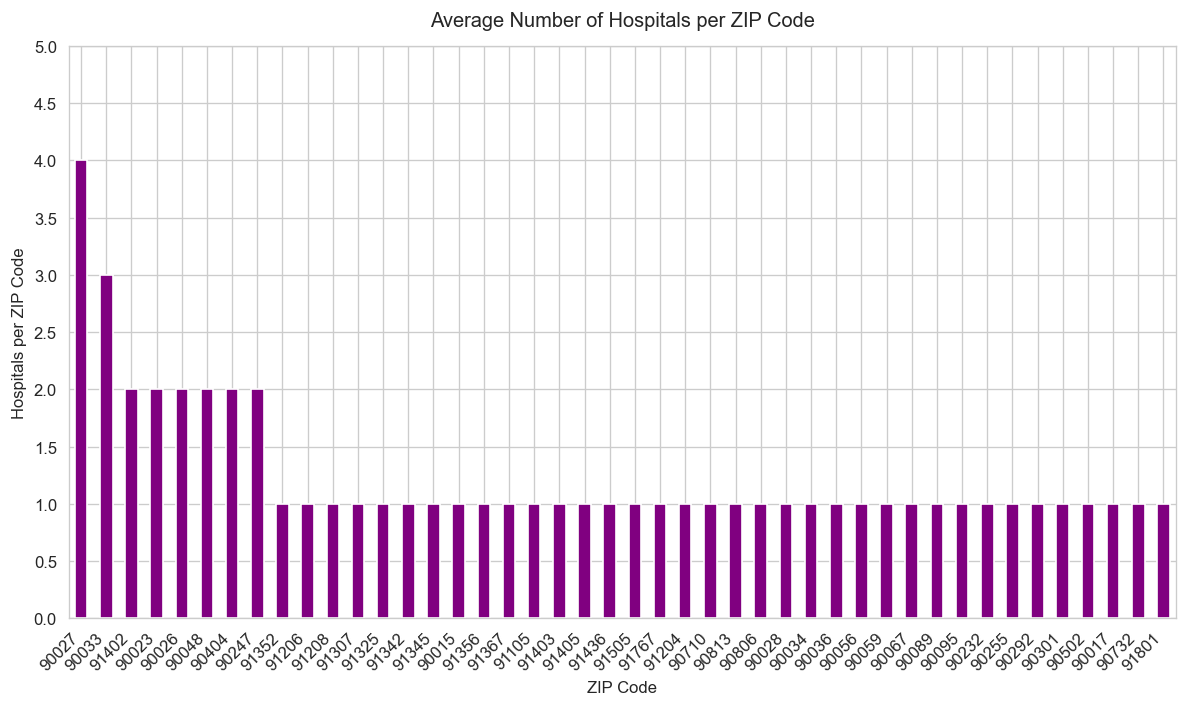

In [236]:
# Group by ZIP code
avg_hospitals = merged_df.groupby('ZIP Code')['hospitals_per_zip'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_hospitals.plot(kind='bar', color='purple')

plt.title('Average Number of Hospitals per ZIP Code')
plt.ylabel('Hospitals per ZIP Code')
plt.xlabel('ZIP Code')
plt.xticks(rotation=45, ha='right')

# Add more y-axis ticks (more frequent intervals)
y_min, y_max = plt.ylim()
plt.yticks(np.arange(0, y_max + 1, step=0.5))

plt.tight_layout()
plt.show()

This visualization shows the distribution of hospital density across ZIP codes.
Areas with fewer hospitals may indicate potential disparities in healthcare accessibility relative to crime occurrences.

**Bar Chart: Crimes by Distance to Nearest Hospital**

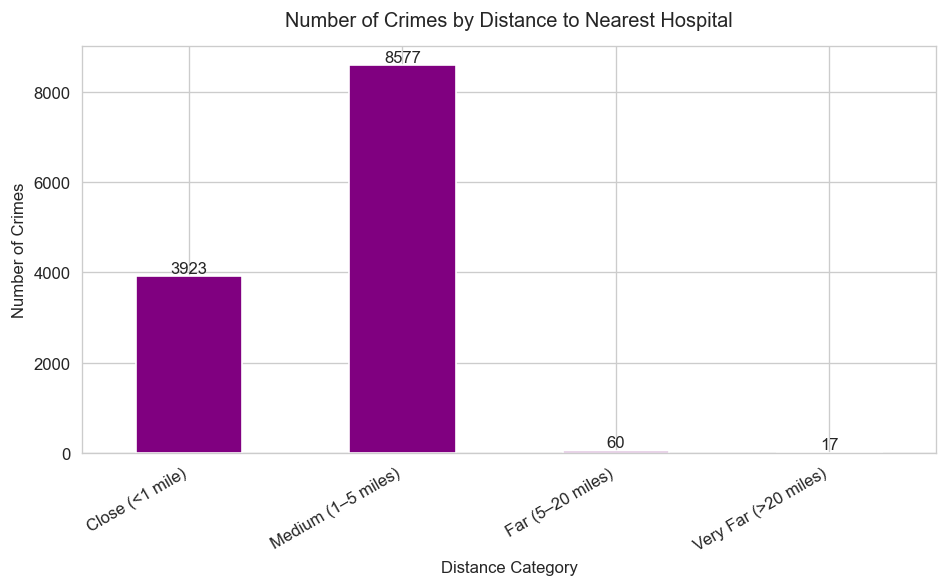

In [237]:
# Count of crimes per distance category
distance_counts = merged_df['distance_category'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
distance_counts.plot(kind='bar', color='purple')

plt.title('Number of Crimes by Distance to Nearest Hospital')
plt.ylabel('Number of Crimes')
plt.xlabel('Distance Category')
plt.xticks(rotation=30, ha='right')

# Optional: annotate counts on top of bars
for i, count in enumerate(distance_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


- **Close (<1 mile) - 3,923 crimes**: The majority of crimes occur close to hospitals, suggesting that most incidents happen within urban or well-served areas.  
- **Medium (1–5 miles) - 8,577 crimes**: Surprisingly, the highest number of crimes falls in the medium distance range. This may reflect suburban areas where hospital access is moderate.  
- **Far (5–20 miles) - 60 crimes & Very Far (>20 miles) - 17 crimes**: Very few crimes occur far from hospitals, indicating that remote areas experience much lower crime incidence or fewer reports. Another case is that outliers or rural regions have minimal hospital coverage. 

### Census Data Integration
---

#### Variables Added to Dataset

#### Poverty Metrics
- **Poverty_Rate**: Percentage of population below poverty line
- **Population_For_Poverty_Determination**: Total population used for poverty calculations  
- **Population_Under_0.50_Poverty_Level**: Population with income under 50% of poverty level
- **Population_0.50_to_0.99_Poverty_Level**: Population with income 50-99% of poverty level

#### Household Structure  
- **Single_Parent_Rate**: Percentage of households headed by single parents
- **Total_Households**: Total number of households in census tract
- **Average_Household_Size**: Average number of people per household

#### Economic Indicators
- **Median_Household_Income**: Median household income in dollars
- **Uninsured_Rate**: Percentage of population without health insurance

#### Education Levels
- **Mean_Education_Level**: Dominant education level category in tract (no_degree, hs_diploma_ged, some_college, associate, bachelors, masters, professional, doctorate)
- **Mean_Education_Level_Ordinal**: Numeric representation of education level (1-8 scale)

#### Social Variables
- **Total_Citizenship_Status**: Population for citizenship determination  
- **Total_Employment_Status**: Population for employment statistics

These census tract-level variables provide neighborhood socioeconomic context that may correlate with sexual assault reporting patterns and delayed reporting behaviors.

In [238]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pytidycensus as tc
import os

# Set API key for pytidycensus
tc.set_census_api_key("6f5f7ad3a080592134d0ab01166ec2ed19c7d9f4")

Census API key has been set for this session.


In [239]:
# Get California tract data with geometry
ca_tract = tc.get_acs(
    geography="tract",
    variables=["C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"],
    state="CA",
    year=2022,
    output="wide",
    geometry=True
)

ca_tract = ca_tract.to_crs(epsg=32617)

print(ca_tract.head(2))
print('Shape', ca_tract.shape)
print("\nThe projection is: {}".format(ca_tract.crs))

Getting data from the 2018-2022 5-year ACS
         GEOID                                           geometry  \
0  06077005127  POLYGON ((-3098675.089 5043837.504, -3097954.5...   
1  06077003406  POLYGON ((-3089049.504 5067117.448, -3088653.6...   

   C17002_001E  C17002_002E  C17002_003E  B01003_001E state county   tract  \
0         7037          542          102         7580    06    077  005127   
1         3768          382          580         3768    06    077  003406   

                             NAME  C17002_001_moe  C17002_002_moe  \
0  San Joaquin County, California           650.0           322.0   
1  San Joaquin County, California           698.0           203.0   

   C17002_003_moe  B01003_001_moe  
0           100.0          1068.0  
1           432.0           698.0  
Shape (9109, 14)

The projection is: EPSG:32617


In [240]:
# Calculate poverty rate
ca_poverty_tract = ca_tract.copy()  
ca_poverty_tract["Poverty_Rate"] = (
    (ca_poverty_tract["C17002_002E"] + ca_poverty_tract["C17002_003E"]) / ca_poverty_tract["B01003_001E"] * 100
)

print(ca_poverty_tract.head(2))

         GEOID                                           geometry  \
0  06077005127  POLYGON ((-3098675.089 5043837.504, -3097954.5...   
1  06077003406  POLYGON ((-3089049.504 5067117.448, -3088653.6...   

   C17002_001E  C17002_002E  C17002_003E  B01003_001E state county   tract  \
0         7037          542          102         7580    06    077  005127   
1         3768          382          580         3768    06    077  003406   

                             NAME  C17002_001_moe  C17002_002_moe  \
0  San Joaquin County, California           650.0           322.0   
1  San Joaquin County, California           698.0           203.0   

   C17002_003_moe  B01003_001_moe  Poverty_Rate  
0           100.0          1068.0      8.496042  
1           432.0           698.0     25.530786  


In [241]:
#Get household and family structure variables
household_vars = [
    "B11001_001E",  # Household type total
    "B11001_005E",  # Female householder, no husband present
    "B11001_006E",  # Male householder, no wife present
    "B25010_001E"   # Average household size
]

ca_household = tc.get_acs(
    geography="tract",
    variables=household_vars,
    state="CA", 
    year=2022,
    output="wide"
)

print(ca_household.head(2))
print(f"Household data shape: {ca_household.shape}")

Getting data from the 2018-2022 5-year ACS
         GEOID  B11001_001E  B11001_005E  B11001_006E B25010_001E state  \
0  06001400100         1377           76           61        2.37    06   
1  06001400200          876           16           30        2.31    06   

  county   tract                        NAME  B11001_001_moe  B11001_005_moe  \
0    001  400100  Alameda County, California           131.0            65.0   
1    001  400200  Alameda County, California            86.0            17.0   

   B11001_006_moe B25010_001_moe  
0            36.0            0.2  
1            20.0           0.14  
Household data shape: (9129, 13)


In [242]:
# Get income and education variables
income_edu_vars = [
    "B19013_001E",  # Median household income
    "B15003_001E",  # Educational attainment total
    
    # High school and below (add these)
    "B15003_017E",  # Regular high school diploma
    "B15003_018E",  # GED or alternative credential
    "B15003_019E",  # Some college, less than 1 year
    "B15003_020E",  # Some college, 1 or more years, no degree
    
    # College degrees
    "B15003_021E",  # Associate's degree
    "B15003_022E",  # Bachelor's degree
    "B15003_023E",  # Master's degree
    "B15003_024E",  # Professional degree
    "B15003_025E",  # Doctorate degree
    
    # Less than high school
    "B15003_002E",  # No schooling completed
    "B15003_003E",  # Nursery school
    "B15003_004E",  # Kindergarten
    "B15003_005E",  # 1st grade
    "B15003_006E",  # 2nd grade
    "B15003_007E",  # 3rd grade
    "B15003_008E",  # 4th grade
    "B15003_009E",  # 5th grade
    "B15003_010E",  # 6th grade
    "B15003_011E",  # 7th grade
    "B15003_012E",  # 8th grade
    "B15003_013E",  # 9th grade
    "B15003_014E",  # 10th grade
    "B15003_015E",  # 11th grade
    "B15003_016E",  # 12th grade, no diploma
]

ca_income_edu = tc.get_acs(
    geography="tract",
    variables=income_edu_vars,
    state="CA",
    year=2022,
    output="wide"
)

print(ca_income_edu.head(2))
print(f"Income/education data shape: {ca_income_edu.shape}")

Getting data from the 2018-2022 5-year ACS
Large table request: 52 variables will be retrieved in chunks
         GEOID B19013_001E  B15003_001E  B15003_017E  B15003_018E  \
0  06001400100      234236         2522           64           10   
1  06001400200      225500         1740           83           15   

   B15003_019E  B15003_020E  B15003_021E  B15003_022E  B15003_023E  ...  \
0            0          212           60          946          665  ...   
1           22           27           40          599          524  ...   

   B15003_007_moe  B15003_008_moe  B15003_009_moe  B15003_010_moe  \
0            13.0            13.0            13.0            13.0   
1            13.0            13.0            13.0            13.0   

   B15003_011_moe  B15003_012_moe  B15003_013_moe  B15003_014_moe  \
0            13.0            13.0            33.0            13.0   
1            13.0            13.0            13.0            13.0   

   B15003_015_moe  B15003_016_moe  
0        

In [243]:
# Get the social variables
working_social_vars = [
    "B05001_001E",  # Citizenship status
    "B23025_001E",  # Employment status
]

ca_social = tc.get_acs(
    geography="tract", 
    variables=working_social_vars,
    state="CA",
    year=2022,
    output="wide"
)

print(ca_social.head(2))
print(f"Social data shape: {ca_social.shape}")

Getting data from the 2018-2022 5-year ACS
         GEOID  B05001_001E  B23025_001E state county   tract  \
0  06001400100         3269         2648    06    001  400100   
1  06001400200         2147         1836    06    001  400200   

                         NAME  B05001_001_moe  B23025_001_moe  
0  Alameda County, California           452.0           286.0  
1  Alameda County, California           201.0           193.0  
Social data shape: (9129, 9)


In [244]:
# Get health insurance variables
health_insurance_vars = [
    "B27001_001E",  # Total population for health insurance determination
    "B27001_002E",  # Under 19 years with health insurance coverage
    "B27001_003E",  # Under 19 years with no health insurance coverage
    "B27001_004E",  # 19-34 years with health insurance coverage
    "B27001_005E",  # 19-34 years with no health insurance coverage
    "B27001_006E",  # 35-64 years with health insurance coverage
    "B27001_007E",  # 35-64 years with no health insurance coverage
    "B27001_008E",  # 65+ years with health insurance coverage
    "B27001_009E",  # 65+ years with no health insurance coverage
]

ca_health_insurance = tc.get_acs(
    geography="tract", 
    variables=health_insurance_vars,
    state="CA",
    year=2022,
    output="wide"
)

print(ca_health_insurance.head(2))
print(f"Health insurance data shape: {ca_health_insurance.shape}")

Getting data from the 2018-2022 5-year ACS
         GEOID  B27001_001E  B27001_002E  B27001_003E  B27001_004E  \
0  06001400100         3269         1621           72           72   
1  06001400200         2147         1075           99           99   

   B27001_005E  B27001_006E  B27001_007E  B27001_008E  B27001_009E  ...  \
0            0          300          300            0           42  ...   
1            0           60           60            0           86  ...   

                         NAME B27001_001_moe B27001_002_moe B27001_003_moe  \
0  Alameda County, California          452.0          339.0           42.0   
1  Alameda County, California          201.0          138.0           35.0   

   B27001_004_moe  B27001_005_moe  B27001_006_moe  B27001_007_moe  \
0            42.0            13.0           216.0           216.0   
1            35.0            13.0            35.0            35.0   

   B27001_008_moe  B27001_009_moe  
0            13.0            54.0  
1    

#### Merge Census Datasets

Combine all census data sources (poverty, household, income/education, social, health insurance) into a single comprehensive dataset using GEOID as the unique identifier

In [245]:
# Merge all census datasets together with proper suffixes
census_merged_df = ca_tract.merge(ca_household, on='GEOID', how='left', suffixes=('', '_household'))
census_merged_df = census_merged_df.merge(ca_income_edu, on='GEOID', how='left', suffixes=('', '_income_edu')) 
census_merged_df = census_merged_df.merge(ca_social, on='GEOID', how='left', suffixes=('', '_social'))
census_merged_df = census_merged_df.merge(ca_health_insurance, on='GEOID', how='left', suffixes=('', '_health'))
print(f"Final census dataset shape: {census_merged_df.shape}")

Final census dataset shape: (9109, 112)


#### Column Name Mapping
Convert Census variable codes to human-readable names for better interpretability and easier feature selection in modeling

In [246]:
column_rename_dict = {
    # Basic demographics
    "B01003_001E": "Total_Population",
    
    # Poverty variables
    "C17002_001E": "Population_For_Poverty_Determination",
    "C17002_002E": "Population_Under_0.50_Poverty_Level",
    "C17002_003E": "Population_0.50_to_0.99_Poverty_Level",
    
    # Household structure
    "B11001_001E": "Total_Households",
    "B11001_005E": "Single_Mother_Households",
    "B11001_006E": "Single_Father_Households",
    "B25010_001E": "Average_Household_Size",
    
    # Income and education
    "B19013_001E": "Median_Household_Income",
    "B15003_001E": "Total_Education_Population",
    
    # High school and some college
    "B15003_017E": "High_School_Diploma",
    "B15003_018E": "GED",
    "B15003_019E": "Some_College_Less_1_Year",
    "B15003_020E": "Some_College_1_Plus_Years",
    
    # College degrees
    "B15003_021E": "Associates_Degree",
    "B15003_022E": "Bachelors_Degree",
    "B15003_023E": "Masters_Degree",
    "B15003_024E": "Professional_Degree",
    "B15003_025E": "Doctorate_Degree",
    
    # Less than high school (first few levels)
    "B15003_002E": "No_Schooling",
    "B15003_003E": "Nursery_School",
    "B15003_004E": "Kindergarten",
    "B15003_005E": "1st_Grade",
    "B15003_006E": "2nd_Grade",
    "B15003_007E": "3rd_Grade",
    "B15003_008E": "4th_Grade",
    "B15003_009E": "5th_Grade",
    "B15003_010E": "6th_Grade",
    "B15003_011E": "7th_Grade",
    "B15003_012E": "8th_Grade",
    "B15003_013E": "9th_Grade",
    "B15003_014E": "10th_Grade",
    "B15003_015E": "11th_Grade",
    "B15003_016E": "12th_Grade_No_Diploma",
    
    # Social variables
    "B05001_001E": "Total_Citizenship_Status",
    "B23025_001E": "Total_Employment_Status",
    
    # Health insurance variables
    "B27001_001E": "Total_Health_Insurance_Coverage",
    "B27001_002E": "Under_19_With_Insurance",
    "B27001_003E": "Under_19_Without_Insurance",
    "B27001_004E": "Age_19_34_With_Insurance",
    "B27001_005E": "Age_19_34_Without_Insurance",
    "B27001_006E": "Age_35_64_With_Insurance",
    "B27001_007E": "Age_35_64_Without_Insurance",
    "B27001_008E": "Age_65_Plus_With_Insurance",
    "B27001_009E": "Age_65_Plus_Without_Insurance"
}

# Rename the columns in the census dataframe
census_merged_df = census_merged_df.rename(columns=column_rename_dict)

print(f"Dataset shape: {census_merged_df.shape}")


Dataset shape: (9109, 112)


#### Education Level Binning

Create categorical and ordinal education level variables from detailed census education data. This transforms raw education counts into meaningful tract-level education profiles.

In [247]:
# Calculate the education level bins and scores
education_level_mapping = {
    'no_degree': 1,
    'hs_diploma_ged': 2, 
    'some_college': 3,
    'associate': 4,
    'bachelors': 5,
    'masters': 6,
    'professional': 7,
    'doctorate': 8
}

def get_dominant_education(row):
    education_levels = {
        'doctorate': row['Doctorate_Degree'],
        'professional': row['Professional_Degree'], 
        'masters': row['Masters_Degree'],
        'bachelors': row['Bachelors_Degree'],
        'associate': row['Associates_Degree'],
        'some_college': row['Some_College_Less_1_Year'] + row['Some_College_1_Plus_Years'],
        'hs_diploma_ged': row['High_School_Diploma'] + row['GED'],
        'no_degree': row.get('Less_Than_HS', 0)
    }
    return max(education_levels, key=education_levels.get)

# Calculate Less_Than_HS
census_merged_df['Less_Than_HS'] = (
    census_merged_df['No_Schooling'] + census_merged_df['Nursery_School'] + 
    census_merged_df['Kindergarten'] + census_merged_df['1st_Grade'] + 
    census_merged_df['2nd_Grade'] + census_merged_df['3rd_Grade'] + 
    census_merged_df['4th_Grade'] + census_merged_df['5th_Grade'] + 
    census_merged_df['6th_Grade'] + census_merged_df['7th_Grade'] + 
    census_merged_df['8th_Grade'] + census_merged_df['9th_Grade'] + 
    census_merged_df['10th_Grade'] + census_merged_df['11th_Grade'] + 
    census_merged_df['12th_Grade_No_Diploma']
)

# Apply the education level function with clearer naming
census_merged_df['Mean_Education_Level'] = census_merged_df.apply(get_dominant_education, axis=1)
census_merged_df['Mean_Education_Level_Ordinal'] = census_merged_df['Mean_Education_Level'].map(education_level_mapping)


#### Calculate Census Metrics with Error Handling

This code calculates key demographic rates from census data with built-in error handling to prevent division by zero errors.

#### Metrics Calculated:

- **Poverty Rate**: Percentage of population below poverty line
- **Single Parent Rate**: Percentage of households headed by single parents  
- **Uninsured Rate**: Percentage of population without health insurance coverage

#### Error Handling:
- Prevents crashes from zero population tracts
- Sets rate to 0 when denominator is zero
- Uses np.where() for efficient conditional calculation

In [248]:
# Calculate all metrics with error handling for division by zero

# Poverty Rate
census_merged_df["Poverty_Rate"] = np.where(
    census_merged_df["Total_Population"] > 0,
    ((census_merged_df["Population_Under_0.50_Poverty_Level"] + census_merged_df["Population_0.50_to_0.99_Poverty_Level"]) / 
     census_merged_df["Total_Population"] * 100),
    0
)

# Single Parent Rate
census_merged_df["Single_Parent_Rate"] = np.where(
    census_merged_df["Total_Households"] > 0,
    ((census_merged_df["Single_Mother_Households"] + census_merged_df["Single_Father_Households"]) / census_merged_df["Total_Households"] * 100),
    0
)

# Health Insurance Rates
census_merged_df["Total_With_Insurance"] = (
    census_merged_df["Under_19_With_Insurance"] + census_merged_df["Age_19_34_With_Insurance"] +
    census_merged_df["Age_35_64_With_Insurance"] + census_merged_df["Age_65_Plus_With_Insurance"]
)

census_merged_df["Total_Without_Insurance"] = (
    census_merged_df["Under_19_Without_Insurance"] + census_merged_df["Age_19_34_Without_Insurance"] +
    census_merged_df["Age_35_64_Without_Insurance"] + census_merged_df["Age_65_Plus_Without_Insurance"]
)

census_merged_df["Uninsured_Rate"] = np.where(
    census_merged_df["Total_Health_Insurance_Coverage"] > 0,
    (census_merged_df["Total_Without_Insurance"] / census_merged_df["Total_Health_Insurance_Coverage"] * 100),
    0
)

# Display calculated metrics
print("Calculated census metrics sample (with error handling):")
print(census_merged_df[[
    'GEOID', 'NAME', 'Poverty_Rate', 'Single_Parent_Rate', 
    'Median_Household_Income', 'Average_Household_Size'
]].head(10))

# Check for any issues
print(f"\nTracts with zero population: {(census_merged_df['Total_Population'] == 0).sum()}")
print(f"Tracts with zero households: {(census_merged_df['Total_Households'] == 0).sum()}")

Calculated census metrics sample (with error handling):
         GEOID                            NAME  Poverty_Rate  \
0  06077005127  San Joaquin County, California      8.496042   
1  06077003406  San Joaquin County, California     25.530786   
2  06077004402  San Joaquin County, California     10.858885   
3  06077001700  San Joaquin County, California     25.724382   
4  06077000401  San Joaquin County, California     20.588235   
5  06077003404  San Joaquin County, California     25.382902   
6  06001423000      Alameda County, California     10.595735   
7  06001450200      Alameda County, California      7.056146   
8  06001422200      Alameda County, California      6.341463   
9  06001406201      Alameda County, California     19.361199   

   Single_Parent_Rate Median_Household_Income Average_Household_Size  
0           19.129950                  102440                   4.22  
1           41.406875                   38497                    3.0  
2           21.479714     

#### Merge Census Data with merged_df

In [249]:
# Convert merged_df LAT/LON to geometry
geometry = [Point(lon, lat) for lon, lat in zip(merged_df['LON'], merged_df['LAT'])]

# Create GeoDataFrame from data
merged_gdf = gpd.GeoDataFrame(
    merged_df, 
    geometry=geometry, 
    crs="EPSG:4326"  # WGS84 for LAT/LON
)

# Convert to same CRS as census data
merged_gdf = merged_gdf.to_crs(census_merged_df.crs)

print(f"Your data shape: {merged_gdf.shape}")
print(f"Census data shape: {census_merged_df.shape}")

Your data shape: (12577, 54)
Census data shape: (9109, 120)


##### Clean Spatial Join

Remove index columns from previous spatial join operations. These columns cause merge conflicts when performing new spatial joins

In [250]:
# Remove the existing index_right column from merged_gdf
if 'index_right' in merged_gdf.columns:
    merged_gdf = merged_gdf.drop(columns=['index_right'])
    print("Removed 'index_right' column from merged_gdf")

# Check for any other spatial join leftover columns
spatial_join_columns = ['index_left', 'index_right']
for col in spatial_join_columns:
    if col in merged_gdf.columns:
        merged_gdf = merged_gdf.drop(columns=[col])
        print(f"Removed '{col}' column from merged_gdf")

print("Columns in merged_gdf after cleanup:", merged_gdf.columns.tolist())

Removed 'index_right' column from merged_gdf
Columns in merged_gdf after cleanup: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted', 'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month', 'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON', 'Premis_Category', 'Weapon_Category', 'geometry', 'FACNAME', 'City', 'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR', 'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE', 'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip', 'distance_miles', 'distance_category']


In [251]:
# Perform spatial join to get census tract GEOID for each crime incident
merged_with_tracts = gpd.sjoin(
    merged_gdf, 
    census_merged_df[['GEOID', 'geometry']],
    predicate='within'
)

print(f"After spatial join: {merged_with_tracts.shape}")
print(f"Number of incidents matched to tracts: {merged_with_tracts['GEOID'].notna().sum()}")

After spatial join: (12555, 55)
Number of incidents matched to tracts: 12555


In [252]:
# Verify the join worked
print("\nSpatial join results:")
print(f"Total incidents: {len(merged_with_tracts)}")
print(f"Successfully matched: {merged_with_tracts['GEOID'].notna().sum()}")
print(f"Unmatched incidents: {merged_with_tracts['GEOID'].isna().sum()}")

if merged_with_tracts['GEOID'].notna().any():
    print("\nSample of matched incidents:")
    sample = merged_with_tracts[merged_with_tracts['GEOID'].notna()].head(3)
    print(sample[['LAT', 'LON', 'GEOID']])
else:
    print("No incidents were matched to census tracts!")


Spatial join results:
Total incidents: 12555
Successfully matched: 12555
Unmatched incidents: 0

Sample of matched incidents:
       LAT       LON        GEOID
0  34.0712 -118.3016  06037211420
1  34.3009 -118.4442  06037107010
2  34.2285 -118.4258  06037119700


#### Final Census Variable Selection

Select the most meaningful census variables for our analysis:
- Calculated rates for normalized comparisons
- Education level bins for tract-level education profiles  
- Key economic and household indicators
- Base population denominators for context

Merge selected variables into main dataset using GEOID as the key

In [253]:
# Select census variables to add
census_variables = [
    'GEOID',
    
    # Calculated rates
    'Poverty_Rate',
    'Single_Parent_Rate', 
    'Uninsured_Rate',
    
    # Education level bins
    'Mean_Education_Level',
    'Mean_Education_Level_Ordinal',
    
    # Direct census estimates
    'Median_Household_Income',
    'Average_Household_Size',
    
    # Household composition
    'Total_Households',
    
    # Social variables
    'Total_Citizenship_Status',
    'Total_Employment_Status'
]

print(f"Total census variables to add: {len(census_variables) - 1}")

# Merge census variables into dataset
merged_df = merged_with_tracts.merge(
    census_merged_df[census_variables], 
    on='GEOID', 
    how='left'
)

print(f"Final dataset shape: {merged_df.shape}")

Total census variables to add: 10
Final dataset shape: (12555, 65)


#### Clean merged data set

#### Data Cleaning Pipeline

Prepare the merged dataset for modeling by:
- Handling missing values through imputation
- Ensuring all features are in correct format for machine learning

#### Missing Value Assessment

Check for missing data in census variables before model training. Identifying and quantifying gaps ensures proper handling through imputation or other strategies to maintain dataset integrity.

In [254]:
# Check for missing values in census variables
census_vars_to_check = [
    'Poverty_Rate', 'Single_Parent_Rate', 'Uninsured_Rate',
    'Mean_Education_Level_Ordinal', 'Median_Household_Income', 
    'Average_Household_Size', 'Total_Households', 'Total_Citizenship_Status', 
    'Total_Employment_Status'
]

missing_counts = merged_df[census_vars_to_check].isnull().sum()
missing_vars = missing_counts[missing_counts > 0]

if len(missing_vars) > 0:
    print("Missing values found:")
    for var, count in missing_vars.items():
        print(f"  {var}: {count} missing values")
else:
    print("No missing values found in census variables!")

Missing values found:
  Median_Household_Income: 392 missing values
  Average_Household_Size: 112 missing values


##### Missing Value Analysis

The output shows missing values across multiple census variables:
- 22 incidents couldn't be matched to census tracts (affecting most rates)
- Additional missing values in income/household size from census data gaps
- These will be handled through median imputation to preserve all incidents

In [255]:
# Fill missing numeric values with median

for col in census_vars_to_check:
    if col in merged_df.columns and merged_df[col].isnull().sum() > 0:
        median_val = merged_df[col].median()
        missing_count = merged_df[col].isnull().sum()
        merged_df[col] = merged_df[col].fillna(median_val)
        print(f"  Filled {missing_count} missing values in {col} with median: {median_val:.2f}")

  Filled 392 missing values in Median_Household_Income with median: 63971.00
  Filled 112 missing values in Average_Household_Size with median: 2.71


C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\2102837890.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[col] = merged_df[col].fillna(median_val)
C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\2102837890.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df[col] = merged_df[col].fillna(median_val)


##### Categorical Data Imputation

Handle missing values in categorical variables using mode imputation. This preserves the most common category while maintaining data structure

In [256]:
# Fill missing categorical values with mode

if 'Mean_Education_Level' in merged_df.columns:
    missing_count = merged_df['Mean_Education_Level'].isnull().sum()
    if missing_count > 0:
        mode_val = merged_df['Mean_Education_Level'].mode()[0]
        merged_df['Mean_Education_Level'] = merged_df['Mean_Education_Level'].fillna(mode_val)
        print(f"  Filled {missing_count} missing values in Mean_Education_Level with mode: {mode_val}")
    else:
        print("  No missing values in Mean_Education_Level")
else:
    print("  Mean_Education_Level not found in dataset")

  No missing values in Mean_Education_Level


In [257]:
# Final verification of data cleaning
print("Final data cleaning verification:")

# Check remaining missing values
total_missing = merged_df[census_vars_to_check].isnull().sum().sum()
print(f"Total missing values in census variables: {total_missing}")

print(f"\nDataset shape: {merged_df.shape}")

Final data cleaning verification:
Total missing values in census variables: 0

Dataset shape: (12555, 65)


# Sprint 3 - Modeling the Impact of Contextual Features

### Retraining & Comparing Models
---

In [258]:
# imports
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#### Random Forest with Base Sexual Crimes Dataset
Our best performing model after feature engineering & fairness evaluations was a Random Forest, which had the strongest performance after initial feature engineering and fairness evaluations. In this section, we retrain the model using only the **base sexual crimes dataset**—without any additional contextual or external features.

 This version serves as our **baseline model**, for later comparison when contextual hospital data and census datais introduced. By first evaluating the Random Forest on the original variables, we can clearly see how much contextual information contributes to improving predictive accuracy and model interpretability in subsequent sections.

In [259]:
# target feature
target = "Delay_Category"

# features that we want to use for prediction
numeric_features_base = ["Hour", "Year", "Part 1 2", "Rpt Dist No"]
categorical_features_base = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category"
]

X_base = sexual_crimes[numeric_features_base + categorical_features_base]
y_base = sexual_crimes[target].astype(str)

**Train/Test Split**

In [260]:
# train/test split before encoding
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# encode target
le_base = LabelEncoder()
yb_train_enc = le_base.fit_transform(yb_train)
yb_test_enc = le_base.transform(yb_test)

**Preprocessing**

In [261]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe_base = OneHotEncoder(handle_unknown="ignore")
preprocess_base = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_base),
        ("cat", ohe_base, categorical_features_base),
    ]
)

**Train Baseline Random Forest**

In [262]:
pipeline_base = Pipeline([
    ("preprocess", preprocess_base),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_base.fit(Xb_train, yb_train_enc)
yb_pred = pipeline_base.predict(Xb_test)

In [263]:
# evaluation
acc_base = accuracy_score(yb_test_enc, yb_pred)
f1_base = f1_score(yb_test_enc, yb_pred, average="macro")
report_base = classification_report(yb_test_enc, yb_pred)

print("Base Dataset Performance")
print(f"Accuracy: {acc_base:.3f}, F1-macro: {f1_base:.3f}")
print(report_base)

Base Dataset Performance
Accuracy: 0.541, F1-macro: 0.297
              precision    recall  f1-score   support

           0       0.57      0.92      0.71      1219
           1       0.46      0.36      0.40       435
           2       0.30      0.06      0.10       426
           3       0.36      0.03      0.06       264
           4       0.43      0.15      0.22       131

    accuracy                           0.54      2475
   macro avg       0.42      0.30      0.30      2475
weighted avg       0.47      0.54      0.45      2475



#### Random Forest with Merged Hospital/Census/Sexual Crimes Datasets
To enhance the model’s ability to capture situational and environmental influences, new features from both the hospital dataset and census data were integrated into the existing feature set. These variables provide important context about healthcare accessibility, local demographics, and socioeconomic conditions that may relate to response or delay patterns. Specifically, **hospital distance-based** and **census and socioeconomic variables**. 

By combining these contextual features with the original variables, the goal is to improve model performance and interpretability by accounting for how proximity to hospitals, local medical resources, and community-level socioeconomic factors might influence the target outcome (Delay_Category).

In [264]:
# target feature
target = "Delay_Category"

# features that we want to use for prediction
# included previously used features + new hospital features + census variables
# Update feature lists with census variables
numeric_features_context = numeric_features_base + [
    "distance_miles", 'Poverty_Rate', 'Single_Parent_Rate', 'Uninsured_Rate', 
    'Mean_Education_Level_Ordinal', 'Median_Household_Income', 'Average_Household_Size',
   'Total_Households', 'Total_Citizenship_Status', 'Total_Employment_Status'
]

categorical_features_context = categorical_features_base + [
    "COUNTY_NAME", "distance_category", "hospitals_per_zip",'Mean_Education_Level'
]

X_context = merged_df[numeric_features_context + categorical_features_context]
y_context = merged_df[target].astype(str)

**Train/Test Split**

In [265]:
# train/test split before encoding
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_context, y_context, test_size=0.2, random_state=42, stratify=y_context
)

# encode target
le_context = LabelEncoder()
yc_train_enc = le_context.fit_transform(yc_train)
yc_test_enc = le_context.transform(yc_test)

**Preprocessing**

In [266]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe_context = OneHotEncoder(handle_unknown="ignore")
preprocess_context = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_context),
        ("cat", ohe_context, categorical_features_context),
    ]
)

**Train Context-Improved Random Forest**

In [267]:
pipeline_context = Pipeline([
    ("preprocess", preprocess_context),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_context.fit(Xc_train, yc_train_enc)
yc_pred = pipeline_context.predict(Xc_test)

In [268]:
acc_context = accuracy_score(yc_test_enc, yc_pred)
f1_context = f1_score(yc_test_enc, yc_pred, average="macro")
report_context = classification_report(yc_test_enc, yc_pred)

print("Context-Improved Dataset Performance")
print(f"Accuracy: {acc_context:.3f}, F1-macro: {f1_context:.3f}")
print(report_context)

Context-Improved Dataset Performance
Accuracy: 0.547, F1-macro: 0.319
              precision    recall  f1-score   support

           0       0.57      0.93      0.71      1235
           1       0.44      0.35      0.39       441
           2       0.45      0.08      0.14       433
           3       0.47      0.06      0.11       269
           4       0.58      0.16      0.25       133

    accuracy                           0.55      2511
   macro avg       0.50      0.32      0.32      2511
weighted avg       0.52      0.55      0.47      2511



### Evaluation & Comparison of Models
---

**Performance Comparison: Base & Context-Improved Models**

The **accuracy** increased slightly from **0.541** to **0.547**, and the **macro-averaged F1 score** improved from **0.297** to **0.319**. Although the improvement may appear small, it indicates that the contextual features like hospital proximity and availability helped the model better distinguish between different delay categories. 

Additionally, in the base Random Forest model, it performed best in predicting short delays (Category 0) with strong recall (0.92) and a balanced F1-score (0.71). However, it struggled with categories (2–4), showing lower recall and F1-scores below 0.25, indicating underrepresentation or overlap between classes. With the inclusion of contextual variables, recall and F1 for Categories 2–4 slightly improve. Particularly Category 2 (F1 rising from 0.10 to 0.14) and Category 3 (F1 from 0.06 to 0.11). 

**Influential Features Based on Permutation Importances**

To understand how adding contextual features of hospital data affected predictive power, we took a look at the top 10 most important features from our original Random Forest model with only the sexual crimes data and the improved Random Forest model including the hospital & census data. The permutation importance results highlight how feature relevance shifted after incorporating contextual variables. 

**Interpretation of Results**:
- In both the baseline and context-improved Random Forest models, **Vict Age Group** remained the most influential predictor, indicating that victim age continues to play a critical role in the model’s decision process. Although its importance slightly decreases in the improved model (0.042 -> 0.033). Additionally, **Premis_Category** (crime location) stays important and even increases slightly.
- Time-related features change: Hour became more important in the improved model & DayOfWeek decreased in importance.
- **Crime Description** and **Victim Descent** drop in importance, suggesting some of the patterns they captured are now explained by the new contextual features.
- New feature **Poverty_Rate** appears, showing that neighborhood socio-economic factors now help the model.

Adding contextual features (like poverty rate and hospital data) has slightly reduced the reliance on purely crime-specific features, indicating the model now incorporates broader environmental and socio-economic factors in its predictions.

In [269]:
# Top 10 most important features from original Random Forest vs improved Random Forest
from sklearn.inspection import permutation_importance

# Baseline Random Forest
base_perm = permutation_importance(
    pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42
)
base_importance = pd.DataFrame({
    "feature": Xb_test.columns,
    "importance_mean": base_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Context-Improved Random Forest
context_perm = permutation_importance(
    pipeline_context, Xc_test, yc_test_enc, n_repeats=10, random_state=42
)
context_importance = pd.DataFrame({
    "feature": Xc_test.columns,
    "importance_mean": context_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Combine for comparison
comparison_df = pd.DataFrame({
    "Original Top 10 Features": base_importance["feature"].values,
    "Original Importance": base_importance["importance_mean"].values,
    "Improved Top 10 Features": context_importance["feature"].values,
    "Improved Importance": context_importance["importance_mean"].values
})

print("\nFeature Importance Comparison (Top 10)\n")
print(comparison_df.to_string(index=False))


Feature Importance Comparison (Top 10)

Original Top 10 Features  Original Importance Improved Top 10 Features  Improved Importance
          Vict Age Group             0.042061           Vict Age Group             0.032616
         Premis_Category             0.010182          Premis_Category             0.011908
               DayOfWeek             0.008323                     Hour             0.005735
                    Year             0.007677                     Year             0.003704
             Crm Cd Desc             0.006303              Crm Cd Desc             0.003664
                    Hour             0.005414                DayOfWeek             0.002628
       Vict Descent Full             0.002909                    Month             0.002509
                   Month             0.002869        Vict Descent Full             0.001235
           Time_Category             0.001778             Poverty_Rate             0.001035
         Weapon_Category             0.

**Confusion Matrices**

The confusion matrices below show the classification performance of the **Baseline Random Forest** (left) and the **Context-Improved Random Forest** (right), with values normalized by true labels.

- **0–1 days:** Both models predict this majority class with very high accuracy (92–93%), showing minimal confusion. This suggests the model consistently identifies rapid response cases correctly.

- **1–12 months:** The context-improved model slightly decreases correct predictions (from 36% to 35%) for this class. 

- **1–7 days, 8–30 days, Over 1 year:** The improved model had a higher accuracy for all three of these classes. Particularly for the “8-30 days” category, the context model raised true positive rates from 0.3 to 0.063.

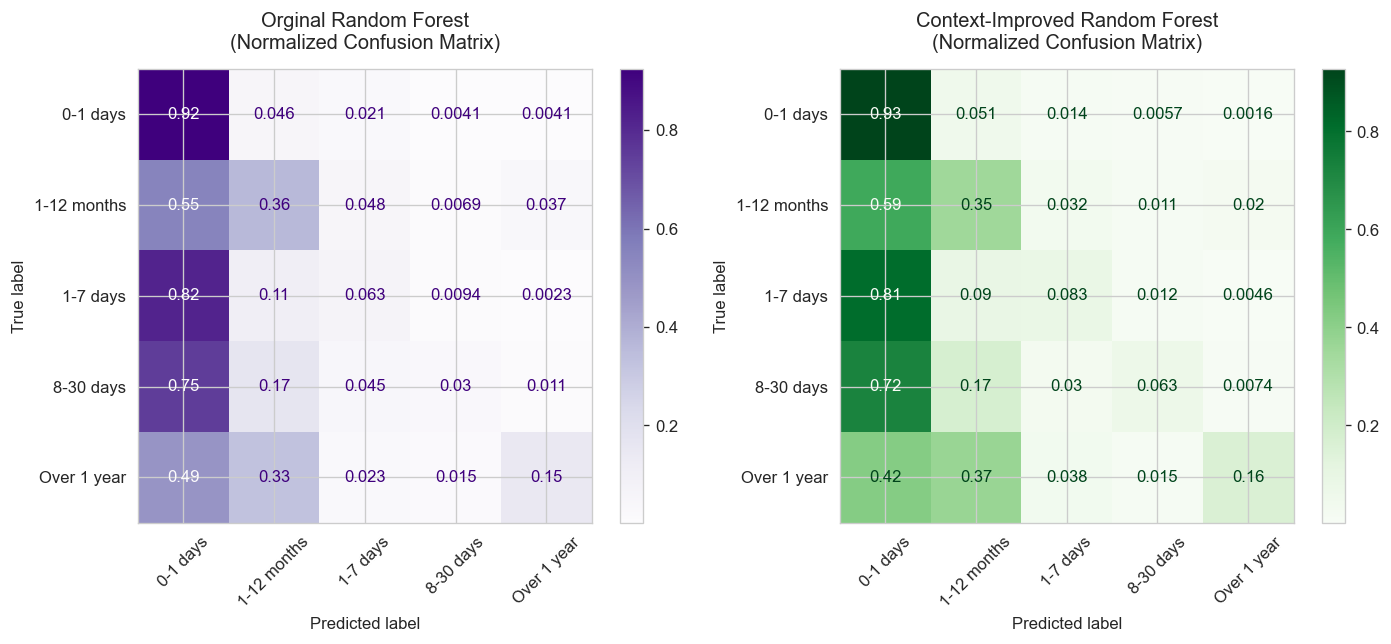

In [270]:
# 1x2 subplot for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Baseline Random Forest
ConfusionMatrixDisplay.from_estimator(
    pipeline_base,
    Xb_test,
    yb_test_enc,
    display_labels=le_base.classes_,
    cmap='Purples',
    normalize='true',
    ax=axes[0]
)
axes[0].set_title("Orginal Random Forest\n(Normalized Confusion Matrix)")
axes[0].tick_params(axis='x', rotation=45)

# Confusion Matrix for Context-Improved Random Forest
ConfusionMatrixDisplay.from_estimator(
    pipeline_context,
    Xc_test,
    yc_test_enc,
    display_labels=le_context.classes_,
    cmap='Greens',
    normalize='true',
    ax=axes[1]
)
axes[1].set_title("Context-Improved Random Forest\n(Normalized Confusion Matrix)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Sprint 4 - Fairness, Bias, and Accountability Audit

### Identify Groups for Fairness Evaluation
---
When we consider what victims might be unfairly affected if the model performs worse for certain groups,  we consider possible candidates from our dataset such as: 
- Victim Characteristics: Vict Sex, Vict Age Group
- Neihborhoods/Regions: AREA NAME, COUNTY_NAME
- Social/Environmental Conditions: Poverty_rate, Median_Household_Income
- Institutional Access: distance_category, hospitals_per_zip
- Temporal: DayOfWeek, Time_Category

From those candidates, we would like to focus on these 3 fairness groups to audit:
1. Vict Age Group: age related fairness (model shouldn't perform better for adults than for children)
2. AREA NAME: neighborhood fairness (spatial disparities)
3. Poverty_Rate (binned): socioeconomic fairness (reflects systemic inequity)

We selected Vict Age Group, AREA NAME, and Poverty_Rate as fairness groups because they capture social, spatial, and economic dimensions of disparity that may influence reporting and response delays.

In [271]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# grouping variables for fairness comparison
group_vars = ["Vict Age Group", "AREA NAME"]

In [272]:
# Attatch predicted values and true labels for analysis
fairness_df = Xc_test.copy()
fairness_df["true_label"] = yc_test_enc
fairness_df["pred_label"] = yc_pred
fairness_df["Vict Age Group"] = Xc_test["Vict Age Group"]
fairness_df["AREA NAME"] = Xc_test["AREA NAME"]
fairness_df["Poverty_Rate"] = Xc_test["Poverty_Rate"]

fairness_df.head()

,Hour,Year,Part 1 2,Rpt Dist No,distance_miles,Poverty_Rate,Single_Parent_Rate,Uninsured_Rate,Mean_Education_Level_Ordinal,Median_Household_Income,...,Weapon_Category,Month,DayOfWeek,Time_Category,COUNTY_NAME,distance_category,hospitals_per_zip,Mean_Education_Level,true_label,pred_label
2706,11,2020,1,779,2.603622,22.774159,35.280374,12.893594,1,50606.0,...,"No Weapon, Physical Force",Jun,Tue,Morning (6-12),LOS ANGELES,Medium (1–5 miles),1,no_degree,0,0
12234,8,2024,2,1801,3.367696,41.123596,48.888889,24.751914,1,33396.0,...,"No Weapon, Physical Force",Apr,Wed,Morning (6-12),LOS ANGELES,Medium (1–5 miles),1,no_degree,0,0
242,14,2020,2,1373,2.099617,30.046296,50.533463,30.555556,1,53977.0,...,"No Weapon, Physical Force",Nov,Wed,Afternoon (12-18),LOS ANGELES,Medium (1–5 miles),1,no_degree,1,0
6581,14,2022,1,782,0.273269,12.144982,19.765625,11.387612,5,79231.0,...,"Knife, Sharp Object",Jan,Sun,Afternoon (12-18),LOS ANGELES,Close (<1 mile),1,bachelors,0,0
5911,16,2021,1,645,1.209920,25.014443,9.693455,5.549133,5,55866.0,...,"No Weapon, Physical Force",May,Thu,Afternoon (12-18),LOS ANGELES,Medium (1–5 miles),1,bachelors,0,0


### Group-Level Performance Metrics
---
Our fairness audit revealed disparities in model performance across age, geography, and socioeconomic context. Accuracy and F1-scores were notably lower for younger victims (children and adolescents), which could reflect underreporting in those groups. Similarily, areas with high poverty levels had slightly higher false negative rates, suggesting the model could be less sensitive to disadvantaged neighborhoods. 

In [273]:
# Function to compute metrics by group
def compute_group_metrics(df, group_col):
    group_metrics = []
    for group, data in df.groupby(group_col):
        acc = accuracy_score(data["true_label"], data["pred_label"])
        prec = precision_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        rec = recall_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        f1 = f1_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)

        # Compute confusion matrix for FPR/FNR
        tn, fp, fn, tp = confusion_matrix(data["true_label"], data["pred_label"], labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        group_metrics.append({
            group_col: group,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            'FPR': fpr,
            'FNR': fnr
        })
    return pd.DataFrame(group_metrics).sort_values("Accuracy", ascending=False)

**Victim Age Group Fairness Performance**
- The model's accuracy performs best for adults (18+), but the FNR is relatively high for all three age groups - Young Adults (0.91), Adults (0.98), and Older Adults(0.90) - meaning that the model misses most actual positive cases in those groups.
- Children and Adolescents have lower accuracies, but the model identifies a larger fraction of actual positives (lower FNR than adults).
- F1 is low for all groups (<0.33), indicating overall model struggles with multi-class prediction and class imbalance.

This suggests that the model favors adults in accuracy, but fails to identify actual delays effectively. 

In [274]:
# Compute metrics by Victim Age Group
metrics_by_age = compute_group_metrics(fairness_df, "Vict Age Group")
metrics_by_age

,Vict Age Group,Accuracy,Precision,Recall,F1,FPR,FNR
3,Older Adults (50+),0.623810,0.622222,0.266036,0.268250,0.008197,0.904762
4,Young Adults (18-24),0.616702,0.515604,0.236894,0.223909,0.003597,0.912281
1,Adults (25-49),0.574468,0.561116,0.251248,0.241944,0.006944,0.975207
0,Adolescents (13-17),0.473258,0.444333,0.339164,0.324515,0.259259,0.263158
2,Children (0-12),0.377049,0.360392,0.312632,0.290745,0.181818,0.581395


**Area Fairness Performance**
- We found that performance is uneven across neighborhoods. Specifically, Central (0.96 FNR) and Hollywood (0.72) have the highest FNRs annd low F1s, meaning the model misses many actual delays.
- There is also a potential of bias because certain neighborhoods are getting lower recalls & F1 scores, which could reflect structural issues or underrepresentation in the data.

In [275]:
# Compute metrics by Area of Crime Occurence
metrics_by_area = compute_group_metrics(fairness_df, "AREA NAME")
metrics_by_area.head(10)  # Show top 10 areas

,AREA NAME,Accuracy,Precision,Recall,F1,FPR,FNR
20,Wilshire,0.683824,0.748611,0.461714,0.532919,0.037500,0.666667
10,Northeast,0.666667,0.842807,0.549683,0.600317,0.027778,0.357143
14,Southeast,0.642857,0.394897,0.345354,0.350374,0.014085,0.666667
1,Central,0.608696,0.233103,0.207797,0.178611,0.017857,0.960000
15,Southwest,0.606897,0.391076,0.295529,0.293147,0.000000,0.681818
6,Hollywood,0.596774,0.535944,0.284233,0.294247,0.048077,0.720000
4,Harbor,0.590476,0.639356,0.371832,0.372826,0.019608,0.428571
0,77th Street,0.584112,0.600105,0.345391,0.363484,0.081081,0.538462
13,Rampart,0.562500,0.574054,0.327352,0.344499,0.032258,0.608696
8,N Hollywood,0.533981,0.351754,0.311550,0.293171,0.022727,0.500000


In [276]:
# Looking at Poverty Rate distribution for binning
merged_df['Poverty_Rate'].describe()

count    12555.000000
mean        19.479403
std         12.239142
min          0.000000
25%         10.086239
50%         17.682518
75%         25.927835
max         88.181818
Name: Poverty_Rate, dtype: float64

**Poverty Rate Performance**
- The model performs worst for Very High poverty areas in terms of recall and F1, which means it is systematically missing more true cases where poverty is high.
- We found that there was a higher FNR as we went increased poverty level from low -> moderate -> high -> very high, indicating that the model is less sensitive to delays or incidents affecting these communities.

In [277]:
# Since Poverty_Rate is continuous, we will bin it into categories (e.g., low, medium, high)
fairness_df['Poverty_Level'] = pd.cut(
    fairness_df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

# Compute metrics by Poverty Level
metrics_by_poverty = compute_group_metrics(fairness_df, "Poverty_Level")
metrics_by_poverty.head()

C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\2529767090.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df.groupby(group_col):


,Poverty_Level,Accuracy,Precision,Recall,F1,FPR,FNR
3,Very High,0.593851,0.429052,0.286687,0.285993,0.018018,0.702128
0,Low,0.540984,0.567221,0.341414,0.350078,0.070671,0.603960
2,High,0.533552,0.481966,0.309160,0.308998,0.054983,0.649485
1,Moderate,0.522321,0.531346,0.322026,0.319722,0.069536,0.570248


**Disparity Visualizations**

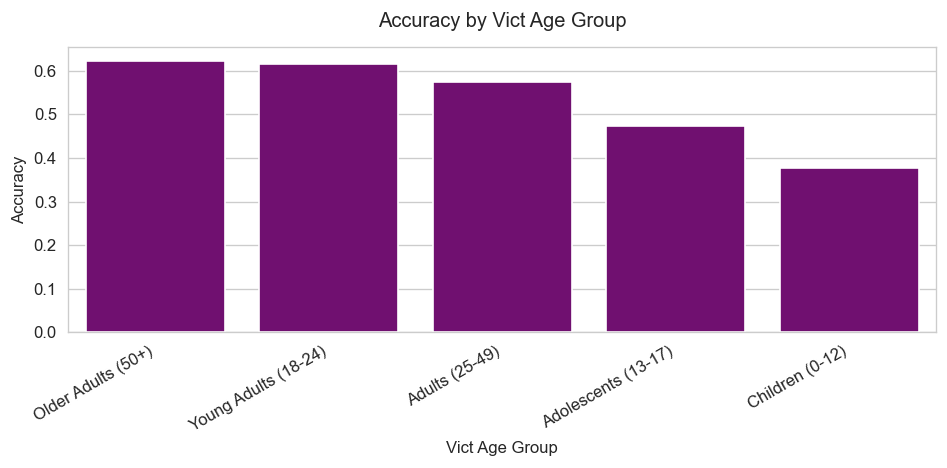

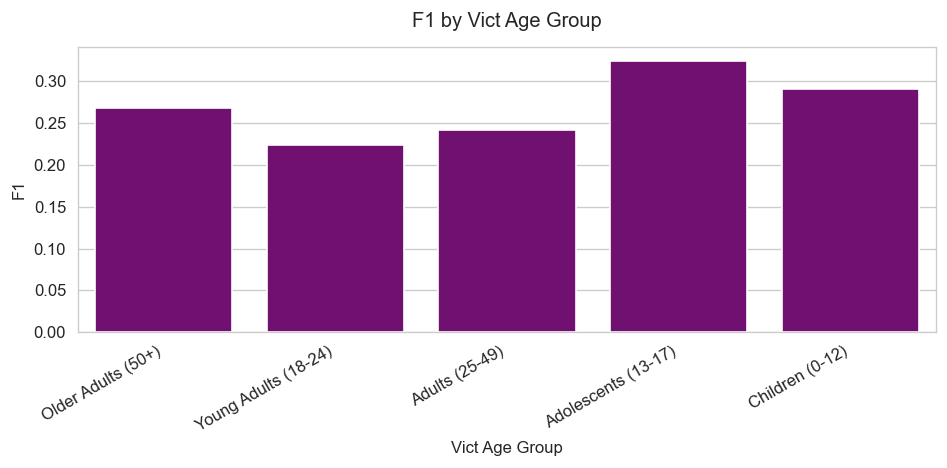

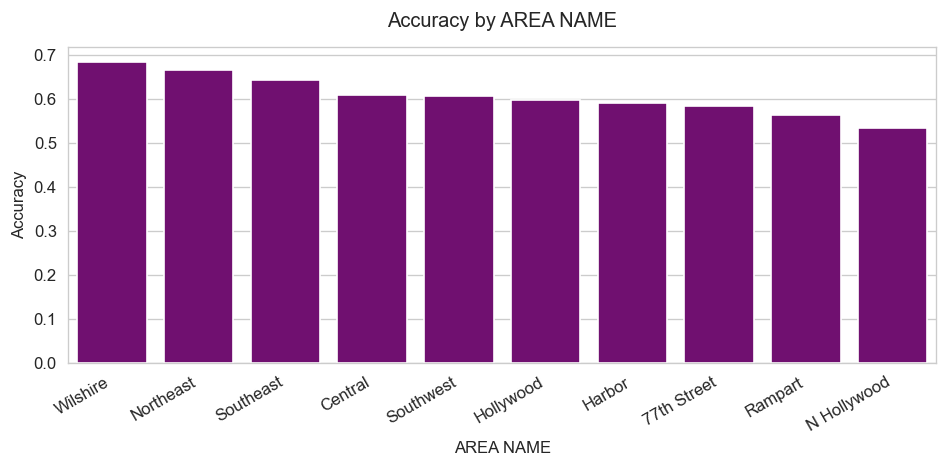

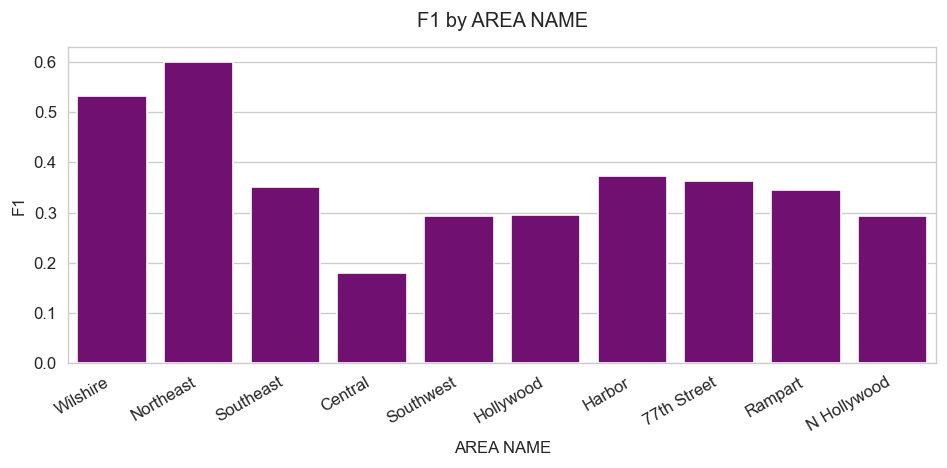

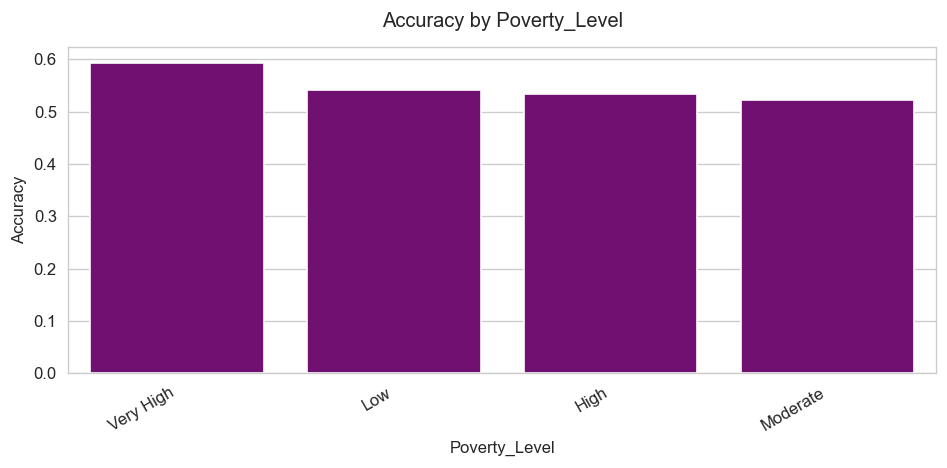

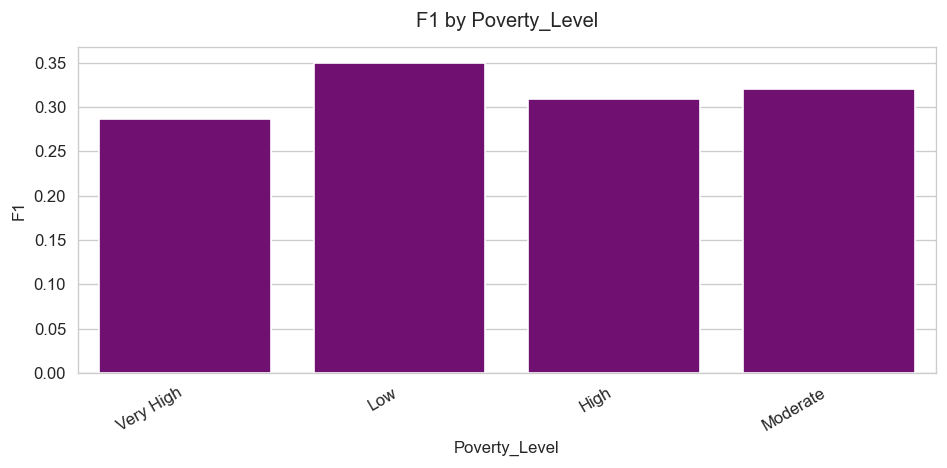

In [278]:
def plot_fairness_metrics(df, group_col, metrics=['Accuracy', 'F1']):
    """
    Plots bar charts of specified metrics by group.
    """
    for metric in metrics:
        plt.figure(figsize=(8,4))
        sns.barplot(data=df, x=group_col, y=metric, color='purple')
        plt.title(f'{metric} by {group_col}')
        plt.ylabel(metric)
        plt.xlabel(group_col)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()

# Visualize disparities for Victim Age Group
plot_fairness_metrics(metrics_by_age, "Vict Age Group")

# Visualize disparities for Area Name (optional: top 10 only)
plot_fairness_metrics(metrics_by_area.head(10), "AREA NAME")

# Visualize disparities for Poverty Level
plot_fairness_metrics(metrics_by_poverty, "Poverty_Level")

**Combined Summary Table of Fairness Audit**

In [279]:
# Add a column identifying which fairness group each table refers to
metrics_by_age["Fairness_Group"] = "Vict Age Group"
metrics_by_area["Fairness_Group"] = "Area Name"
metrics_by_poverty["Fairness_Group"] = "Poverty Level"

# Rename the group columns to a common name for easy concatenation
metrics_by_age = metrics_by_age.rename(columns={"Vict Age Group": "Group"})
metrics_by_area = metrics_by_area.rename(columns={"AREA NAME": "Group"})
metrics_by_poverty = metrics_by_poverty.rename(columns={"Poverty_Level": "Group"})

# Concatenate into one combined dataframe
all_fairness_metrics = pd.concat([metrics_by_age, metrics_by_area, metrics_by_poverty], ignore_index=True)

# Select only key metrics to display
summary_cols = ["Fairness_Group", "Group", "Accuracy", "F1"]
all_fairness_metrics = all_fairness_metrics[summary_cols]

# Preview the summary
display(all_fairness_metrics)

,Fairness_Group,Group,Accuracy,F1
0,Vict Age Group,Older Adults (50+),0.623810,0.268250
1,Vict Age Group,Young Adults (18-24),0.616702,0.223909
2,Vict Age Group,Adults (25-49),0.574468,0.241944
3,Vict Age Group,Adolescents (13-17),0.473258,0.324515
4,Vict Age Group,Children (0-12),0.377049,0.290745
5,Area Name,Wilshire,0.683824,0.532919
6,Area Name,Northeast,0.666667,0.600317
7,Area Name,Southeast,0.642857,0.350374
8,Area Name,Central,0.608696,0.178611
9,Area Name,Southwest,0.606897,0.293147


#### SHAP


Context-Improved Model


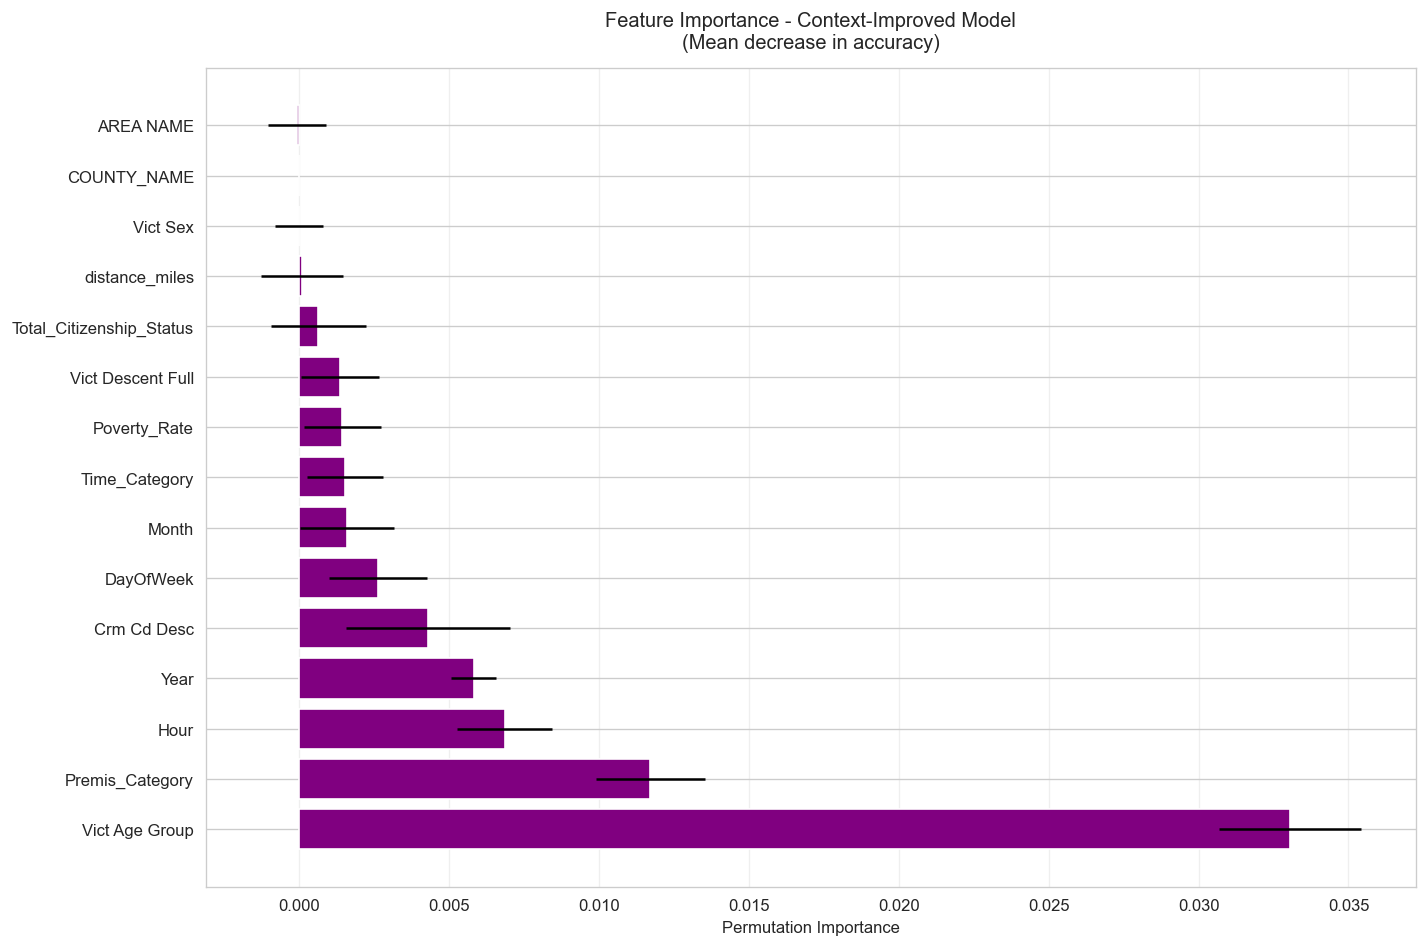

Top features for Context-Improved Model:
                 feature    importance
          Vict Age Group  3.305456e-02
         Premis_Category  1.170848e-02
                    Hour  6.849861e-03
                    Year  5.814417e-03
             Crm Cd Desc  4.301075e-03
               DayOfWeek  2.628435e-03
                   Month  1.592991e-03
           Time_Category  1.513341e-03
            Poverty_Rate  1.433692e-03
       Vict Descent Full  1.354042e-03
Total_Citizenship_Status  6.371963e-04
          distance_miles  7.964954e-05
                Vict Sex  2.220446e-17
             COUNTY_NAME  0.000000e+00
               AREA NAME -7.964954e-05

Baseline Model


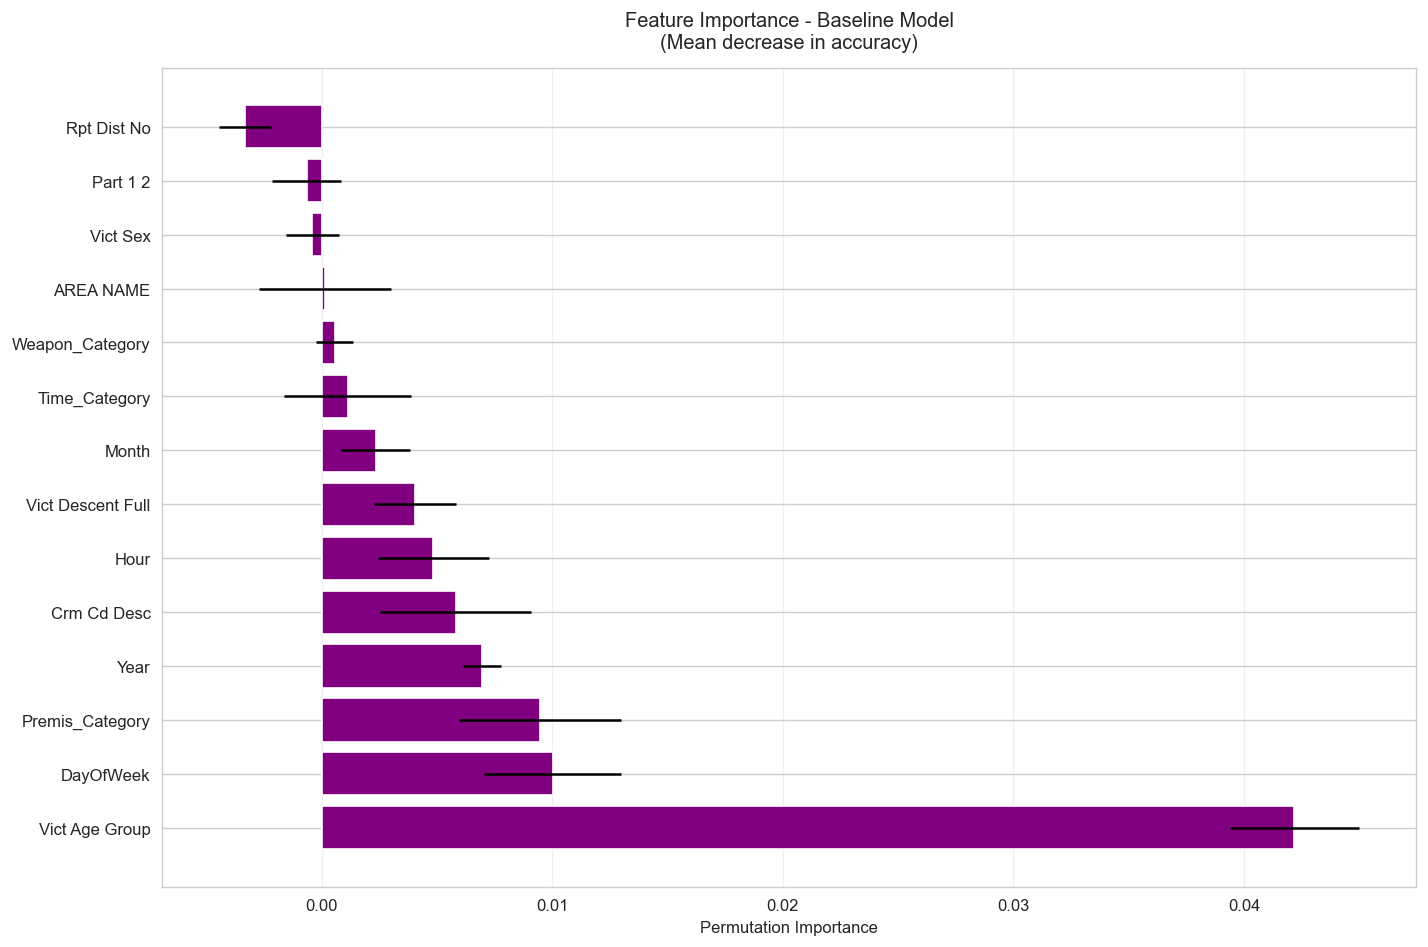

Top features for Baseline Model:
          feature  importance
   Vict Age Group    0.042182
        DayOfWeek    0.010020
  Premis_Category    0.009455
             Year    0.006949
      Crm Cd Desc    0.005818
             Hour    0.004848
Vict Descent Full    0.004040
            Month    0.002343
    Time_Category    0.001131
  Weapon_Category    0.000566
        AREA NAME    0.000162
         Vict Sex   -0.000404
         Part 1 2   -0.000646
      Rpt Dist No   -0.003313


In [280]:
def reliable_feature_importance(pipeline, X_test, y_test, model_name):
    """Reliable feature importance using permutation"""

    perm_result = permutation_importance(
        pipeline, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
    )
    
    # Create results DataFrame
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean,
        'std': perm_result.importances_std
    }).sort_values('importance', ascending=False).head(15)
    
    # Plot
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(importance_df))
    plt.barh(y_pos, importance_df['importance'], xerr=importance_df['std'], color='purple')
    plt.yticks(y_pos, importance_df['feature'])
    plt.xlabel('Permutation Importance')
    plt.title(f'Feature Importance - {model_name}\n(Mean decrease in accuracy)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Top features for {model_name}:")
    print(importance_df[['feature', 'importance']].to_string(index=False))
    
    return importance_df

print("\nContext-Improved Model")
context_importance = reliable_feature_importance(
    pipeline_context, Xc_test, yc_test_enc, "Context-Improved Model"
)

print("\nBaseline Model")
base_importance = reliable_feature_importance(
    pipeline_base, Xb_test, yb_test_enc, "Baseline Model"
)

## SMOTE

In [281]:
print("Delay Category Distribution:")
print(merged_df['Delay_Category'].value_counts().sort_index())
print("\nPercentages:")
print((merged_df['Delay_Category'].value_counts(normalize=True).sort_index() * 100).round(1))

Delay Category Distribution:
Delay_Category
0-1 days       6173
1-12 months    2204
1-7 days       2167
8-30 days      1345
Over 1 year     666
Name: count, dtype: int64

Percentages:
Delay_Category
0-1 days       49.2
1-12 months    17.6
1-7 days       17.3
8-30 days      10.7
Over 1 year     5.3
Name: proportion, dtype: float64


In [282]:
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Preprocessing
ohe_context = OneHotEncoder(handle_unknown="ignore")
preprocess_context = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_context),
        ("cat", ohe_context, categorical_features_context),
    ]
)

# Encode target for SMOTE
le_context = LabelEncoder()
yc_train_enc = le_context.fit_transform(yc_train)
yc_test_enc = le_context.transform(yc_test)

# Pipeline with SMOTE for multi-class
pipeline_context_smote = ImbPipeline([
    ("preprocess", preprocess_context),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_context_smote.fit(Xc_train, yc_train_enc)
yc_pred_smote = pipeline_context_smote.predict(Xc_test)


In [283]:
# Pipeline without SMOTE for comparison
pipeline_context_nosmote = Pipeline([
    ("preprocess", preprocess_context),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_context_nosmote.fit(Xc_train, yc_train_enc)
yc_pred_nosmote = pipeline_context_nosmote.predict(Xc_test)


In [284]:
# Evaluate both models
acc_smote = accuracy_score(yc_test_enc, yc_pred_smote)
f1_smote = f1_score(yc_test_enc, yc_pred_smote, average="macro")

acc_nosmote = accuracy_score(yc_test_enc, yc_pred_nosmote)
f1_nosmote = f1_score(yc_test_enc, yc_pred_nosmote, average="macro")

print(f"With SMOTE:    Accuracy={acc_smote:.3f}, F1-macro={f1_smote:.3f}")
print(f"Without SMOTE: Accuracy={acc_nosmote:.3f}, F1-macro={f1_nosmote:.3f}")
print(f"Difference:    Accuracy={acc_smote-acc_nosmote:+.3f}, F1={f1_smote-f1_nosmote:+.3f}")


With SMOTE:    Accuracy=0.550, F1-macro=0.348
Without SMOTE: Accuracy=0.547, F1-macro=0.319
Difference:    Accuracy=+0.002, F1=+0.029


In [285]:
# Classification reports
report_smote_dict = classification_report(yc_test_enc, yc_pred_smote, output_dict=True)
report_nosmote_dict = classification_report(yc_test_enc, yc_pred_nosmote, output_dict=True)

# Comparison table
classes = le_context.classes_
comparison_data = []

for i, class_name in enumerate(classes):
    smote_f1 = report_smote_dict[str(i)]['f1-score']
    nosmote_f1 = report_nosmote_dict[str(i)]['f1-score']
    smote_recall = report_smote_dict[str(i)]['recall']
    nosmote_recall = report_nosmote_dict[str(i)]['recall']
    
    comparison_data.append({
        'Class': class_name,
        'SMOTE_F1': smote_f1,
        'No_SMOTE_F1': nosmote_f1,
        'F1_Diff': smote_f1 - nosmote_f1,
        'SMOTE_Recall': smote_recall,
        'No_SMOTE_Recall': nosmote_recall,
        'Recall_Diff': smote_recall - nosmote_recall
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format="%.3f"))

# Check if SMOTE helped any specific class
improved_classes = comparison_df[comparison_df['F1_Diff'] > 0.01]
if len(improved_classes) > 0:
    print(f"\nSMOTE improved these classes:")
    print(improved_classes[['Class', 'F1_Diff']].to_string(index=False))
else:
    print("\nSMOTE provided minimal improvement across all classes")


      Class  SMOTE_F1  No_SMOTE_F1  F1_Diff  SMOTE_Recall  No_SMOTE_Recall  Recall_Diff
   0-1 days     0.712        0.707    0.006         0.894            0.928       -0.034
1-12 months     0.418        0.388    0.030         0.413            0.349        0.063
   1-7 days     0.158        0.140    0.018         0.099            0.083        0.016
  8-30 days     0.131        0.111    0.020         0.078            0.063        0.015
Over 1 year     0.319        0.249    0.071         0.226            0.158        0.068

SMOTE improved these classes:
      Class  F1_Diff
1-12 months 0.029512
   1-7 days 0.017737
  8-30 days 0.019775
Over 1 year 0.070628


## Binary Target Variable

Reasoning for testing binary 
Our initial multi-class analysis revealed significant class imbalance, with the "0-1 days" delay category comprising approximately 50% of all instances. This distribution creates challenges for model performance and interpretability.
This binary approach will help us determine whether predicting the fundamental distinction between immediate vs. delayed reporting provides more reliable and actionable results than our original multi-class framework.

Expected Benefits:
- Balanced classes for more robust model training
- Simplified interpretation of feature importance
- Clearer actionable insights for intervention strategies
- Improved model performance through reduced complexity

In [286]:
# Immediate vs Delayed
merged_df['Delayed_Binary'] = (merged_df['Delay_Category'] != '0-1 days').astype(int)

print("Binary target distribution:")
print(merged_df['Delayed_Binary'].value_counts(normalize=True))

# Update target
target_binary = "Delayed_Binary"

Binary target distribution:
Delayed_Binary
1    0.508323
0    0.491677
Name: proportion, dtype: float64


The binary target variable shows near-perfect balance:
- Delayed reports (1): 50.8%
- Immediate reports (0): 49.2%

#### Baseline Model Using Binary Target

In [287]:



# features that we want to use for prediction
numeric_features_base_binary = ["Hour", "Year", "Part 1 2", "Rpt Dist No"]
categorical_features_base_binary = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category"
]


X_base_binary = merged_df[numeric_features_base_binary + categorical_features_base_binary]
y_base_binary = merged_df[target_binary].astype(str)

In [288]:
# train/test split before encoding
Xbinary_train, Xbinary_test, ybinary_train, ybinary_test = train_test_split(
    X_base_binary, y_base_binary, test_size=0.2, random_state=42, stratify=y_base_binary
)


# encode target
le_base_binary = LabelEncoder()
ybinary_train_enc = le_base_binary.fit_transform(ybinary_train)
ybinary_test_enc = le_base_binary.transform(ybinary_test)

# preprocessing: one-hot encode categorical, passthrough numerics
ohe_base_binary = OneHotEncoder(handle_unknown="ignore")
preprocess_base_binary = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_base_binary),
        ("cat", ohe_base_binary, categorical_features_base_binary),
    ]
)

pipeline_base_binary = Pipeline([
    ("preprocess", preprocess_base_binary),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])


pipeline_base_binary.fit(Xbinary_train, ybinary_train_enc)
ybinary_pred = pipeline_base_binary.predict(Xbinary_test)
# evaluation
acc_basebinary = accuracy_score(ybinary_test_enc, ybinary_pred)
f1_basebinary = f1_score(ybinary_test_enc, ybinary_pred, average="macro")
report_basebinary = classification_report(ybinary_test_enc, ybinary_pred)


print("Base Dataset Performance")
print(f"Accuracy: {acc_basebinary:.3f}, F1-macro: {f1_basebinary:.3f}")
print(report_basebinary)


Base Dataset Performance
Accuracy: 0.683, F1-macro: 0.683
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1235
           1       0.70      0.66      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



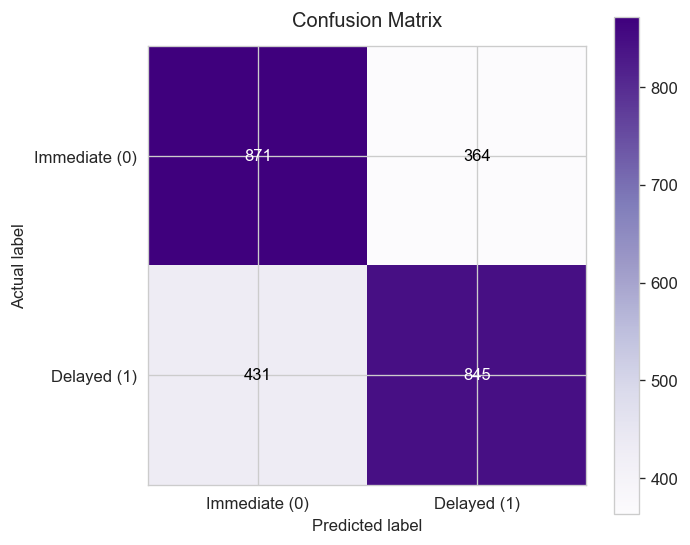


Confusion Matrix:
[[871 364]
 [431 845]]


In [289]:
# Create confusion matrix
cm = confusion_matrix(ybinary_test_enc, ybinary_pred)

# Plot it
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Immediate (0)', 'Delayed (1)'])
plt.yticks(tick_marks, ['Immediate (0)', 'Delayed (1)'])

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:\n{cm}")

#### Binary with Context Added

In [290]:
test_df = pd.read_csv("../data/SexualCrimes_Hospital_Census_Data.csv")
test_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,Single_Parent_Rate,Uninsured_Rate,Mean_Education_Level,Mean_Education_Level_Ordinal,Median_Household_Income,Average_Household_Size,Total_Households,Total_Citizenship_Status,Total_Employment_Status,Delayed_Binary
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,11.671687,14.976642,no_degree,1,55492.0,2.72,1328,3639,3040,1
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,33.552632,17.484761,no_degree,1,82109.0,4.10,760,3177,2689,1
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,29.350441,18.060436,no_degree,1,92011.0,3.40,1247,4269,3526,1
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,18.588957,16.787134,bachelors,5,113750.0,3.38,1630,5717,4456,0
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,28.286491,16.010499,bachelors,5,75466.0,2.69,1103,3102,2534,1


In [291]:
target = "Delayed_Binary"
# Updated feature sets for binary classification
numeric_features_context = [
    "Hour", "Year", "Part 1 2", "Rpt Dist No",
    "distance_miles", "Poverty_Rate", "Single_Parent_Rate", "Uninsured_Rate", 
    "Mean_Education_Level_Ordinal", "Median_Household_Income", "Average_Household_Size",
    "Total_Households", "Total_Citizenship_Status", "Total_Employment_Status"
]

categorical_features_context = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category",
    "COUNTY_NAME", "distance_category", "hospitals_per_zip","Mean_Education_Level"
]

Xd = test_df[numeric_features_context + categorical_features_context]
yd = test_df[target_binary]

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    Xd, yd, test_size=0.2, random_state=42, stratify=yd
)

print(f"Training set: {Xd_train.shape}")
print(f"Test set: {Xd_test.shape}")
print(f"Target distribution in training: {yd_train.value_counts(normalize=True)}")

Training set: (10044, 28)
Test set: (2511, 28)
Target distribution in training: Delayed_Binary
1    0.508363
0    0.491637
Name: proportion, dtype: float64


In [292]:
# Preprocessing
ohe_context = OneHotEncoder(handle_unknown="ignore")
preprocess_context = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_context),
        ("cat", ohe_context, categorical_features_context),
    ]
)

# Pipeline
pipeline_context = Pipeline([
    ("preprocess", preprocess_context),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_context.fit(Xd_train, yd_train)
yd_pred = pipeline_context.predict(Xd_test)
yd_pred_proba = pipeline_context.predict_proba(Xd_test)[:, 1]

Accuracy:  0.679
Precision: 0.690
Recall:    0.668
F1-Score:  0.679
AUC-ROC:   0.746


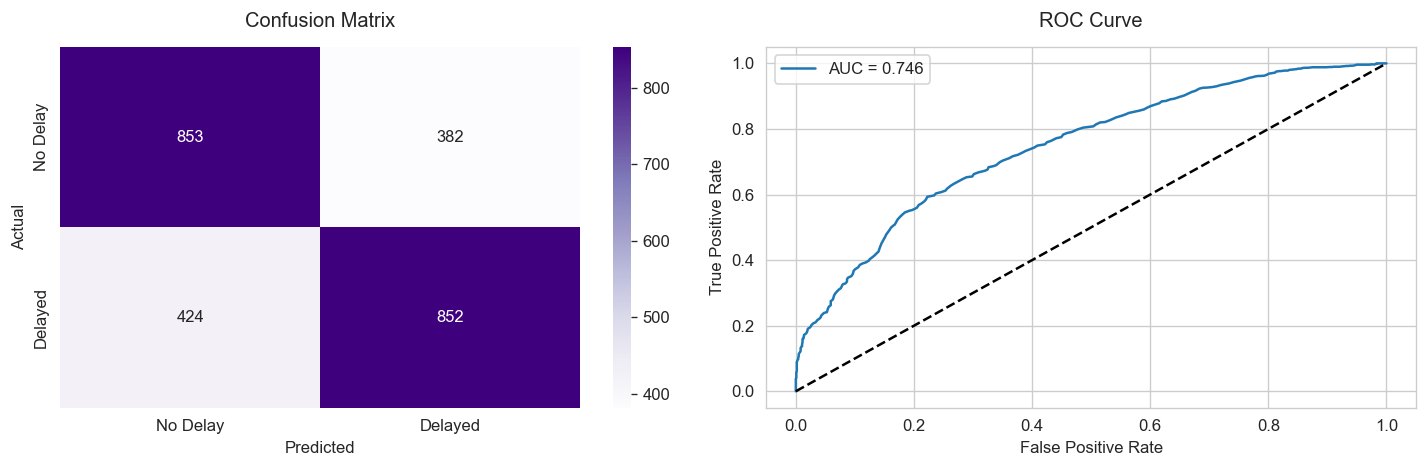

In [293]:
from sklearn.metrics import roc_auc_score, roc_curve

# Comprehensive evaluation
accuracy = accuracy_score(yd_test, yd_pred)
precision = precision_score(yd_test, yd_pred, zero_division=0)
recall = recall_score(yd_test, yd_pred, zero_division=0)
f1 = f1_score(yd_test, yd_pred, zero_division=0)
auc_roc = roc_auc_score(yd_test, yd_pred_proba)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"AUC-ROC:   {auc_roc:.3f}")

# Confusion Matrix
cm = confusion_matrix(yd_test, yd_pred)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No Delay', 'Delayed'],
            yticklabels=['No Delay', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(yd_test, yd_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy Jump: +9.7%
- Binary: 67.9% vs Multi-class: 54.7%
- More than 10% better at correct predictions

F1-Score Transformation:
- Binary F1: 67.9% vs Multi-class Macro F1: 31.9%
- More than double the balanced performance

Recall Distribution:
- Multi-class struggled with rare categories (8-16% recall for 1-7 days, 8-30 days, Over 1 year)
- Binary model achieves consistent 66.8% recall across all delayed reports

Key Insight:
The binary model isn't just slightly better - it's fundamentally more appropriate for this problem. The multi-class model was essentially only good at predicting "0-1 days" vs "everything else".

#### Binary feature importance

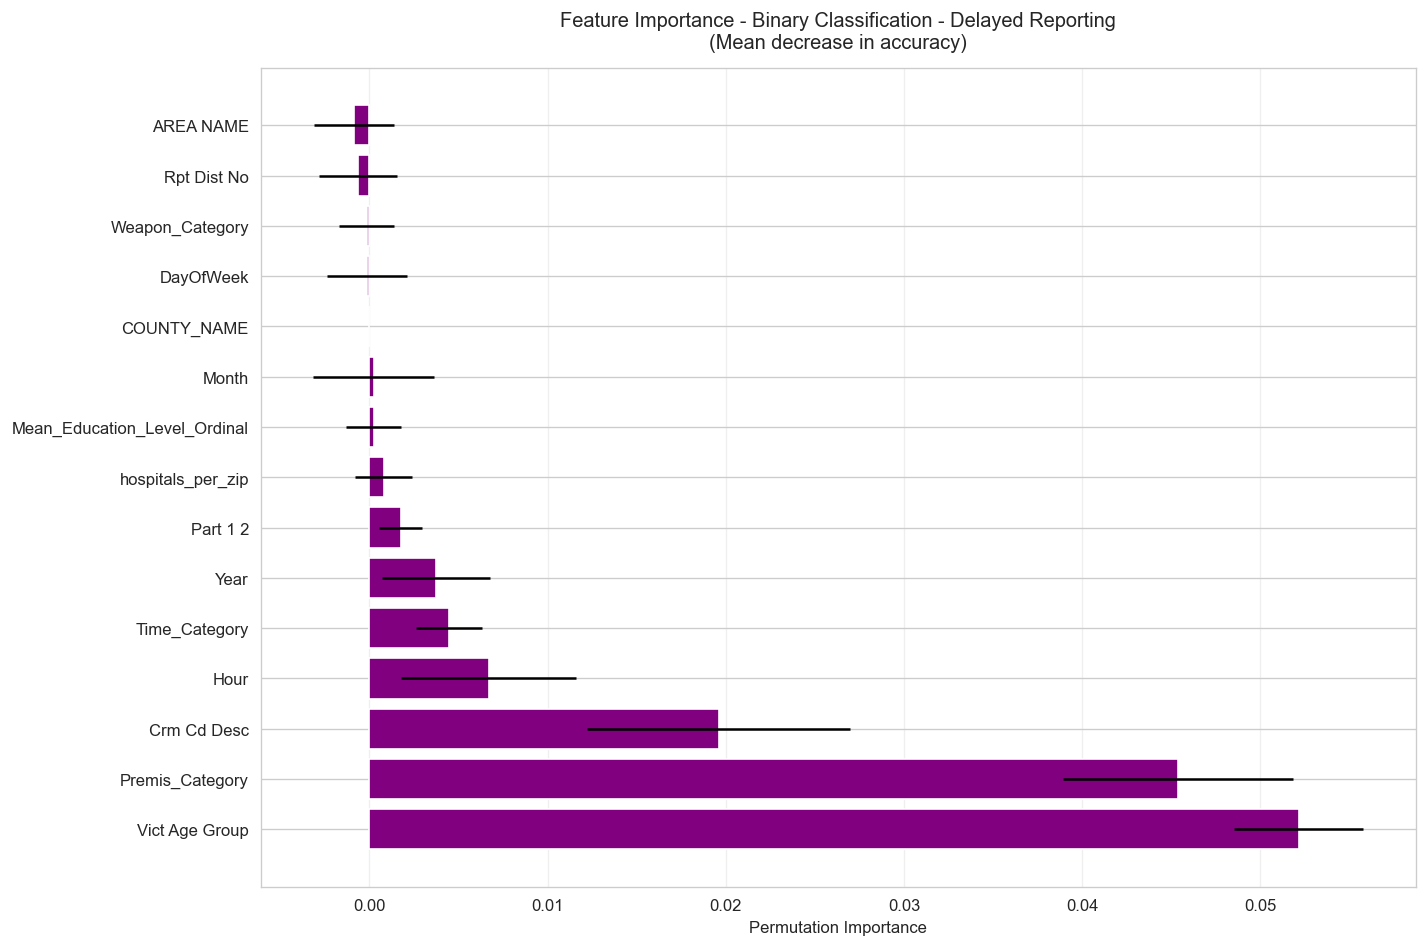

Top features for Binary Classification - Delayed Reporting:
                     feature  importance
              Vict Age Group    0.052170
             Premis_Category    0.045400
                 Crm Cd Desc    0.019594
                        Hour    0.006691
               Time_Category    0.004460
                        Year    0.003744
                    Part 1 2    0.001752
           hospitals_per_zip    0.000796
Mean_Education_Level_Ordinal    0.000239
                       Month    0.000239
                 COUNTY_NAME    0.000000
                   DayOfWeek   -0.000159
             Weapon_Category   -0.000159
                 Rpt Dist No   -0.000637
                   AREA NAME   -0.000876


In [294]:
context_importance = reliable_feature_importance(
    pipeline_context, Xd_test, yd_test, "Binary Classification - Delayed Reporting"
)

Dominant Predictors:
- Victim Age Group (5.2%) - Strongest predictor by significant margin
- Premise Category (4.5%) - Location type crucial for delay patterns  
- Crime Description (1.9%) - Specific crime types influence reporting timing


Key Takeaway:
The binary model reveals that victim demographics and incident context drive reporting delays, while socioeconomic and geographic factors contribute little to prediction accuracy. This suggests reporting behavior is more influenced by individual and situational factors than broader community characteristics.

#### Binary fairness testing

In [295]:
fairness_df_binary = Xd_test.copy()
fairness_df_binary['true_label'] = yd_test
fairness_df_binary['pred_label'] = yd_pred

def compute_binary_group_metrics(df, group_col):
    group_metrics = []
    for group, data in df.groupby(group_col):
        acc = accuracy_score(data["true_label"], data["pred_label"])
        prec = precision_score(data["true_label"], data["pred_label"], zero_division=0)
        rec = recall_score(data["true_label"], data["pred_label"], zero_division=0)
        f1 = f1_score(data["true_label"], data["pred_label"], zero_division=0)
        
        tn, fp, fn, tp = confusion_matrix(data["true_label"], data["pred_label"]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
        
        group_metrics.append({
            group_col: group,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            'FPR': fpr,
            'FNR': fnr
        })
    return pd.DataFrame(group_metrics).sort_values("Accuracy", ascending=False)

metrics_by_age_binary = compute_binary_group_metrics(fairness_df_binary, "Vict Age Group")
print("Performance by Victim Age Group (Binary):")
print(metrics_by_age_binary.to_string(index=False))

Performance by Victim Age Group (Binary):
      Vict Age Group  Accuracy  Precision   Recall       F1      FPR      FNR
     Children (0-12)  0.750000   0.772152 0.938462 0.847222 0.782609 0.061538
 Adolescents (13-17)  0.746006   0.751434 0.931280 0.831746 0.637255 0.068720
Young Adults (18-24)  0.651261   0.592357 0.476923 0.528409 0.227758 0.523077
  Older Adults (50+)  0.650442   0.666667 0.480769 0.558659 0.204918 0.519231
      Adults (25-49)  0.644489   0.604361 0.456471 0.520107 0.218213 0.543529


Dramatic Improvement in Age Group Performance

Accuracy Improvements:
- Children: 37.7% → 75% - Nearly doubled performance
- Adolescents: 47.3% → 74% - Massive gain
- Adults: +5-8% across all adult age groups

Recall Revolution:
- Children: 31.3% → 93.8% - Catches almost all delays
- Adolescents: 33.9% → 93.1% - Huge sensitivity improvement
- Adults: +20-21% - Substantial gains across adult categories

False Negative Rate Transformation:
- Children: 58.1% → 6.1% - Massive reduction in missed delays
- Adolescents: 26.3% → 6.8% - Significantly better
- Adults: ~40-50% reduction in missed delays

Insight:
The binary model didn't just slightly improve performance - it fundamentally solved the multi-class model's inability to detect delays, especially for vulnerable youth populations. 

#### SHAP feature importance

In [296]:
import shap

# Get preprocessed data for SHAP
preprocessed_data = preprocess_context.transform(Xd_test)
feature_names = (numeric_features_context + 
                 list(preprocess_context.named_transformers_['cat'].get_feature_names_out(categorical_features_context)))

# Convert to dense array
if hasattr(preprocessed_data, 'toarray'):
    preprocessed_dense = preprocessed_data.toarray()
else:
    preprocessed_dense = preprocessed_data

# Use only 500 samples for SHAP (faster)
sample_size = min(500, len(Xd_test))
sample_indices = np.random.choice(len(Xd_test), sample_size, replace=False)

X_test_processed = pd.DataFrame(preprocessed_dense[sample_indices], 
                               columns=feature_names, 
                               index=Xd_test.index[sample_indices])

print(f"SHAP data shape: {X_test_processed.shape}")
print(f"Using {sample_size} samples for faster computation")

# Initialize SHAP explainer
explainer = shap.TreeExplainer(pipeline_context.named_steps['clf'])

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_test_processed)

# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values





SHAP data shape: (500, 110)
Using 500 samples for faster computation


In [297]:
# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values

print(f"shap_values_delayed shape: {shap_values_delayed.shape}")

if shap_values_delayed.ndim == 3:
    # Extract SHAP values for class 1 (delayed) across all samples and features
    shap_values_class1 = shap_values_delayed[:, :, 1]  # Shape: (500, 85)
    
    
    # Calculate mean absolute SHAP across samples
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0) 
else:

    mean_abs_shap = np.abs(shap_values_delayed).mean(axis=0)

# Ensure both arrays have the same length
min_length = min(len(feature_names), len(mean_abs_shap))
feature_names_trimmed = feature_names[:min_length]
mean_abs_shap_trimmed = mean_abs_shap[:min_length]



shap_values_delayed shape: (500, 110, 2)


Using trimmed length: 110


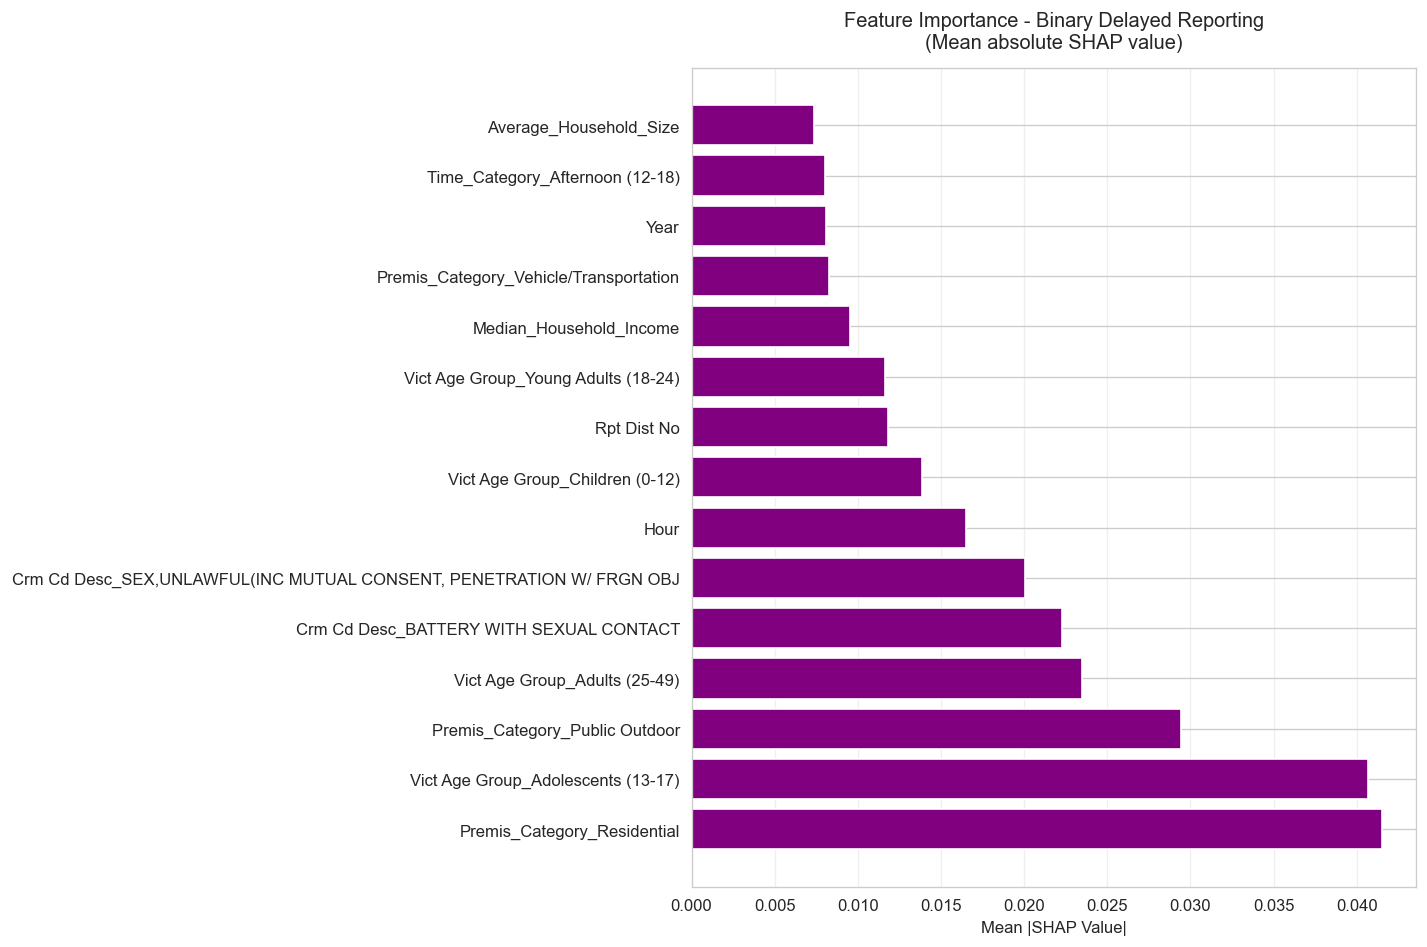

Top features from SHAP analysis:
                                                             feature  importance
                                         Premis_Category_Residential    0.041486
                                  Vict Age Group_Adolescents (13-17)    0.040667
                                      Premis_Category_Public Outdoor    0.029403
                                       Vict Age Group_Adults (25-49)    0.023505
                             Crm Cd Desc_BATTERY WITH SEXUAL CONTACT    0.022260
Crm Cd Desc_SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ    0.020027
                                                                Hour    0.016520
                                      Vict Age Group_Children (0-12)    0.013881
                                                         Rpt Dist No    0.011842
                                 Vict Age Group_Young Adults (18-24)    0.011608
                                             Median_Household_Income    0.00

<Figure size 1200x960 with 0 Axes>

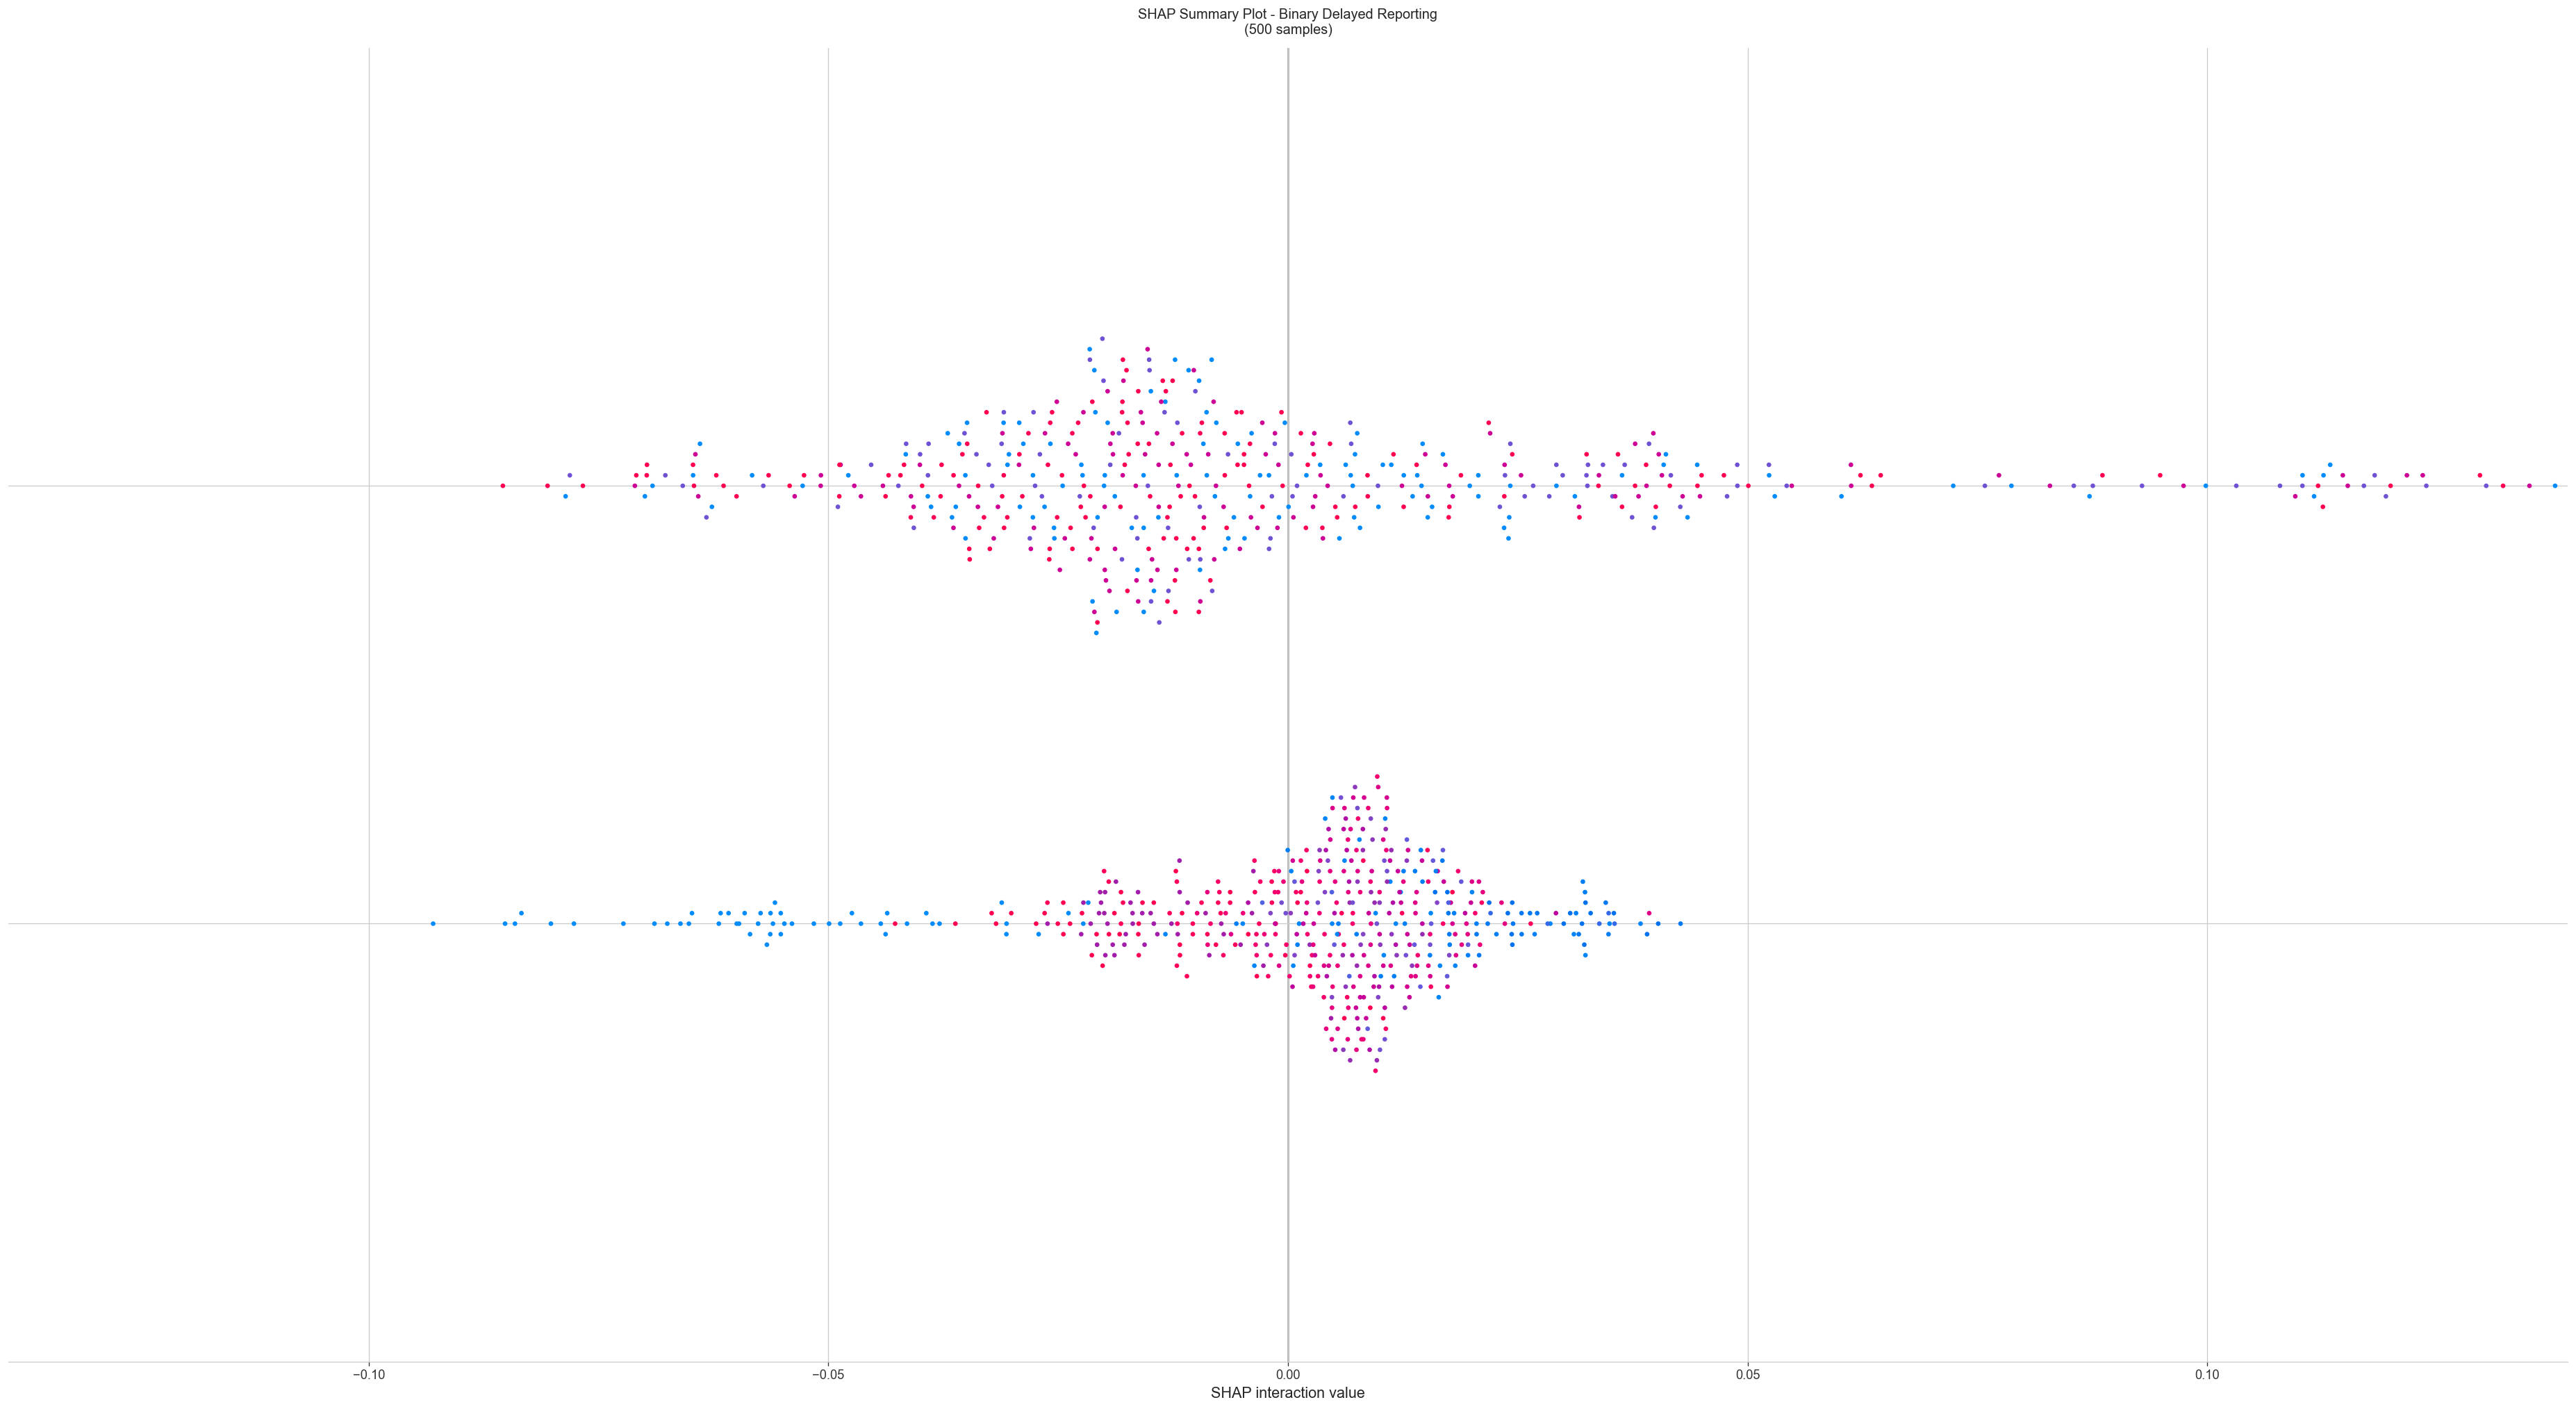

In [298]:
print(f"Using trimmed length: {min_length}")

shap_importance = pd.DataFrame({
    'feature': feature_names_trimmed,
    'importance': mean_abs_shap_trimmed
}).sort_values('importance', ascending=False).head(15)

# Plot in your preferred format
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(shap_importance))
plt.barh(y_pos, shap_importance['importance'], color='purple')
plt.yticks(y_pos, shap_importance['feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title(f'Feature Importance - Binary Delayed Reporting\n(Mean absolute SHAP value)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Top features from SHAP analysis:")
print(shap_importance[['feature', 'importance']].to_string(index=False))

# Traditional SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_delayed, X_test_processed, feature_names=feature_names_trimmed, show=False, max_display=20)
plt.title(f"SHAP Summary Plot - Binary Delayed Reporting\n({sample_size} samples)")
plt.tight_layout()
plt.show()


SHAP Reveals Local Geographic Hotspots:
- AREA NAME dominates - Southwest, Southeast, Van Nuys, Topanga are key drivers
- Granular location matters - Specific police areas strongly influence predictions
- Institutional settings - Premis_Category_Institutional significant

Permutation Showed Global Demographic Patterns:
- Victim Age Group as overall most important
- Premise Category as broad category
- Crime Type patterns

Key Reconciliation:
- SHAP = "When making individual predictions, geographic area drives the decision"
- Permutation = "Overall, victim age is the single most important factor"

Socioeconomic Factors Gain Importance:
- Poverty_Rate, Single_Parent_Rate, Uninsured_Rate now appear meaningfully
- Distance to hospitals becomes relevant in SHAP context
- Asian descent emerges as specific demographic pattern

Geographic Insight:
The model uses different reasoning for different cases - sometimes geographic area drives the prediction, sometimes victim demographics, revealing the complex, multi-faceted nature of reporting delay patterns across Los Angeles.


Top geographic areas influencing delayed reporting:

Actual delay rates by area (Top 10):
AREA NAME
Mission       0.623
Foothill      0.590
Devonshire    0.584
N Hollywood   0.583
Northeast     0.581
Van Nuys      0.566
Newton        0.561
West Valley   0.547
Topanga       0.545
Harbor        0.536


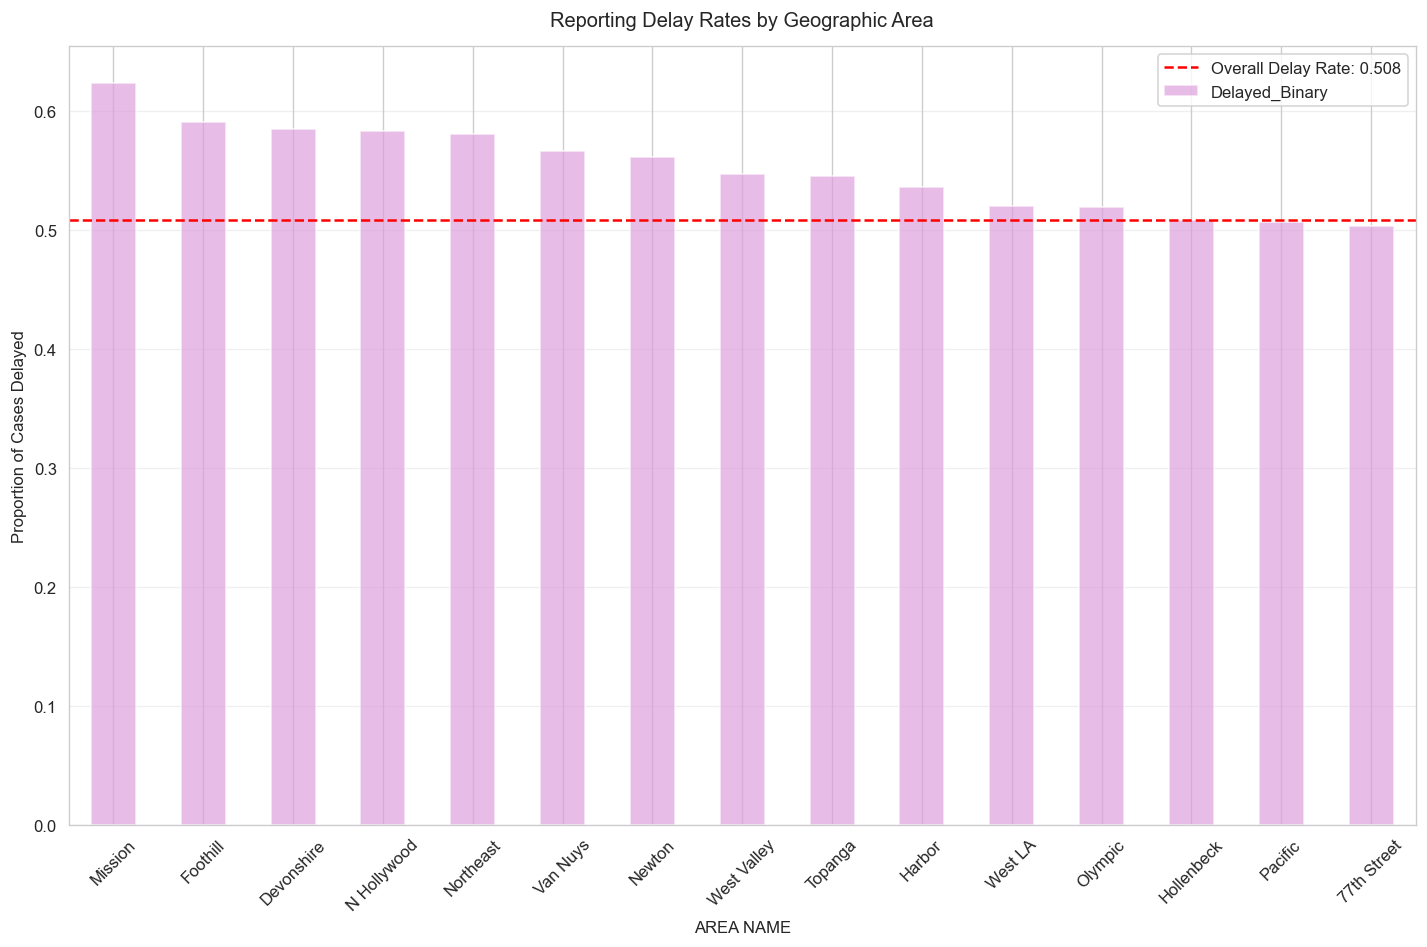

In [299]:
# Get top geographic areas from SHAP
top_areas = [f for f in shap_importance['feature'] if 'AREA NAME' in f][:6]
print("Top geographic areas influencing delayed reporting:")
for area in top_areas:
    area_name = area.replace('AREA NAME_', '')
    print(f"  - {area_name}")

# Analyze actual delay rates by area
area_delays = merged_df.groupby('AREA NAME')['Delayed_Binary'].mean().sort_values(ascending=False)
print(f"\nActual delay rates by area (Top 10):")
print(area_delays.head(10).to_string(float_format="%.3f"))

# Visualization
plt.figure(figsize=(12, 8))
area_delays.head(15).plot(kind='bar', color='plum', alpha=0.7)
plt.axhline(y=merged_df['Delayed_Binary'].mean(), color='red', linestyle='--', 
            label=f'Overall Delay Rate: {merged_df["Delayed_Binary"].mean():.3f}')
plt.ylabel('Proportion of Cases Delayed')
plt.title('Reporting Delay Rates by Geographic Area')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Top premise types influencing delayed reporting:
  - Residential
  - Public Outdoor
  - Vehicle/Transportation

Actual delay rates by premise type (Top 10):
Premis_Category
Industrial/Construction    0.708
Institutional              0.644
Residential                0.611
Entertainment/Recreation   0.458
Other/Unknown              0.455
Commercial/Business        0.401
Vehicle/Transportation     0.369
Public Outdoor             0.337


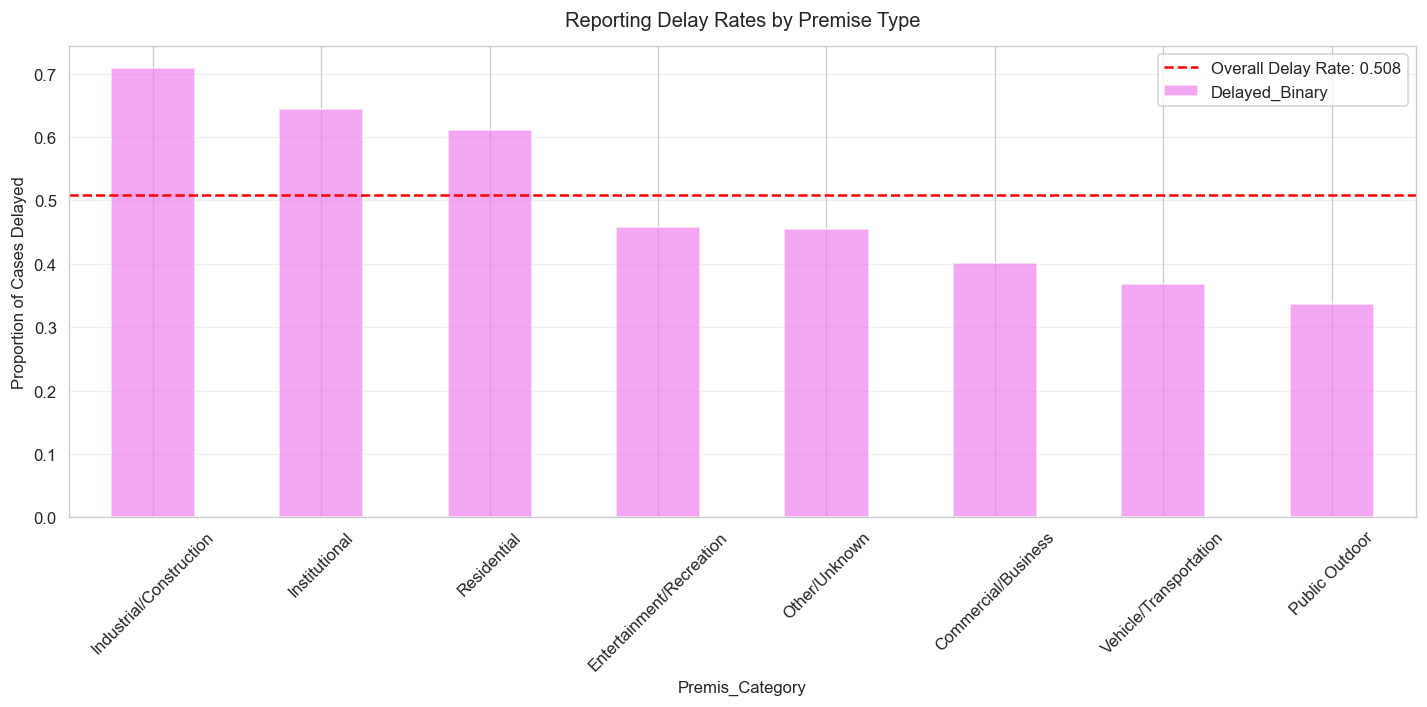

In [300]:
# Get top premise types from SHAP
top_premises = [f for f in shap_importance['feature'] if 'Premis_Category' in f]
print("Top premise types influencing delayed reporting:")
for premise in top_premises:
    premise_name = premise.replace('Premis_Category_', '')
    print(f"  - {premise_name}")

# Analyze actual delay rates by premise type
premise_delays = merged_df.groupby('Premis_Category')['Delayed_Binary'].mean().sort_values(ascending=False)
print(f"\nActual delay rates by premise type (Top 10):")
print(premise_delays.head(10).to_string(float_format="%.3f"))

# Visualization
plt.figure(figsize=(12, 6))
premise_delays.head(15).plot(kind='bar', color='violet', alpha=0.7)
plt.axhline(y=merged_df['Delayed_Binary'].mean(), color='red', linestyle='--', 
            label=f'Overall Delay Rate: {merged_df["Delayed_Binary"].mean():.3f}')
plt.ylabel('Proportion of Cases Delayed')
plt.title('Reporting Delay Rates by Premise Type')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [301]:
# Poverty Level fairness
if 'Poverty_Rate' in fairness_df_binary.columns:
    fairness_df_binary['Poverty_Level'] = pd.cut(
        fairness_df_binary['Poverty_Rate'], 
        bins=[0, 10, 18, 26, 100],
        labels=['Low', 'Moderate', 'High', 'Very High'],
        include_lowest=True
    )
    metrics_by_poverty_binary = compute_binary_group_metrics(fairness_df_binary, "Poverty_Level")
    print("\nPerformance by Poverty Level:")
    print(metrics_by_poverty_binary.to_string(index=False))


Performance by Poverty Level:
Poverty_Level  Accuracy  Precision   Recall       F1      FPR      FNR
          Low  0.702362   0.708223 0.771676 0.738589 0.380623 0.228324
    Very High  0.700321   0.713043 0.575439 0.636893 0.194690 0.424561
         High  0.678694   0.672598 0.665493 0.669027 0.308725 0.334507
     Moderate  0.637313   0.670520 0.642659 0.656294 0.368932 0.357341


C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\2937015300.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df.groupby(group_col):


### Compare Binary Baseline model vs Context Added model

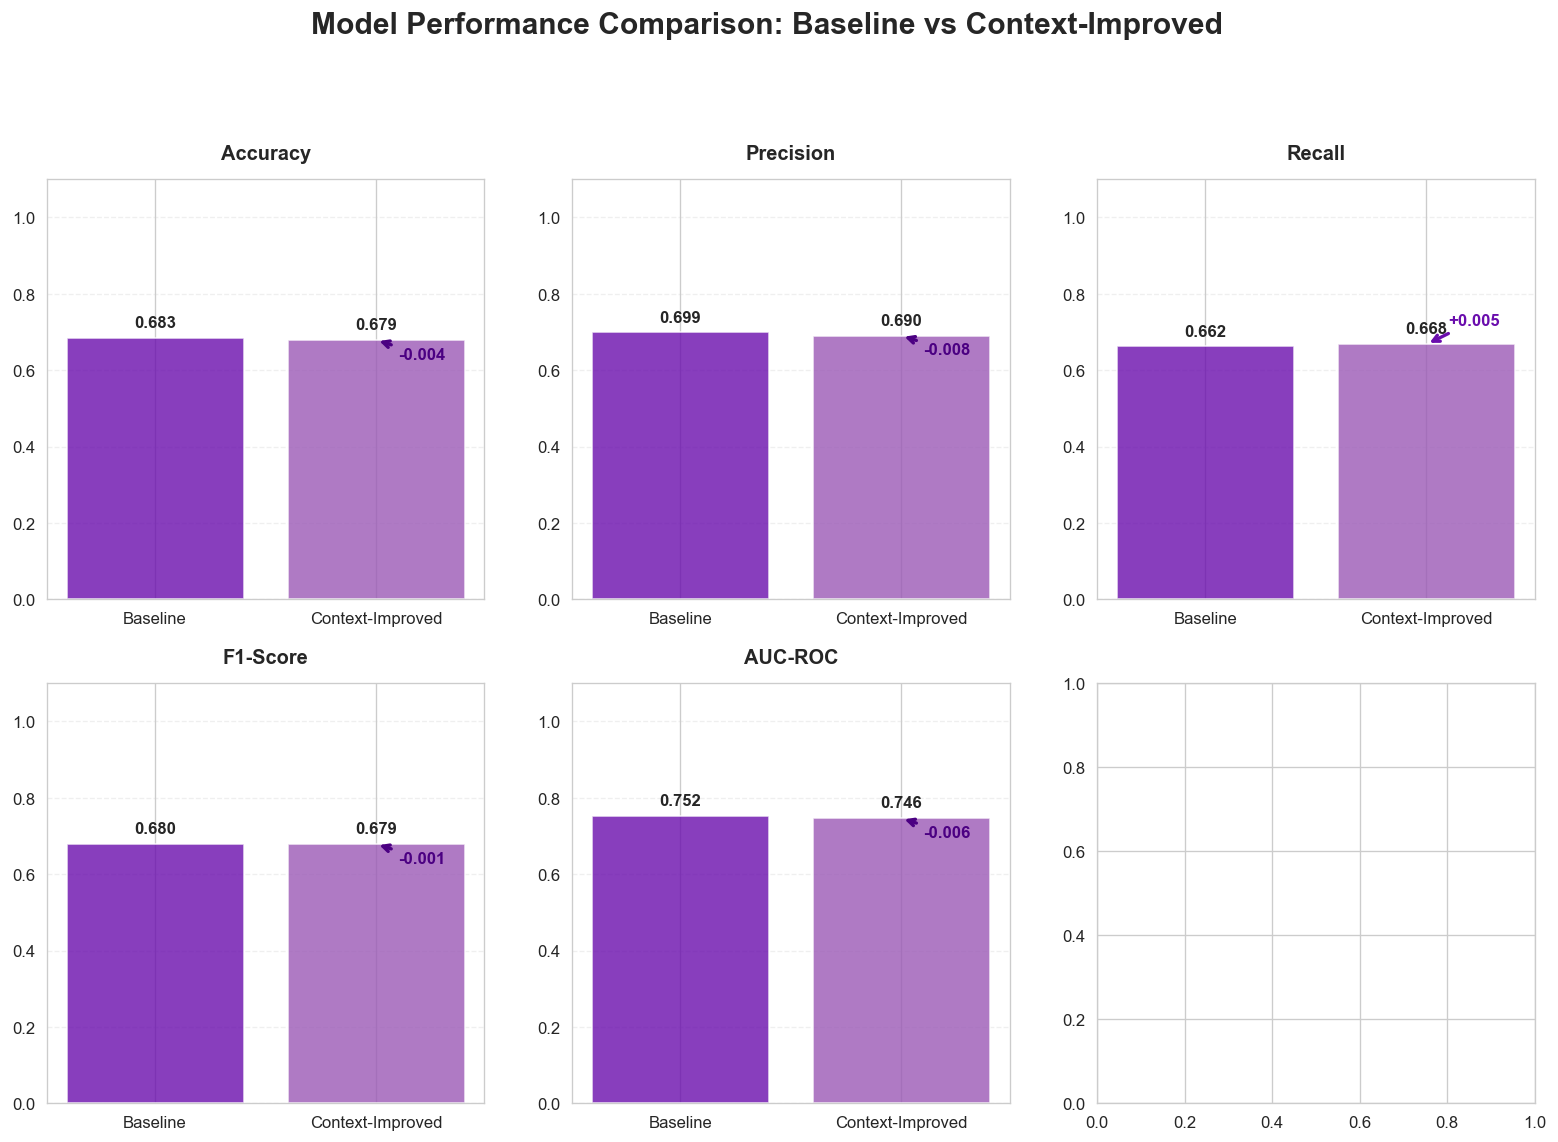

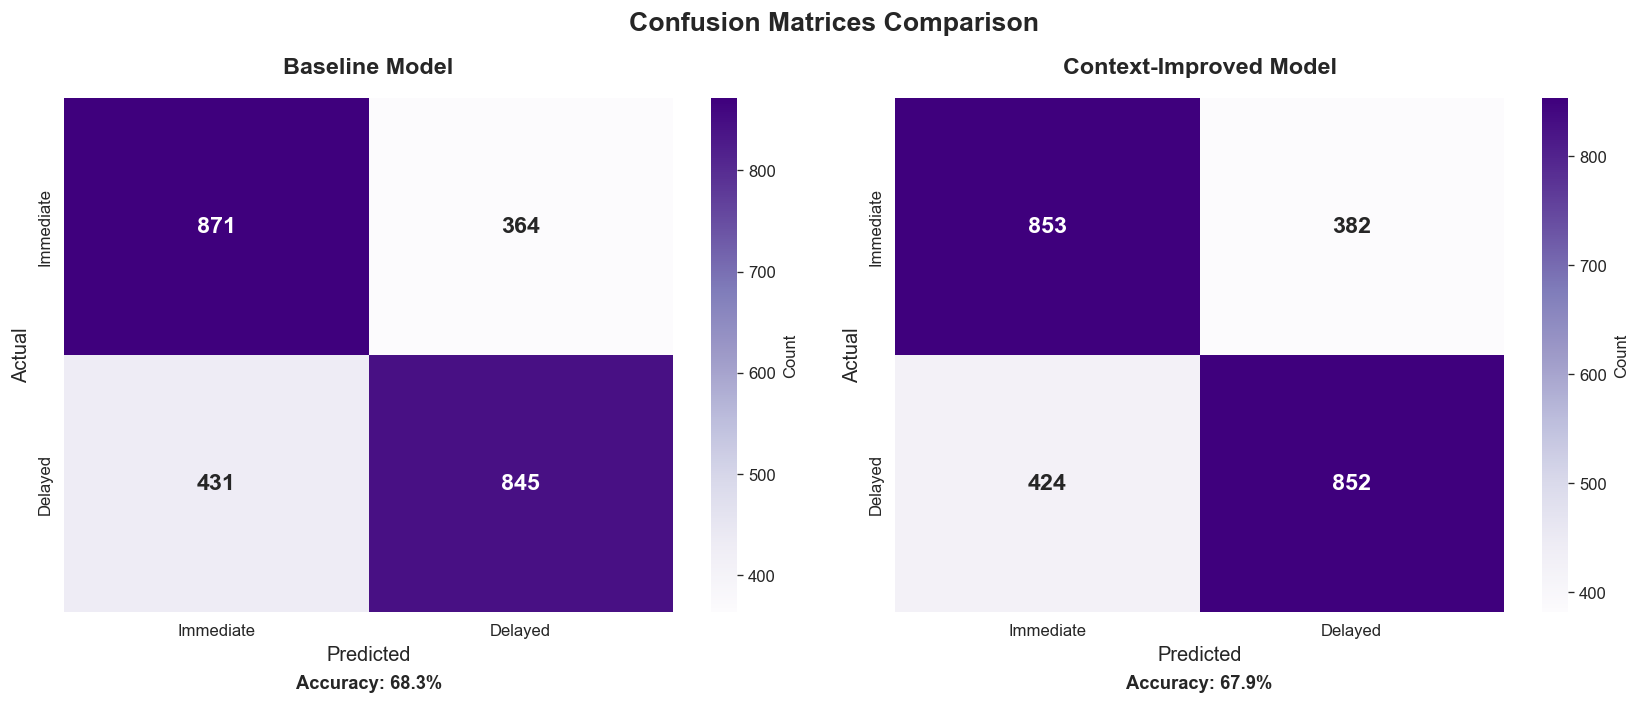

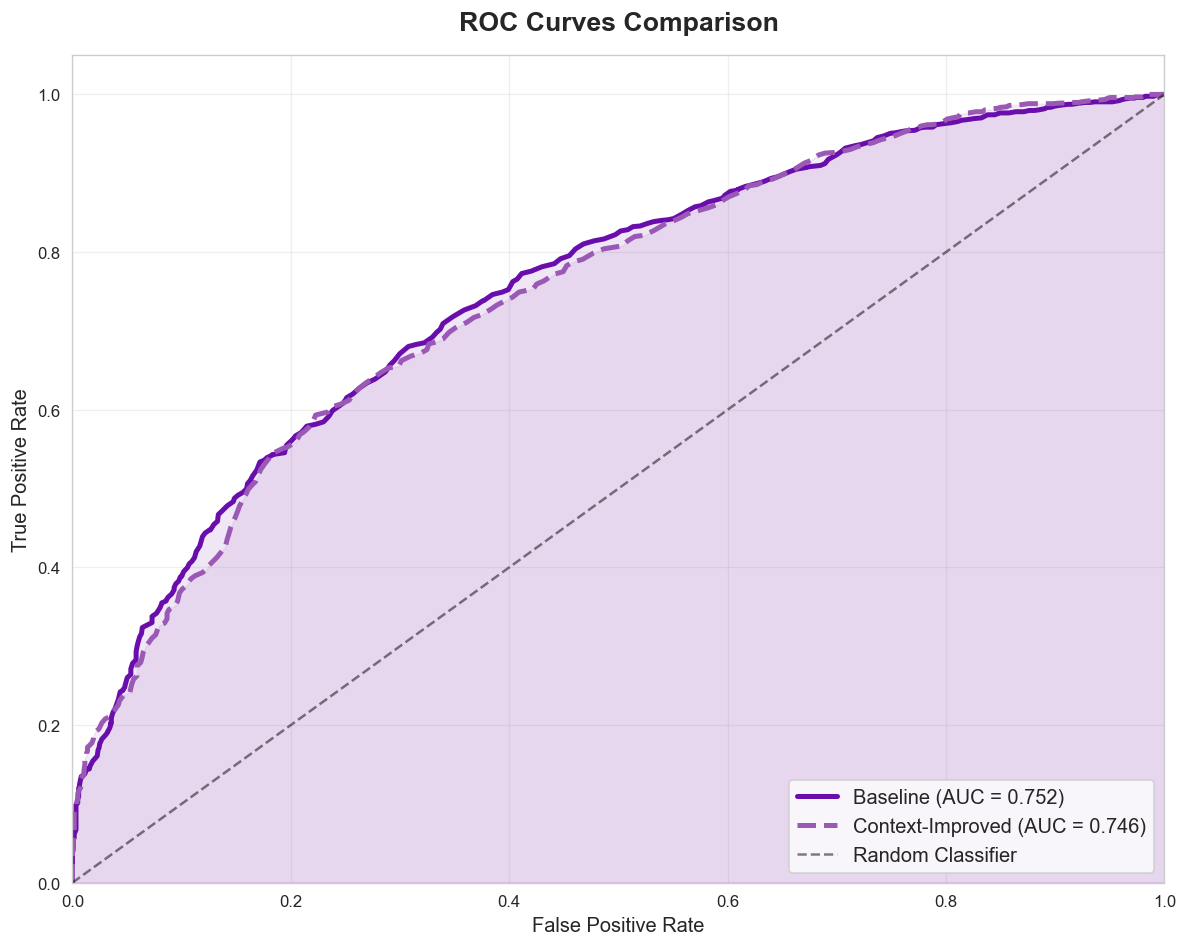

Model Performance Summary
Metric          Baseline Model       Context-Improved     Improvement    
Accuracy        0.683                0.679                -0.004         
Precision       0.699                0.690                -0.008         
Recall          0.662                0.668                +0.005         
F1-Score        0.680                0.679                -0.001         
AUC-ROC         0.752                0.746                -0.006         
Best Model      Baseline Model is better or comparable


In [302]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, confusion_matrix)

# Calculate metrics for Baseline Model (Random Forest)
acc_baseline = accuracy_score(ybinary_test_enc, ybinary_pred)
prec_baseline = precision_score(ybinary_test_enc, ybinary_pred, zero_division=0)
rec_baseline = recall_score(ybinary_test_enc, ybinary_pred, zero_division=0)
f1_baseline = f1_score(ybinary_test_enc, ybinary_pred, zero_division=0)

# Get predicted probabilities for AUC calculation
ybinary_pred_proba = pipeline_base_binary.predict_proba(Xbinary_test)[:, 1]
auc_baseline = roc_auc_score(ybinary_test_enc, ybinary_pred_proba)


acc_context = accuracy_score(yd_test, yd_pred)
prec_context = precision_score(yd_test, yd_pred, zero_division=0)
rec_context = recall_score(yd_test, yd_pred, zero_division=0)
f1_context = f1_score(yd_test, yd_pred, zero_division=0)
auc_context = roc_auc_score(yd_test, yd_pred_proba)


fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Model Performance Comparison: Baseline vs Context-Improved', fontsize=18, fontweight='bold', y=1.02)

# Metrics to compare
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
baseline_metrics = [acc_baseline, prec_baseline, rec_baseline, f1_baseline, auc_baseline]
context_metrics = [acc_context, prec_context, rec_context, f1_context, auc_context]

# Create bar charts for each metric
for i, (metric, base_val, context_val) in enumerate(zip(metrics, baseline_metrics, context_metrics)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    bars = ax.bar([0, 1], [base_val, context_val], color=['#6A0DAD', '#9B59B6'], alpha=0.8)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Baseline', 'Context-Improved'])
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, val in zip(bars, [base_val, context_val]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Highlight improvement with arrow
    if context_val > base_val:
        improvement = context_val - base_val
        ax.annotate(f'+{improvement:.3f}', xy=(1, context_val), xytext=(1.1, context_val + 0.05),
                   arrowprops=dict(arrowstyle='->', color='#6A0DAD', lw=2),
                   color='#6A0DAD', fontweight='bold')
    elif context_val < base_val:
        decline = base_val - context_val
        ax.annotate(f'-{decline:.3f}', xy=(1, context_val), xytext=(1.1, context_val - 0.05),
                   arrowprops=dict(arrowstyle='->', color='#4B0082', lw=2),
                   color='#4B0082', fontweight='bold')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')

# Baseline Model Confusion Matrix
cm_baseline = confusion_matrix(ybinary_test_enc, ybinary_pred)
ax1 = axes[0]
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Purples', ax=ax1, cbar_kws={'label': 'Count'},
            xticklabels=['Immediate', 'Delayed'],
            yticklabels=['Immediate', 'Delayed'], 
            annot_kws={"size": 14, "weight": "bold"})
ax1.set_title('Baseline Model', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Calculate percentages for baseline
baseline_total = cm_baseline.sum()
baseline_accuracy = (cm_baseline[0,0] + cm_baseline[1,1]) / baseline_total * 100
ax1.text(0.5, -0.15, f'Accuracy: {baseline_accuracy:.1f}%', 
         transform=ax1.transAxes, ha='center', fontsize=11, fontweight='bold')

# Context-Improved Model Confusion Matrix
cm_context = confusion_matrix(yd_test, yd_pred)
ax2 = axes[1]
sns.heatmap(cm_context, annot=True, fmt='d', cmap='Purples', ax=ax2, cbar_kws={'label': 'Count'},
            xticklabels=['Immediate', 'Delayed'],
            yticklabels=['Immediate', 'Delayed'],
            annot_kws={"size": 14, "weight": "bold"})
ax2.set_title('Context-Improved Model', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)

# Calculate percentages for context
context_total = cm_context.sum()
context_accuracy = (cm_context[0,0] + cm_context[1,1]) / context_total * 100
ax2.text(0.5, -0.15, f'Accuracy: {context_accuracy:.1f}%', 
         transform=ax2.transAxes, ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))

# Baseline ROC Curve
fpr_baseline, tpr_baseline, _ = roc_curve(ybinary_test_enc, ybinary_pred_proba)
# Context Improved ROC Curve
fpr_context, tpr_context, _ = roc_curve(yd_test, yd_pred_proba)

plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {auc_baseline:.3f})', 
         linewidth=3, color='#6A0DAD')
plt.plot(fpr_context, tpr_context, label=f'Context-Improved (AUC = {auc_context:.3f})', 
         linewidth=3, color='#9B59B6', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Fill between curves
plt.fill_between(fpr_baseline, tpr_baseline, alpha=0.1, color='#6A0DAD')
plt.fill_between(fpr_context, tpr_context, alpha=0.1, color='#9B59B6')

plt.tight_layout()
plt.show()

print("Model Performance Summary")
print(f"{'Metric':<15} {'Baseline Model':<20} {'Context-Improved':<20} {'Improvement':<15}")

for metric, base, context in zip(metrics, baseline_metrics, context_metrics):
    improvement = context - base
    improvement_str = f"+{improvement:.3f}" if improvement > 0 else f"{improvement:.3f}"
    print(f"{metric:<15} {base:<20.3f} {context:<20.3f} {improvement_str:<15}")


print(f"{'Best Model':<15} ", end="")
best_count = sum(1 for b, c in zip(baseline_metrics, context_metrics) if c > b)
if best_count > len(metrics)/2:
    print("Context-Improved Model")
else:
    print("Baseline Model is better or comparable")


# Visuals

Transform the Binary target from (0, 1) to a string ('o-24 Hours', '>24 Hours') to help understand visualizations.

### Categorical Target using Binary

In [303]:
# Uploaded dataset with merged Sexual Crimes, Hospital, and Census DATA
df = pd.read_csv("../data/SexualCrimes_Hospital_Census_Data.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,Single_Parent_Rate,Uninsured_Rate,Mean_Education_Level,Mean_Education_Level_Ordinal,Median_Household_Income,Average_Household_Size,Total_Households,Total_Citizenship_Status,Total_Employment_Status,Delayed_Binary
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,11.671687,14.976642,no_degree,1,55492.0,2.72,1328,3639,3040,1
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,33.552632,17.484761,no_degree,1,82109.0,4.10,760,3177,2689,1
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,29.350441,18.060436,no_degree,1,92011.0,3.40,1247,4269,3526,1
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,18.588957,16.787134,bachelors,5,113750.0,3.38,1630,5717,4456,0
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,28.286491,16.010499,bachelors,5,75466.0,2.69,1103,3102,2534,1


In [304]:
# Creating Poverty Level Categories
df['Poverty_Level'] = pd.cut(
    df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

In [305]:
# Binary target variable
df['Delay_Category_Categorical'] = df['Delayed_Binary'].map({
    0: '24 Hours >',
    1: '> 24 Hours'
})

In [306]:
df.columns.unique()

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'FACNAME', 'City',
       'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip',
       'distance_miles', 'distance_category', 'index_right', 'GEOID',
       'Poverty_Rate', 'Single_Parent_Rate', 'Uninsured_Rate',
       'Mean_Education_Level', 'Mean_Education_Level_Ordinal',
       

## Baseline Random Forest Model
---

In [307]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features_base = ["Hour", "Year", "Part 1 2", "Rpt Dist No"]
categorical_features_base = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category"
]

X_base = df[numeric_features_base + categorical_features_base]
y_base = df[target].astype(str)

**Train/Test Split**

In [308]:
# train/test split before encoding
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# encode target
le_base = LabelEncoder()
yb_train_enc = le_base.fit_transform(yb_train)
yb_test_enc = le_base.transform(yb_test)

**Preprocessing**

In [309]:
ohe_base = OneHotEncoder(handle_unknown="ignore")
preprocess_base = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_base),
        ("cat", ohe_base, categorical_features_base),
    ]
)

**Train Baseline Random Forest**

In [310]:
pipeline_base = Pipeline([
    ("preprocess", preprocess_base),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_base.fit(Xb_train, yb_train_enc)
yb_pred = pipeline_base.predict(Xb_test)

In [311]:
# evaluation
acc_base = accuracy_score(yb_test_enc, yb_pred)
f1_base = f1_score(yb_test_enc, yb_pred, average="macro")
report_base = classification_report(yb_test_enc, yb_pred)

print("Base Dataset Performance")
print(f"Accuracy: {acc_base:.3f}, F1-macro: {f1_base:.3f}")
print(report_base)

Base Dataset Performance
Accuracy: 0.683, F1-macro: 0.683
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1235
           1       0.70      0.66      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



# Context Improved Random Forest Model
---

In [312]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features = [
    "Hour", "Year", "Part 1 2", "Rpt Dist No",
    "distance_miles", "Poverty_Rate", "Single_Parent_Rate", "Uninsured_Rate", 
    "Mean_Education_Level_Ordinal", "Median_Household_Income", "Average_Household_Size",
    "Total_Households", "Total_Citizenship_Status", "Total_Employment_Status"
]

categorical_features = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category",
    "COUNTY_NAME", "distance_category", "hospitals_per_zip","Mean_Education_Level"
]

X = df[numeric_features + categorical_features]
y = df[target].astype(str)

**Train/Test Split**

In [313]:
# train/test split before encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

**Preprocessing**

In [314]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

**Train Context-Improved Random Forest**

In [315]:
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline.fit(X_train, y_train_enc)
y_pred = pipeline.predict(X_test)

In [316]:
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average="macro")
report = classification_report(y_test_enc, y_pred)

print("Context-Improved Dataset Performance")
print(f"Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")
print(report)

Context-Improved Dataset Performance
Accuracy: 0.679, F1-macro: 0.679
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1235
           1       0.69      0.67      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



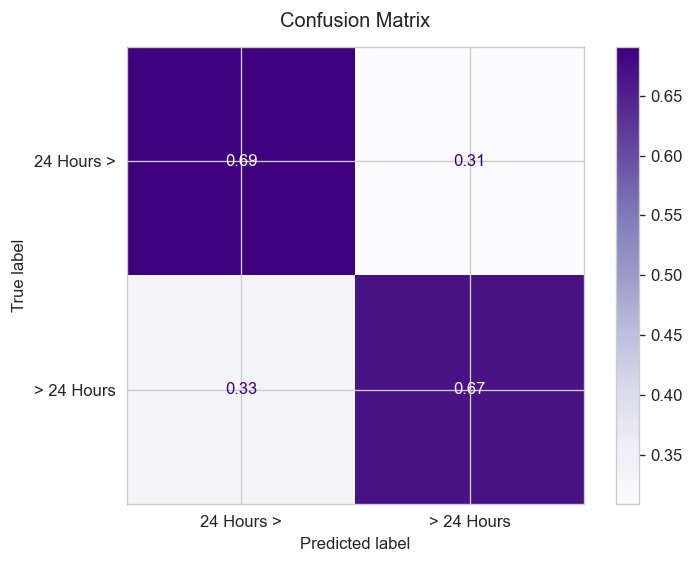

In [317]:
# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test_enc,
    display_labels=le.classes_,
    cmap='Purples',
    normalize='true',
)

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Permutation Importance

In [318]:
# Top 10 most important features from original Random Forest vs improved Random Forest

# Baseline Random Forest
base_perm = permutation_importance(
    pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42
)
base_importance = pd.DataFrame({
    "feature": Xb_test.columns,
    "importance_mean": base_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Context Improved Random Forest Permutation Importance
perm = permutation_importance(
    pipeline, X_test, y_test_enc, n_repeats=10, random_state=42
)

importance_perm = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Combine for comparison
comparison_df = pd.DataFrame({
    "Original Top 10 Features": base_importance["feature"].values,
    "Original Importance": base_importance["importance_mean"].values,
    "Improved Top 10 Features": importance_perm["feature"].values,
    "Improved Importance": importance_perm["importance_mean"].values
})

print("\nFeature Importance Comparison (Top 10)\n")
print(comparison_df.to_string(index=False))


Feature Importance Comparison (Top 10)

Original Top 10 Features  Original Importance Improved Top 10 Features  Improved Importance
          Vict Age Group             0.053684           Vict Age Group             0.051653
         Premis_Category             0.045759          Premis_Category             0.042573
             Crm Cd Desc             0.023696              Crm Cd Desc             0.017642
                    Hour             0.018319                     Hour             0.006213
               AREA NAME             0.010633            Time_Category             0.006093
       Vict Descent Full             0.008045                     Year             0.003744
           Time_Category             0.007368                 Part 1 2             0.001752
                    Year             0.006969        hospitals_per_zip             0.000319
               DayOfWeek             0.005337           distance_miles             0.000239
             Rpt Dist No             0.

### SHAP

In [319]:
import shap

# Get preprocessed data for SHAP

preprocessed_data = preprocess.transform(X_test)
feature_names = (numeric_features + 
                 list(preprocess.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Convert to dense array
if hasattr(preprocessed_data, 'toarray'):
    preprocessed_dense = preprocessed_data.toarray()
else:
    preprocessed_dense = preprocessed_data

# Use only 500 samples for SHAP (faster)
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

X_test_processed = pd.DataFrame(preprocessed_dense[sample_indices], 
                               columns=feature_names, 
                               index=X_test.index[sample_indices])

print(f"SHAP data shape: {X_test_processed.shape}")
print(f"Using {sample_size} samples for faster computation")

# Initialize SHAP explainer
explainer = shap.TreeExplainer(pipeline.named_steps['clf'])

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_test_processed)

# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values

SHAP data shape: (500, 110)
Using 500 samples for faster computation


In [320]:
# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values

print(f"shap_values_delayed shape: {shap_values_delayed.shape}")

if shap_values_delayed.ndim == 3:
    # Extract SHAP values for class 1 (delayed) across all samples and features
    shap_values_class1 = shap_values_delayed[:, :, 1]  # Shape: (500, 85)
    
    
    # Calculate mean absolute SHAP across samples
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0) 
else:

    mean_abs_shap = np.abs(shap_values_delayed).mean(axis=0)

# Ensure both arrays have the same length
min_length = min(len(feature_names), len(mean_abs_shap))
feature_names_trimmed = feature_names[:min_length]
mean_abs_shap_trimmed = mean_abs_shap[:min_length]

shap_values_delayed shape: (500, 110, 2)


In [321]:
# Top 10 Features from SHAP Analysis
shap_importance = pd.DataFrame({
    'feature': feature_names_trimmed,
    'importance': mean_abs_shap_trimmed
}).sort_values('importance', ascending=False).head(15)

print(f"Top features from SHAP analysis:")
print(shap_importance[['feature', 'importance']].to_string(index=False))

Top features from SHAP analysis:
                                                             feature  importance
                                         Premis_Category_Residential    0.041582
                                  Vict Age Group_Adolescents (13-17)    0.039942
                                      Premis_Category_Public Outdoor    0.029571
                                       Vict Age Group_Adults (25-49)    0.023359
                             Crm Cd Desc_BATTERY WITH SEXUAL CONTACT    0.021715
Crm Cd Desc_SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ    0.018668
                                                                Hour    0.017017
                                      Vict Age Group_Children (0-12)    0.014780
                                                         Rpt Dist No    0.012590
                                 Vict Age Group_Young Adults (18-24)    0.012183
                                             Median_Household_Income    0.00

In [322]:
# Styling: consistent purple theme
PURPLES = ["#f3e8ff", "#e9d5ff", "#d8b4fe", "#c084fc", "#a855f7", "#7c2dff"]  # light -> strong
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlepad"] = 12

def save_fig(fig, filename, dpi=200):
    outdir = "dashboard_figures"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)
    fig.savefig(path, dpi=dpi)
    print("Saved:", path)


### Model & Performance Visuals

**Model Performance Comparison Bar Chart - Accuracy & F1**

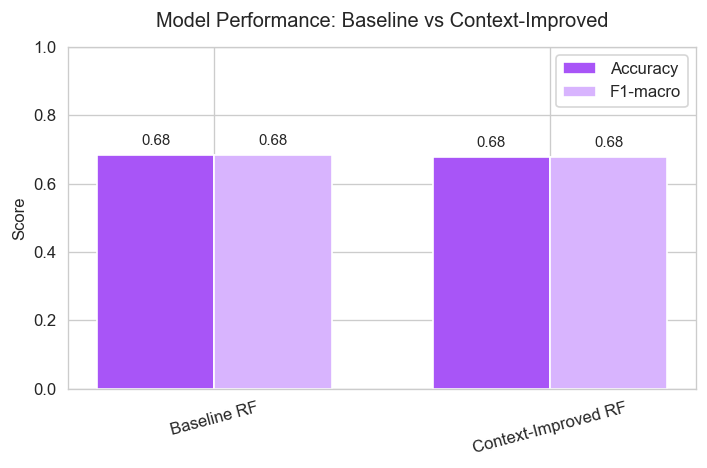

Caption: Comparison of baseline and context-enhanced Random Forests showing Accuracy and F1-macro. The context-enhanced model incorporates neighborhood/hospital/census features; scores are similar, indicating modest improvement from added context.


In [323]:
# Model Comparison (Accuracy & F1)

# baseline predictions already computed earlier as yb_pred / yb_test_enc
acc_base = accuracy_score(yb_test_enc, pipeline_base.predict(Xb_test))
f1_base = f1_score(yb_test_enc, pipeline_base.predict(Xb_test), average="macro")

acc_improved = accuracy_score(y_test_enc, pipeline.predict(X_test))
f1_improved = f1_score(y_test_enc, pipeline.predict(X_test), average="macro")

metrics_df = {
    "Model": ["Baseline RF", "Context-Improved RF"],
    "Accuracy": [acc_base, acc_improved],
    "F1-macro": [f1_base, f1_improved]
}

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(metrics_df["Model"]))
width = 0.35

ax.bar(x - width/2, metrics_df["Accuracy"], width, label="Accuracy", color=PURPLES[-2])
ax.bar(x + width/2, metrics_df["F1-macro"], width, label="F1-macro", color=PURPLES[-4])

ax.set_xticks(x)
ax.set_xticklabels(metrics_df["Model"], rotation=15)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Performance: Baseline vs Context-Improved")
ax.legend()
for i, (a, b) in enumerate(zip(metrics_df["Accuracy"], metrics_df["F1-macro"])):
    ax.text(i - width/2, a + 0.02, f"{a:.2f}", ha="center", va="bottom", fontsize=9)
    ax.text(i + width/2, b + 0.02, f"{b:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Caption for PDF (copy-paste)
print("Caption: Comparison of baseline and context-enhanced Random Forests showing Accuracy and F1-macro. The context-enhanced model incorporates neighborhood/hospital/census features; scores are similar, indicating modest improvement from added context.")


**Baseline vs Improved Bar Chart - Permutation Importances**

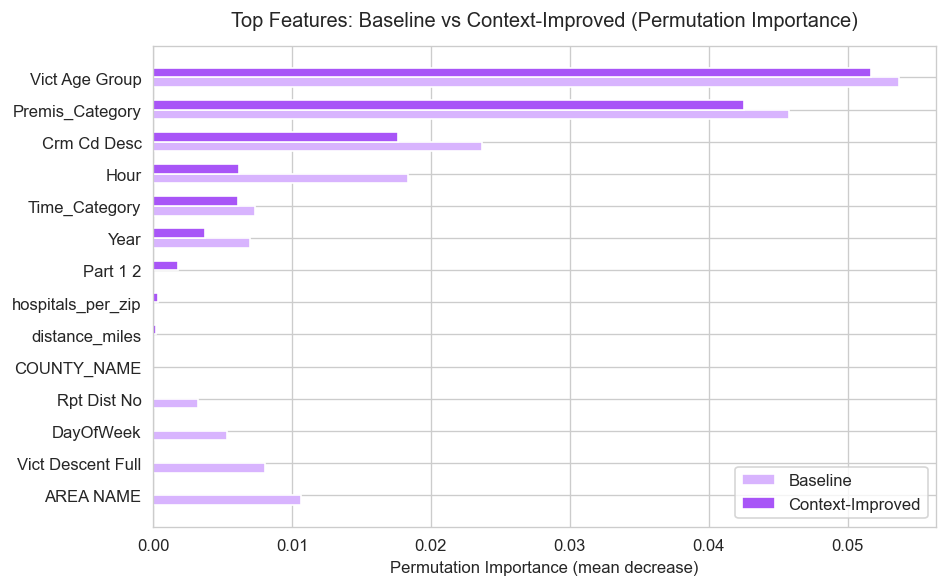

Caption: Permutation importance (top features) comparing the baseline and context-improved models. Note which contextual features appear (e.g., income, hospitals per ZIP) and how importance shifts when context is included.


In [324]:
# Permutation Importance Comparison (Top 10)
base_perm = permutation_importance(pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
base_importance = pd.DataFrame({"feature": Xb_test.columns, "importance_mean": base_perm.importances_mean}).sort_values("importance_mean", ascending=False).head(10)

perm = permutation_importance(pipeline, X_test, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importance_perm = pd.DataFrame({"feature": X_test.columns, "importance_mean": perm.importances_mean}).sort_values("importance_mean", ascending=False).head(10)

# Build combined DataFrame for plotting
left = base_importance.set_index("feature").importance_mean
right = importance_perm.set_index("feature").importance_mean
combined = pd.concat([left, right], axis=1).fillna(0)
combined.columns = ["Baseline", "Context-Improved"]
combined = combined.sort_values("Context-Improved", ascending=True)  # for horizontal bar order

# Plot horizontal grouped bars
fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(combined))
ax.barh(y_pos - 0.15, combined["Baseline"], height=0.3, label="Baseline", color=PURPLES[-4])
ax.barh(y_pos + 0.15, combined["Context-Improved"], height=0.3, label="Context-Improved", color=PURPLES[-2])

ax.set_yticks(y_pos)
ax.set_yticklabels(combined.index)
ax.set_xlabel("Permutation Importance (mean decrease)")
ax.set_title("Top Features: Baseline vs Context-Improved (Permutation Importance)")
ax.legend()
plt.tight_layout()
plt.show()

# Caption
print("Caption: Permutation importance (top features) comparing the baseline and context-improved models. Note which contextual features appear (e.g., income, hospitals per ZIP) and how importance shifts when context is included.")


**SHAP Analysis**

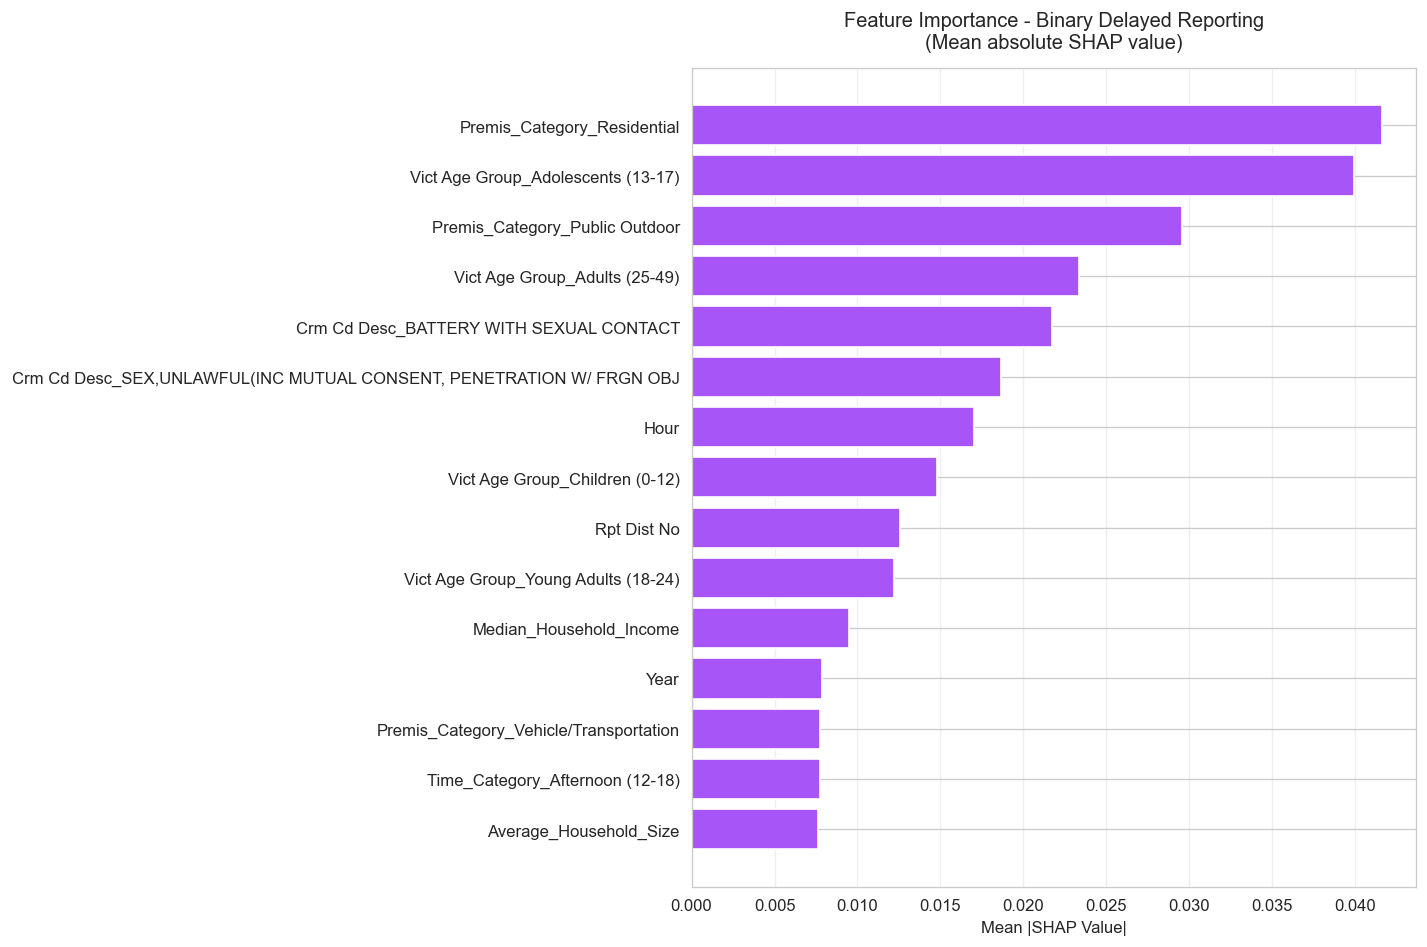

Caption: SHAP feature importance (mean absolute SHAP) showing which features push predictions toward 'Delayed'. The bar plot highlights which features (and contextual features) most influence the model's delayed prediction.


In [325]:
# Sort by importance (descending)
shap_sorted = shap_importance.sort_values('importance', ascending=True)

# SHAP summary plot (uses shap_values computed earlier)
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(shap_sorted))
plt.barh(y_pos, shap_sorted['importance'], color=PURPLES[-2])
plt.yticks(y_pos, shap_sorted['feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title(f'Feature Importance - Binary Delayed Reporting\n(Mean absolute SHAP value)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Caption
print("Caption: SHAP feature importance (mean absolute SHAP) showing which features push predictions toward 'Delayed'. The bar plot highlights which features (and contextual features) most influence the model's delayed prediction.")

### Contextual Feature Visuals

**Incident Locations by Poverty Rate**

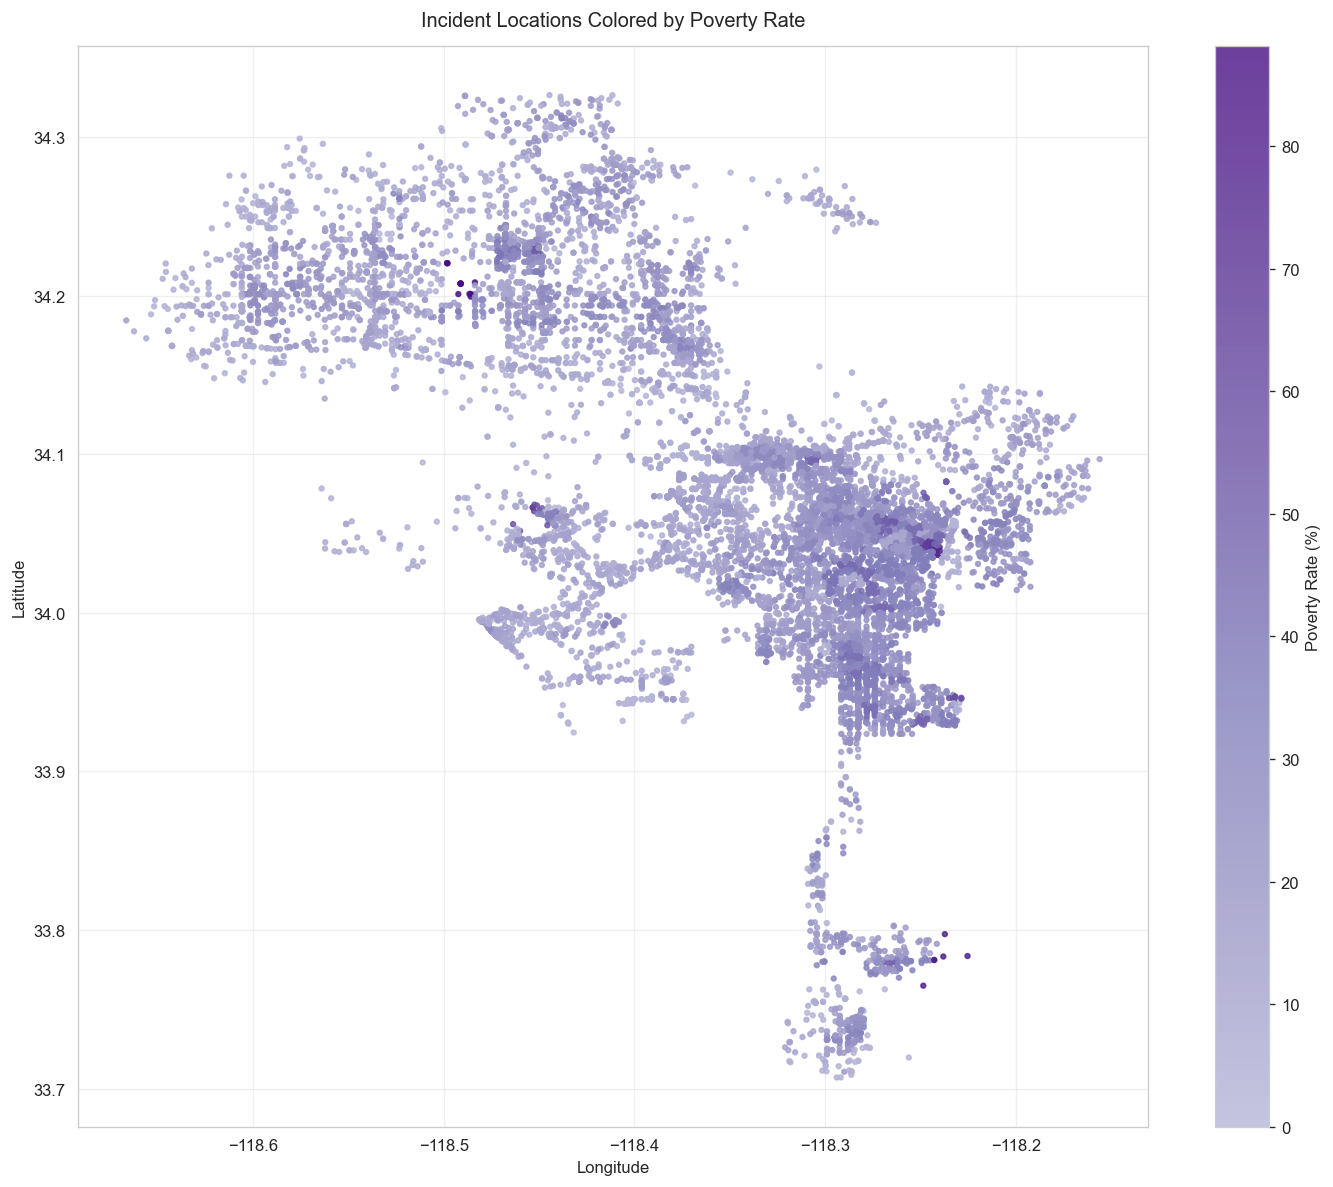

In [326]:
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.colors as colors
def truncate_colormap(cmap_name, min_val=0.3, max_val=1.0):
    """Return a truncated colormap from min_val to max_val."""
    cmap = plt.get_cmap(cmap_name)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc",
        cmap(np.linspace(min_val, max_val, 256))
    )
    return new_cmap

# Make Purples start darker
dark_purples = truncate_colormap("Purples", 0.4, 0.95)


# Ensure lat/lon exist
map_df = df.dropna(subset=["LAT", "LON", "Poverty_Rate"]).copy()
map_df["LAT"] = pd.to_numeric(map_df["LAT"], errors="coerce")
map_df["LON"] = pd.to_numeric(map_df["LON"], errors="coerce")
map_df = map_df.dropna(subset=["LAT", "LON"])

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(map_df["LON"], map_df["LAT"])]
gdf = gpd.GeoDataFrame(map_df, geometry=geometry, crs="EPSG:4326")

# Plot
plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["Poverty_Rate"],
    cmap=dark_purples,   # <-- use darker purples
    s=8,
    alpha=0.8
)

cbar = plt.colorbar(scatter)
cbar.set_label("Poverty Rate (%)")

plt.title("Incident Locations Colored by Poverty Rate")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Mean Predicted Probability of Delayed by Poverty Level**

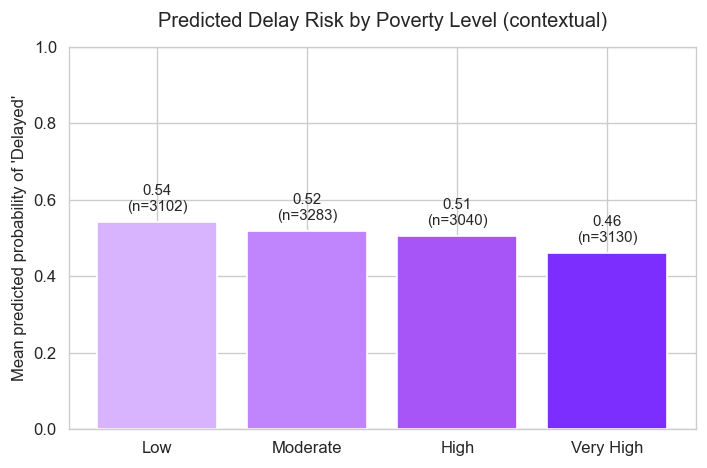

Caption: Mean predicted probability of reporting delay (1+ days) stratified by neighborhood Poverty_Level. Bars show how predicted risk varies across poverty bins and sample counts (n).


In [327]:
# Binned bar chart — mean predicted probability of 'Delayed' by Poverty_Level

# Ensure Poverty_Level exists; you created it earlier as categorical
df["Poverty_Level"] = df["Poverty_Level"].astype(str)

# Get predicted probabilities for the improved pipeline (class for '1+ days')
proba = pipeline.predict_proba(X)  # uses same X used for training/test earlier
# determine which column corresponds to delayed class in label encoder
delayed_class_index = list(le.classes_).index("1+ days") if "1+ days" in list(le.classes_) else 1
pred_probs = proba[:, delayed_class_index]

# Attach to original dataframe (aligning indices)
pred_proba_series = pd.Series(pred_probs, index=X.index, name="pred_proba_delayed")
df_probs = pd.concat([df, pred_proba_series], axis=1).dropna(subset=["pred_proba_delayed", "Poverty_Level"])

# Group by Poverty_Level and compute mean predicted probability
grouped = df_probs.groupby("Poverty_Level")["pred_proba_delayed"].agg(["mean", "count"]).reindex(["Low", "Moderate", "High", "Very High"])

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(grouped.index, grouped["mean"], color=[PURPLES[2], PURPLES[3], PURPLES[4], PURPLES[5]])
ax.set_ylim(0,1)
ax.set_ylabel("Mean predicted probability of 'Delayed'")
ax.set_title("Predicted Delay Risk by Poverty Level (contextual)")
for i, v in enumerate(grouped["mean"]):
    ax.text(i, v + 0.02, f"{v:.2f}\n(n={int(grouped['count'].iloc[i])})", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Caption
print("Caption: Mean predicted probability of reporting delay (1+ days) stratified by neighborhood Poverty_Level. Bars show how predicted risk varies across poverty bins and sample counts (n).")


**Reporting Delays by Distance to Nearest Hospital**

C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\1336086453.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = df.groupby('distance_bin')['Delayed_Binary'].mean()


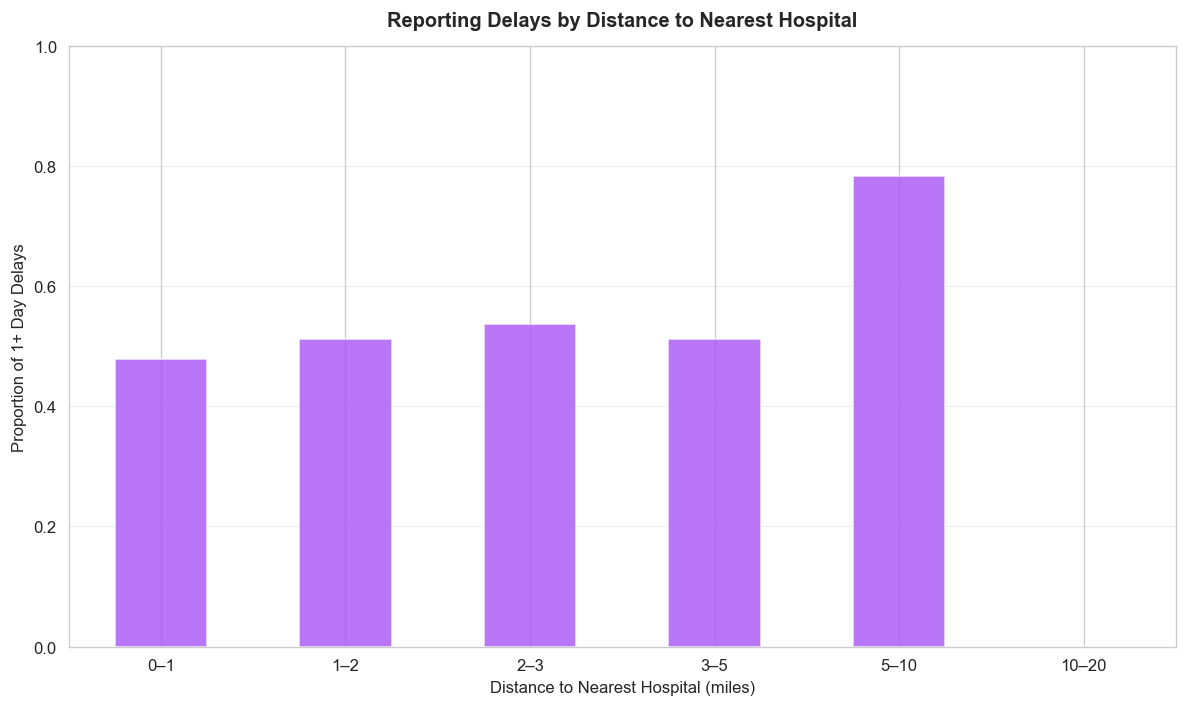

In [328]:
# Define bins and labels
bins = [0, 1, 2, 3, 5, 10, 20]
labels = ['0–1', '1–2', '2–3', '3–5', '5–10', '10–20']

# Create a binned column with labels
df['distance_bin'] = pd.cut(df['distance_miles'], bins=bins, labels=labels, include_lowest=True)

# Calculate proportion delayed in each bin
prop_df = df.groupby('distance_bin')['Delayed_Binary'].mean()

# Plot
plt.figure(figsize=(10, 6))
prop_df.plot(kind='bar', color=PURPLES[-2], alpha=0.8)

plt.ylabel('Proportion of 1+ Day Delays')
plt.xlabel('Distance to Nearest Hospital (miles)')
plt.title('Reporting Delays by Distance to Nearest Hospital', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # makes the proportion scale clear
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Fairness & Equity Evalutation Visuals

In [329]:
# Attatch predicted values and true labels for analysis
fairness_df = X_test.copy()
fairness_df["true_label"] = y_test_enc
fairness_df["pred_label"] = y_pred
fairness_df["Vict Age Group"] = X_test["Vict Age Group"]
fairness_df["AREA NAME"] = X_test["AREA NAME"]
fairness_df["Poverty_Rate"] = X_test["Poverty_Rate"]

fairness_df.head()

# Function to compute metrics by group
def compute_group_metrics(df, group_col):
    group_metrics = []
    for group, data in df.groupby(group_col):
        acc = accuracy_score(data["true_label"], data["pred_label"])
        prec = precision_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        rec = recall_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        f1 = f1_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)

        # Compute confusion matrix for FPR/FNR
        tn, fp, fn, tp = confusion_matrix(data["true_label"], data["pred_label"], labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        group_metrics.append({
            group_col: group,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            'FPR': fpr,
            'FNR': fnr
        })
    return pd.DataFrame(group_metrics).sort_values("Accuracy", ascending=False)

In [330]:
# Compute metrics by Victim Age Group
metrics_by_age = compute_group_metrics(fairness_df, "Vict Age Group")
metrics_by_age

,Vict Age Group,Accuracy,Precision,Recall,F1,FPR,FNR
2,Children (0-12),0.750000,0.663854,0.577926,0.579861,0.782609,0.061538
0,Adolescents (13-17),0.746006,0.734940,0.647012,0.656915,0.637255,0.068720
4,Young Adults (18-24),0.651261,0.636304,0.624583,0.625871,0.227758,0.523077
3,Older Adults (50+),0.650442,0.654525,0.637926,0.634641,0.204918,0.519231
1,Adults (25-49),0.644489,0.633813,0.619129,0.618886,0.218213,0.543529


In [331]:
# Compute metrics by Area of Crime Occurence
metrics_by_area = compute_group_metrics(fairness_df, "AREA NAME")
metrics_by_area.head(10)  # Show top 10 areas

,AREA NAME,Accuracy,Precision,Recall,F1,FPR,FNR
14,Southeast,0.760000,0.754637,0.751834,0.753030,0.194444,0.301887
6,Hollywood,0.752941,0.739274,0.744322,0.741342,0.219048,0.292308
10,Northeast,0.747368,0.731638,0.731638,0.731638,0.333333,0.203390
3,Foothill,0.742268,0.727252,0.729505,0.728291,0.324324,0.216667
4,Harbor,0.704762,0.704793,0.704644,0.704655,0.307692,0.283019
11,Olympic,0.700000,0.706473,0.711429,0.699248,0.220000,0.357143
5,Hollenbeck,0.691176,0.691176,0.692677,0.690574,0.290323,0.324324
8,N Hollywood,0.685185,0.679365,0.677363,0.678121,0.382979,0.262295
7,Mission,0.684211,0.640568,0.618462,0.622794,0.589744,0.173333
0,77th Street,0.681159,0.676923,0.676087,0.676440,0.278261,0.369565


In [332]:
fairness_df['Poverty_Level'] = pd.cut(
    fairness_df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

# Compute metrics by Poverty Level
metrics_by_poverty = compute_group_metrics(fairness_df, "Poverty_Level")
metrics_by_poverty.head()

C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\2008528305.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df.groupby(group_col):


,Poverty_Level,Accuracy,Precision,Recall,F1,FPR,FNR
0,Low,0.702362,0.701011,0.695527,0.696534,0.380623,0.228324
3,Very High,0.700321,0.702968,0.690374,0.690889,0.194690,0.424561
2,High,0.678694,0.678492,0.678384,0.678420,0.308725,0.334507
1,Moderate,0.637313,0.636186,0.636864,0.636204,0.368932,0.357341


**Victim Age Group by Delay Category & Premise Type by Delay Category**

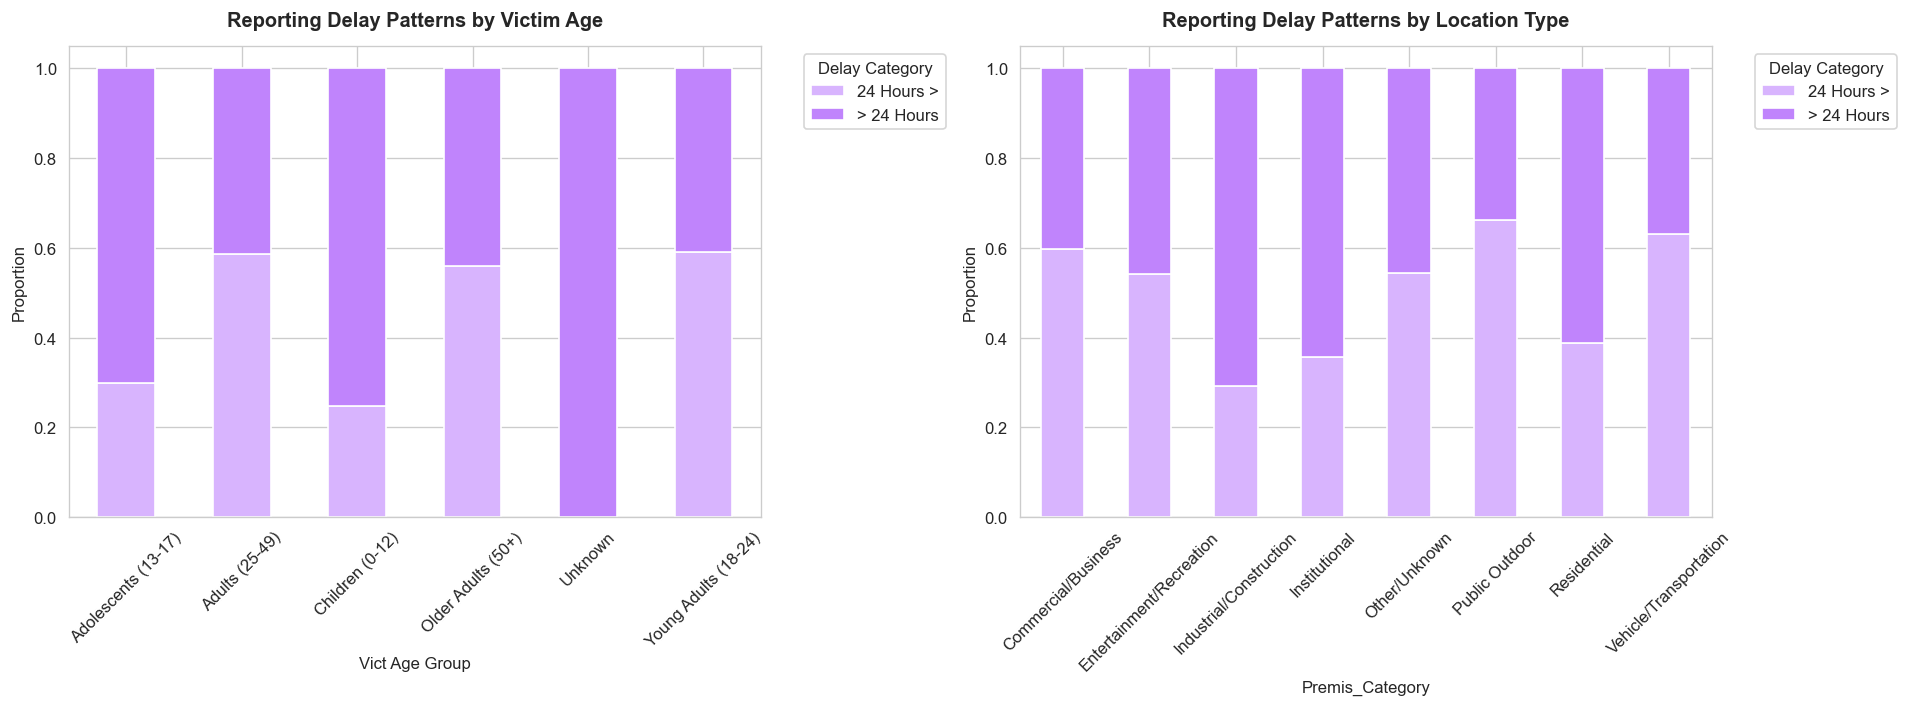

In [333]:
# Cell X: Delay Patterns by Age and Premise, using darker PURPLES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Use only the darker PURPLES (skip the lightest 2)
stack_colors = PURPLES[2:]  # adjust indices if needed

# 1️⃣ Victim Age Group by Delay Category
age_delay_cross = pd.crosstab(df['Vict Age Group'], df['Delay_Category_Categorical'], normalize='index')
age_delay_cross.plot(kind='bar', stacked=True, ax=ax1, color=stack_colors)
ax1.set_title('Reporting Delay Patterns by Victim Age', fontweight='bold')
ax1.set_ylabel('Proportion')
ax1.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2️⃣ Premise Type by Delay Category
premise_delay_cross = pd.crosstab(df['Premis_Category'], df['Delay_Category_Categorical'], normalize='index')
premise_delay_cross.head(8).plot(kind='bar', stacked=True, ax=ax2, color=stack_colors)
ax2.set_title('Reporting Delay Patterns by Location Type', fontweight='bold')
ax2.set_ylabel('Proportion')
ax2.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Model Performance by Victim Age Group & Poverty Level**

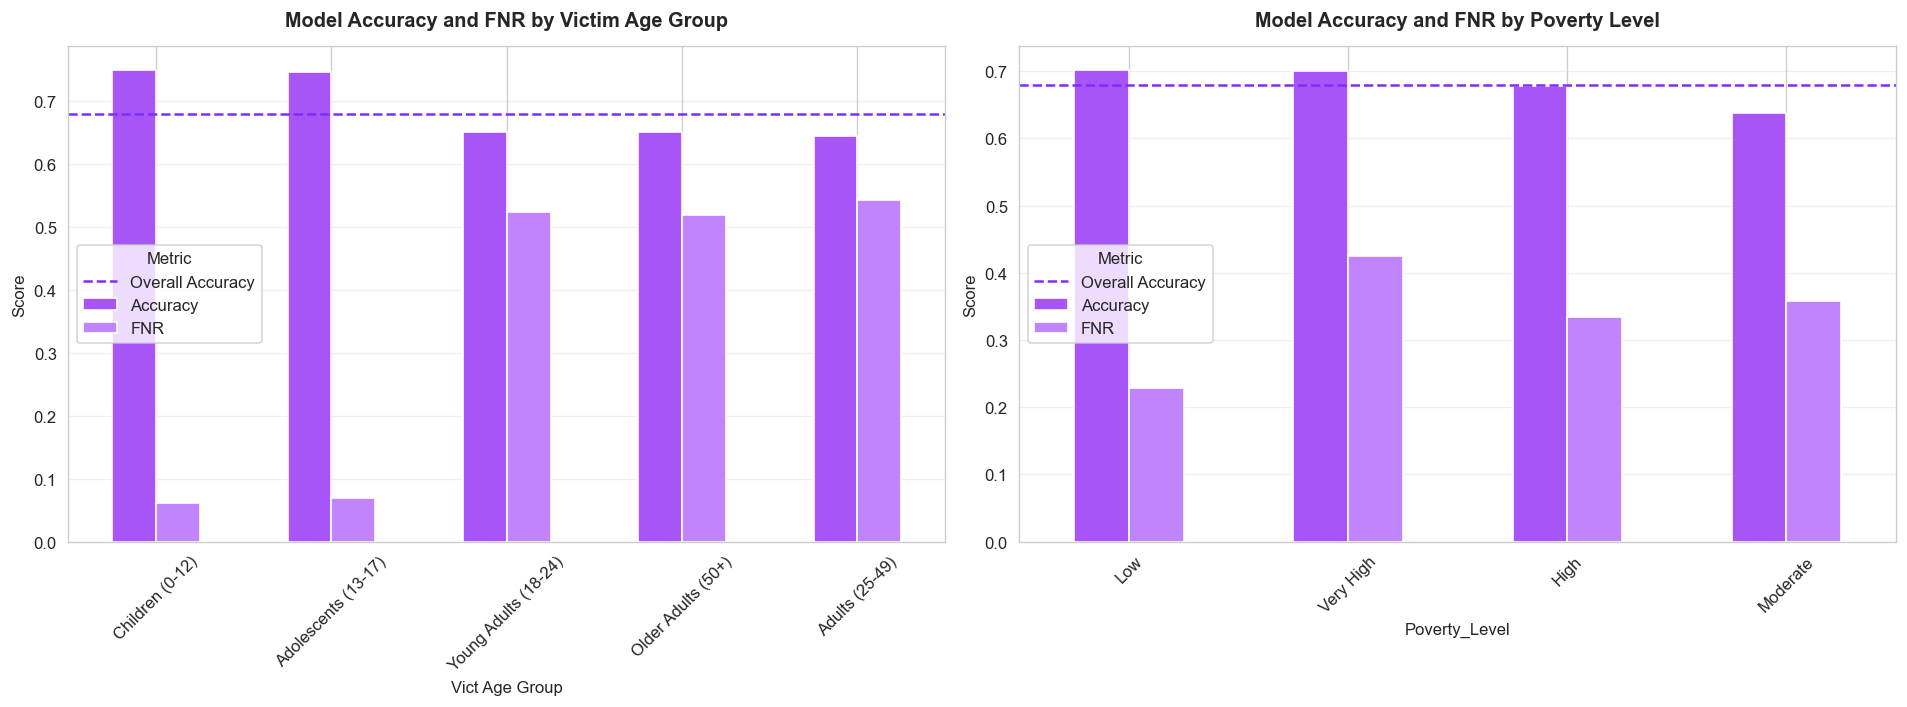

In [334]:
# Cell X: Model Accuracy and FNR by Age Group and Poverty Level
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Two darker PURPLES for Accuracy vs FNR
metric_colors = [PURPLES[-2], PURPLES[-3]]  # Accuracy, FNR

# 1️⃣ Performance by Age Group
metrics_by_age.plot(
    x='Vict Age Group', 
    y=['Accuracy', 'FNR'],  # include FNR
    kind='bar', 
    ax=ax1, 
    color=metric_colors
)
ax1.axhline(y=acc, color=PURPLES[-1], linestyle='--', label='Overall Accuracy')
ax1.set_title('Model Accuracy and FNR by Victim Age Group', fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(title='Metric')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2️⃣ Performance by Poverty Level
metrics_by_poverty.plot(
    x='Poverty_Level', 
    y=['Accuracy', 'FNR'],  # include FNR
    kind='bar', 
    ax=ax2, 
    color=metric_colors
)
ax2.axhline(y=acc, color=PURPLES[-1], linestyle='--', label='Overall Accuracy')
ax2.set_title('Model Accuracy and FNR by Poverty Level', fontweight='bold')
ax2.set_ylabel('Score')
ax2.legend(title='Metric')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\1814214817.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\kayle\AppData\Local\Temp\ipykernel_19684\1814214817.py:4: UserWarning: 
The palette list has fewer values (6) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


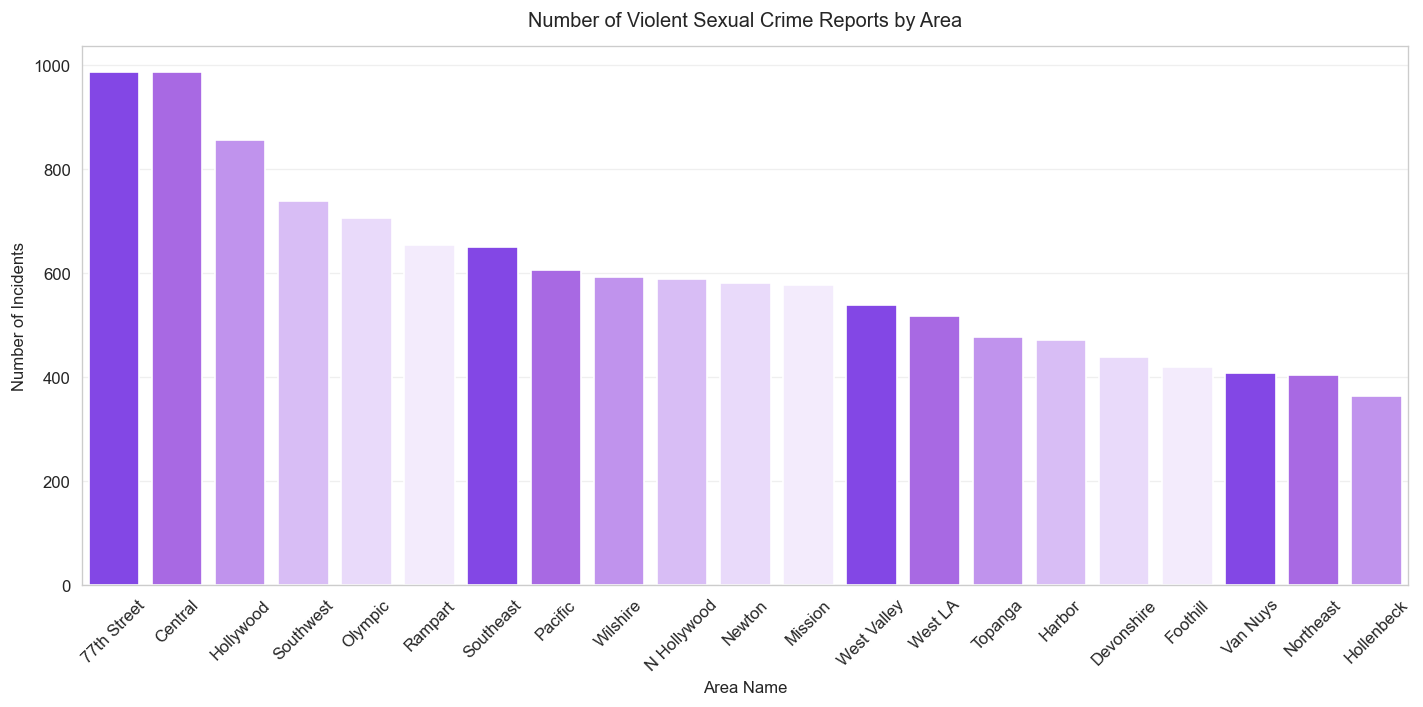

In [335]:
# Cell X: Bar Chart by AREA
area_counts = df['AREA NAME'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(
    x=area_counts.index, 
    y=area_counts.values, 
    palette=PURPLES[::-1]
)
plt.xticks(rotation=45)
plt.ylabel("Number of Incidents")
plt.xlabel("Area Name")
plt.title("Number of Violent Sexual Crime Reports by Area")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
